### **KITTI Dataset Scene Visualization and Evaluation**

#### **1. Import Required Libraries**

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from shapely.geometry import box
from shapely.affinity import rotate
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### **2. Define Scene IDs**

In [2]:
scene_ids = ['006067', '006059', '006310', '006227', '006121', '006315', '006211',
    '006042', '006130', '006374', '006037', '006097', '006048', '006206',
    '006253', '006098', '006291', '006312', '006329', '006054']

#### **3. Define Helper Functions**

**3.1 Rotate Bounding Box**

In [3]:
def rotate_bbox_shapely(bbox, angle, origin):
    return rotate(bbox, angle, origin=origin, use_radians=False)

**3.2 Calculate IoU (Intersection over Union)**

In [4]:
def calculate_iou(box1, box2):
    intersection = box1.intersection(box2).area
    union = box1.union(box2).area
    return intersection / union

**3.3 Plot Bounding Boxes**

In [5]:
def plot_bbox(ax, bbox, color, alpha, linewidth, text=None, text_color='white', text_weight='bold'):
    ax.plot(*bbox.exterior.xy, color=color, linewidth=linewidth, alpha=alpha)
    if text:
        x, y = bbox.exterior.xy
        ax.text(x[0]-20, y[0], text, color=text_color, fontsize=10, ha='center', va='bottom', alpha=alpha, weight=text_weight)

**3.4 Save Processed Scene**

In [6]:
def save_processed_scene(scene_id, fig, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    output_path = os.path.join(output_folder, f"scene_{scene_id}_output.png")
    fig.savefig(output_path, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)

#### **4. Process Each Scene**

In [7]:
def process_scene(scene_id, gt_labels, pred_labels):
    bev = cv2.imread(f"./KITTI_Selection/bev/{scene_id}.png")

    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Display scene name at the top
    plt.text(0.5, 1.02, f'Scene {scene_id}', ha='center', va='center', transform=ax.transAxes, color='#0067A5', fontsize=14, fontweight='bold')

    ax.imshow(bev[:, :, [2, 1, 0]])

    true_positives, false_positives, false_negatives = 0, 0, 0

    processed_gt_indices = set()

    gt_boxes = [box(label[1] - label[3] / 2, label[2] - label[4] / 2, label[1] + label[3] / 2, label[2] + label[4] / 2) for label in gt_labels]
    rotated_gt_boxes = [rotate_bbox_shapely(gt_bbox, np.degrees(np.arctan2(label[5], label[6])), (label[1], label[2])) for gt_bbox, label in zip(gt_boxes, gt_labels)]
    rotated_pred_boxes = []

    for gt_bbox, rotated_gt_bbox in zip(gt_boxes, rotated_gt_boxes):
        max_iou = 0  

        for pred_label in pred_labels:
            pred_x, pred_y, pred_w, pred_l, pred_im, pred_re, _, _, _ = pred_label
            pred_bbox = box(pred_x - pred_w / 2, pred_y - pred_l / 2, pred_x + pred_w / 2, pred_y + pred_l / 2)
            rotated_pred_bbox = rotate_bbox_shapely(pred_bbox, np.degrees(np.arctan2(pred_im, pred_re)), (pred_x, pred_y))

            iou = calculate_iou(rotated_gt_bbox, rotated_pred_bbox)

            plot_bbox(ax, rotate_bbox_shapely(pred_bbox, np.degrees(np.arctan2(pred_im, pred_re)), (pred_x, pred_y)), linewidth=1.0, color='red', alpha=0.4)

            if max_iou < iou:
                max_iou = iou

        plot_bbox(ax, rotated_gt_bbox, color='Green', text=f"{max_iou:.2f}", linewidth=2.0, alpha=0.99, text_color='white', text_weight='bold')

        if max_iou > 0.5:
            true_positives += 1
        else:
            false_negatives += 1

        processed_gt_indices.add(gt_bbox)

    false_positives = len(pred_labels) - true_positives
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    ax.imshow(bev[:, :, [2, 1, 0]])

    # Display precision and recall at the bottom of the plot
    plt.text(0.5, -0.05, f'Precision: {precision:.3f}, Recall: {recall:.3f}', ha='center', va='center', transform=ax.transAxes, color='#0067A5', fontsize=12, fontweight='bold')

    # Add legend
    plt.scatter([], [], c='green', label='Ground Truth')
    plt.scatter([], [], c='red', label='Prediction')
    plt.legend()

    # Set plot limits to fit bounding boxes within the image
    ax.set_xlim([0, bev.shape[1]])
    ax.set_ylim([bev.shape[0], 0])

    # Display the plot
    plt.show()

    # Add information box at the bottom-left corner
    info_text = f"Scene: {scene_id}\nTP: {true_positives}\nFP: {false_positives}\nFN: {false_negatives}"
    ax.text(0.05, 0.05, info_text, transform=ax.transAxes, color='#0067A5', fontsize=10, fontweight='bold', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

    # Save the processed scene without the color legend
    save_processed_scene(scene_id, fig, output_folder)

#### **5. Run Scene Processing**

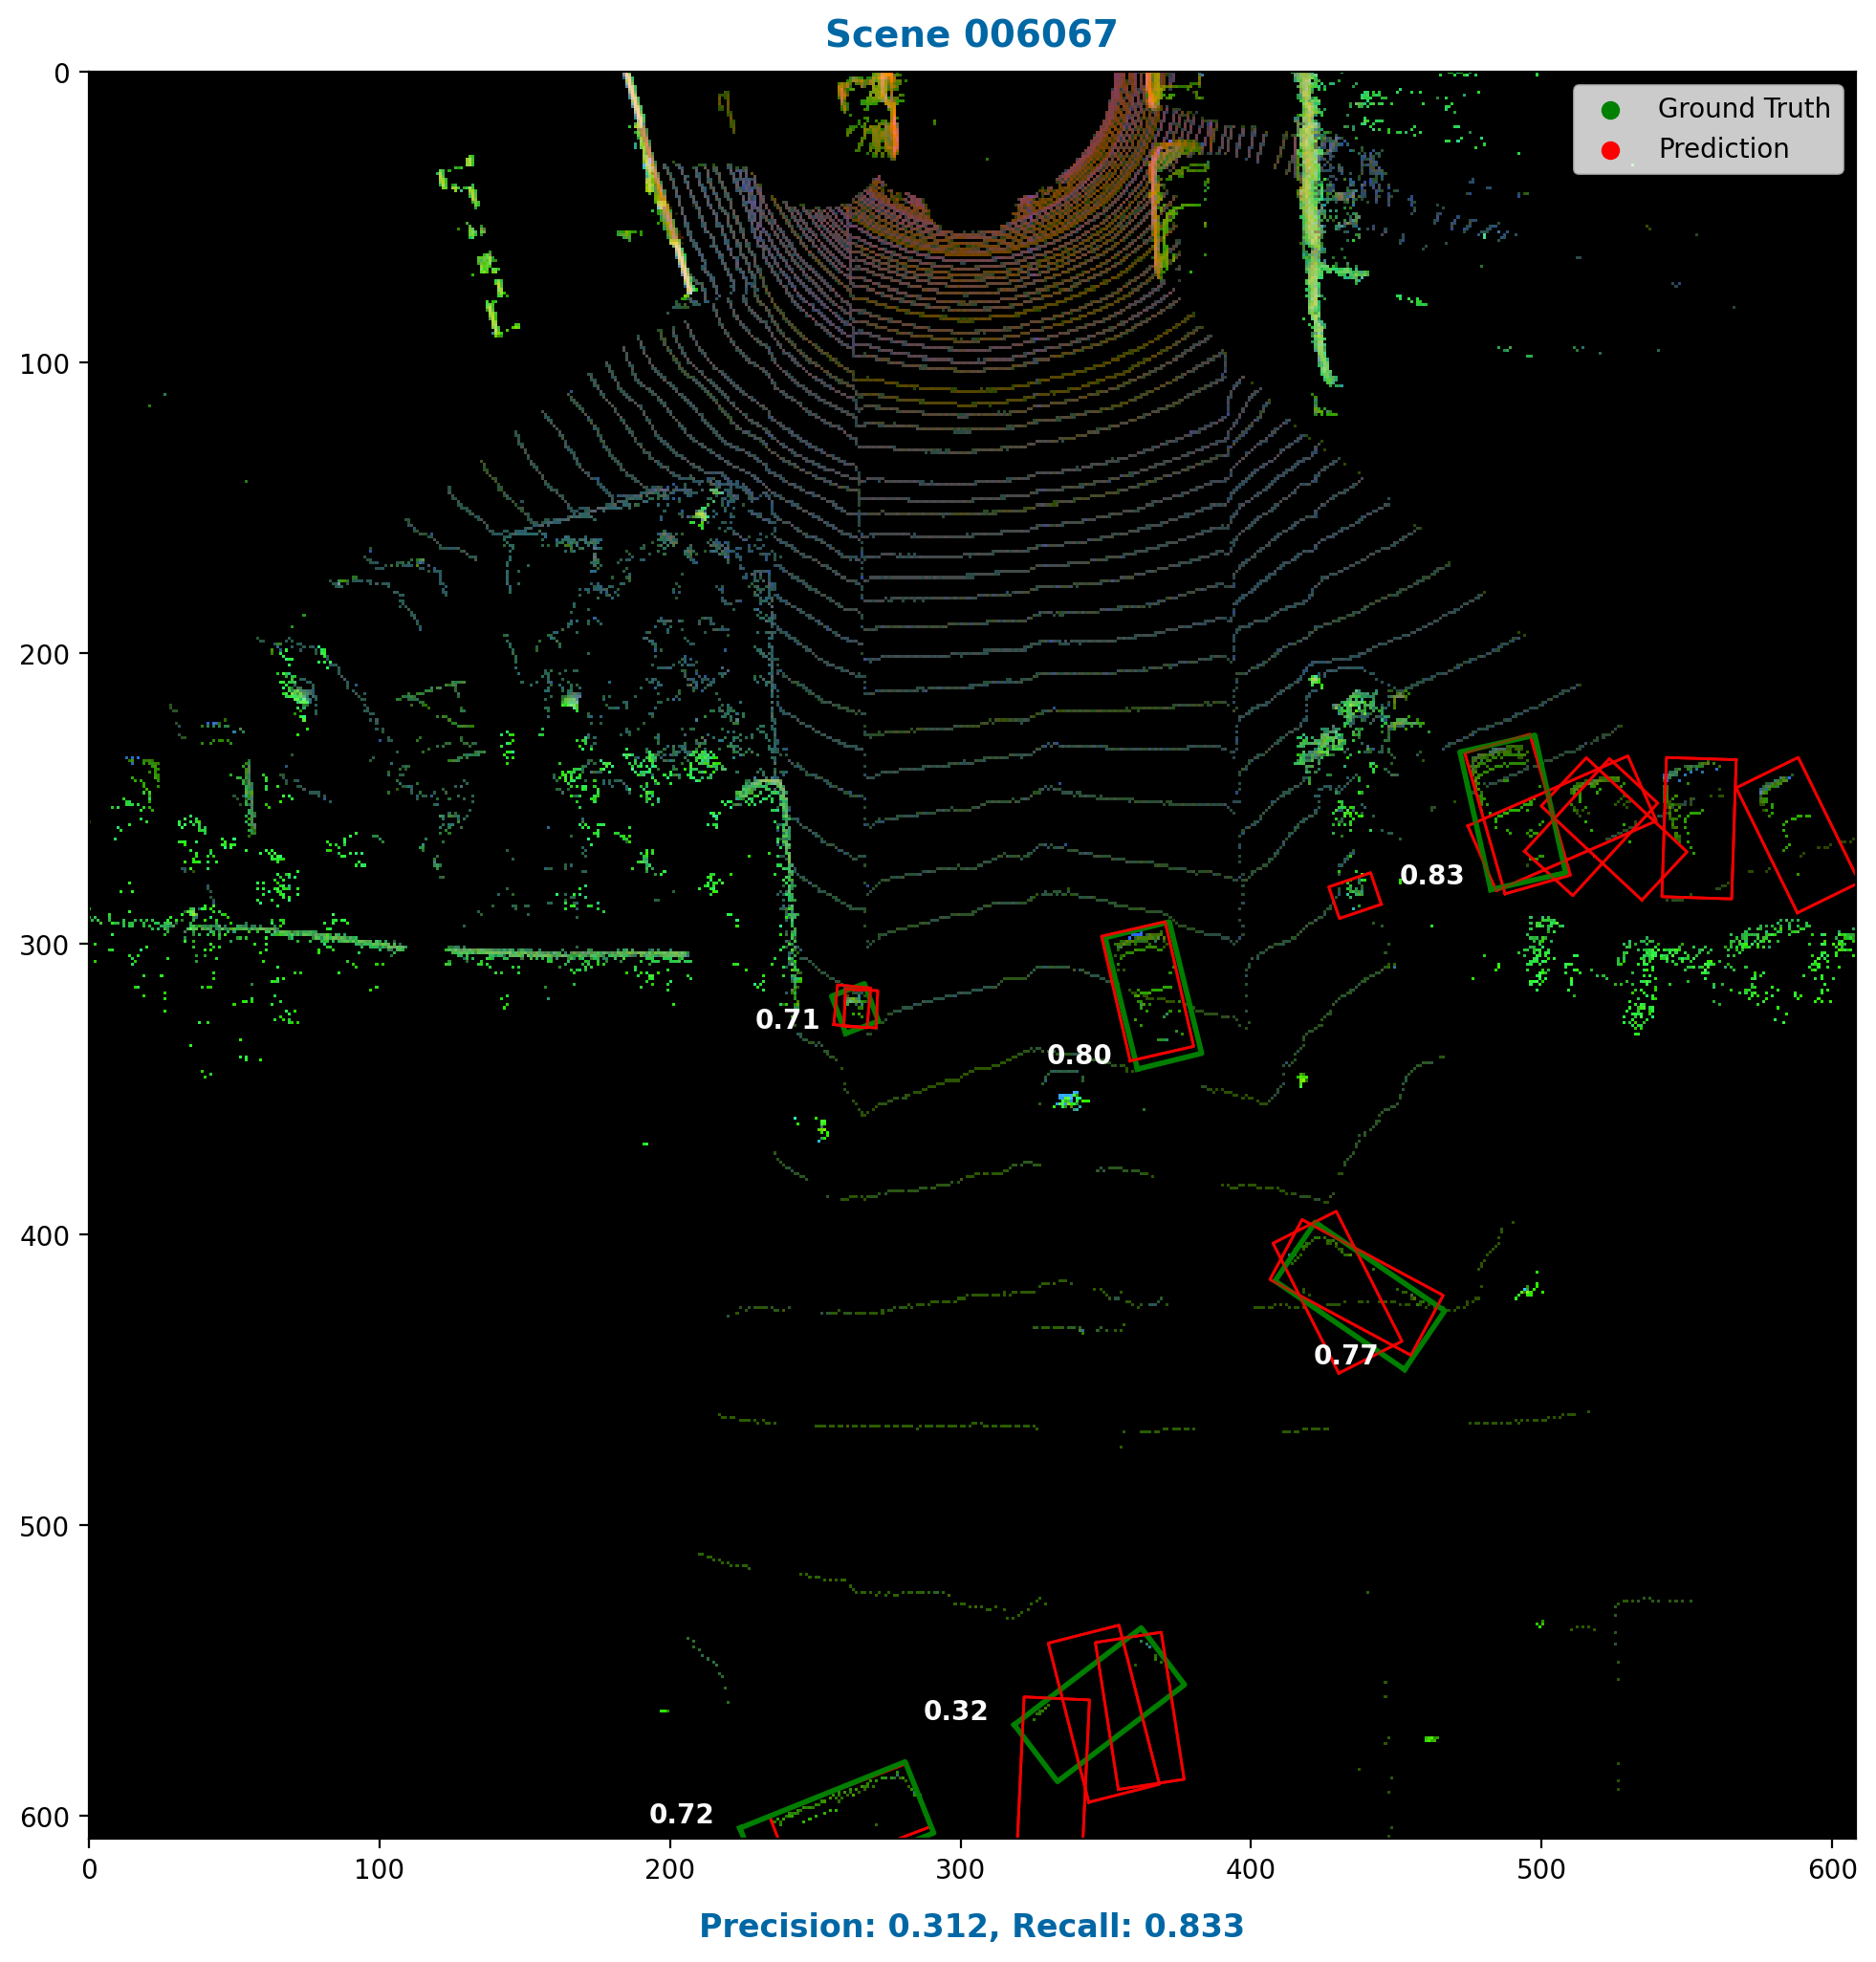

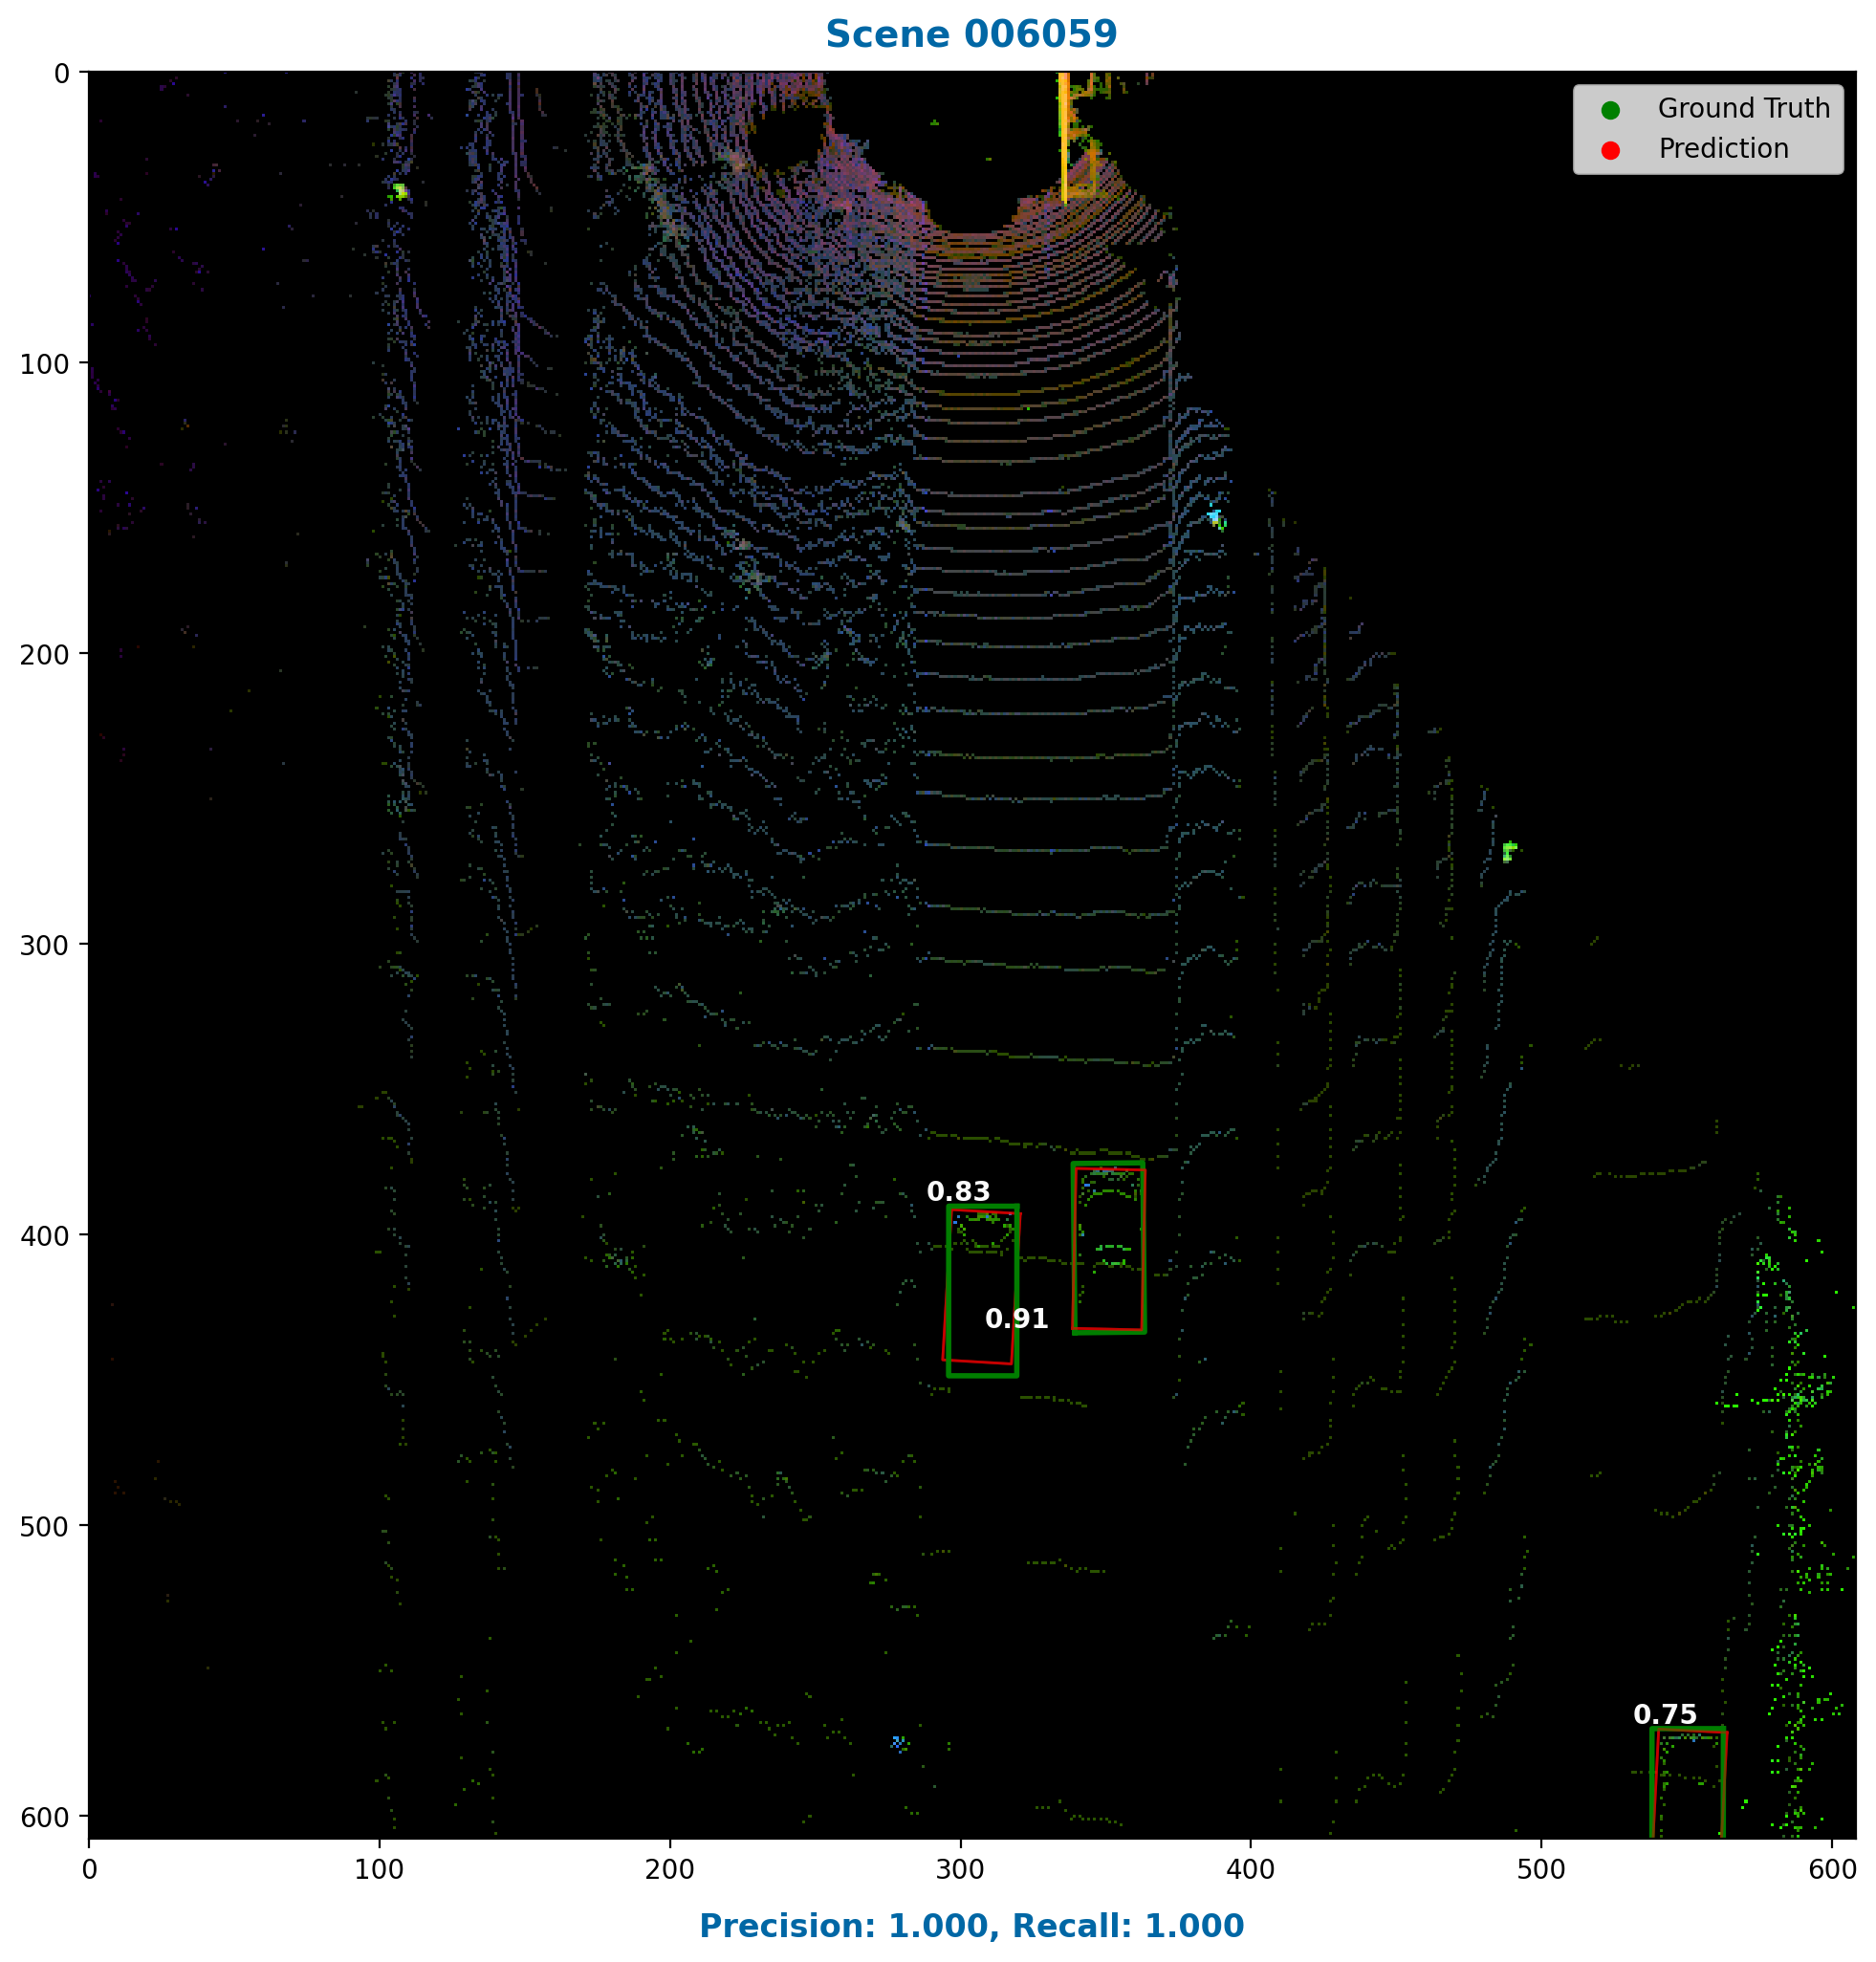

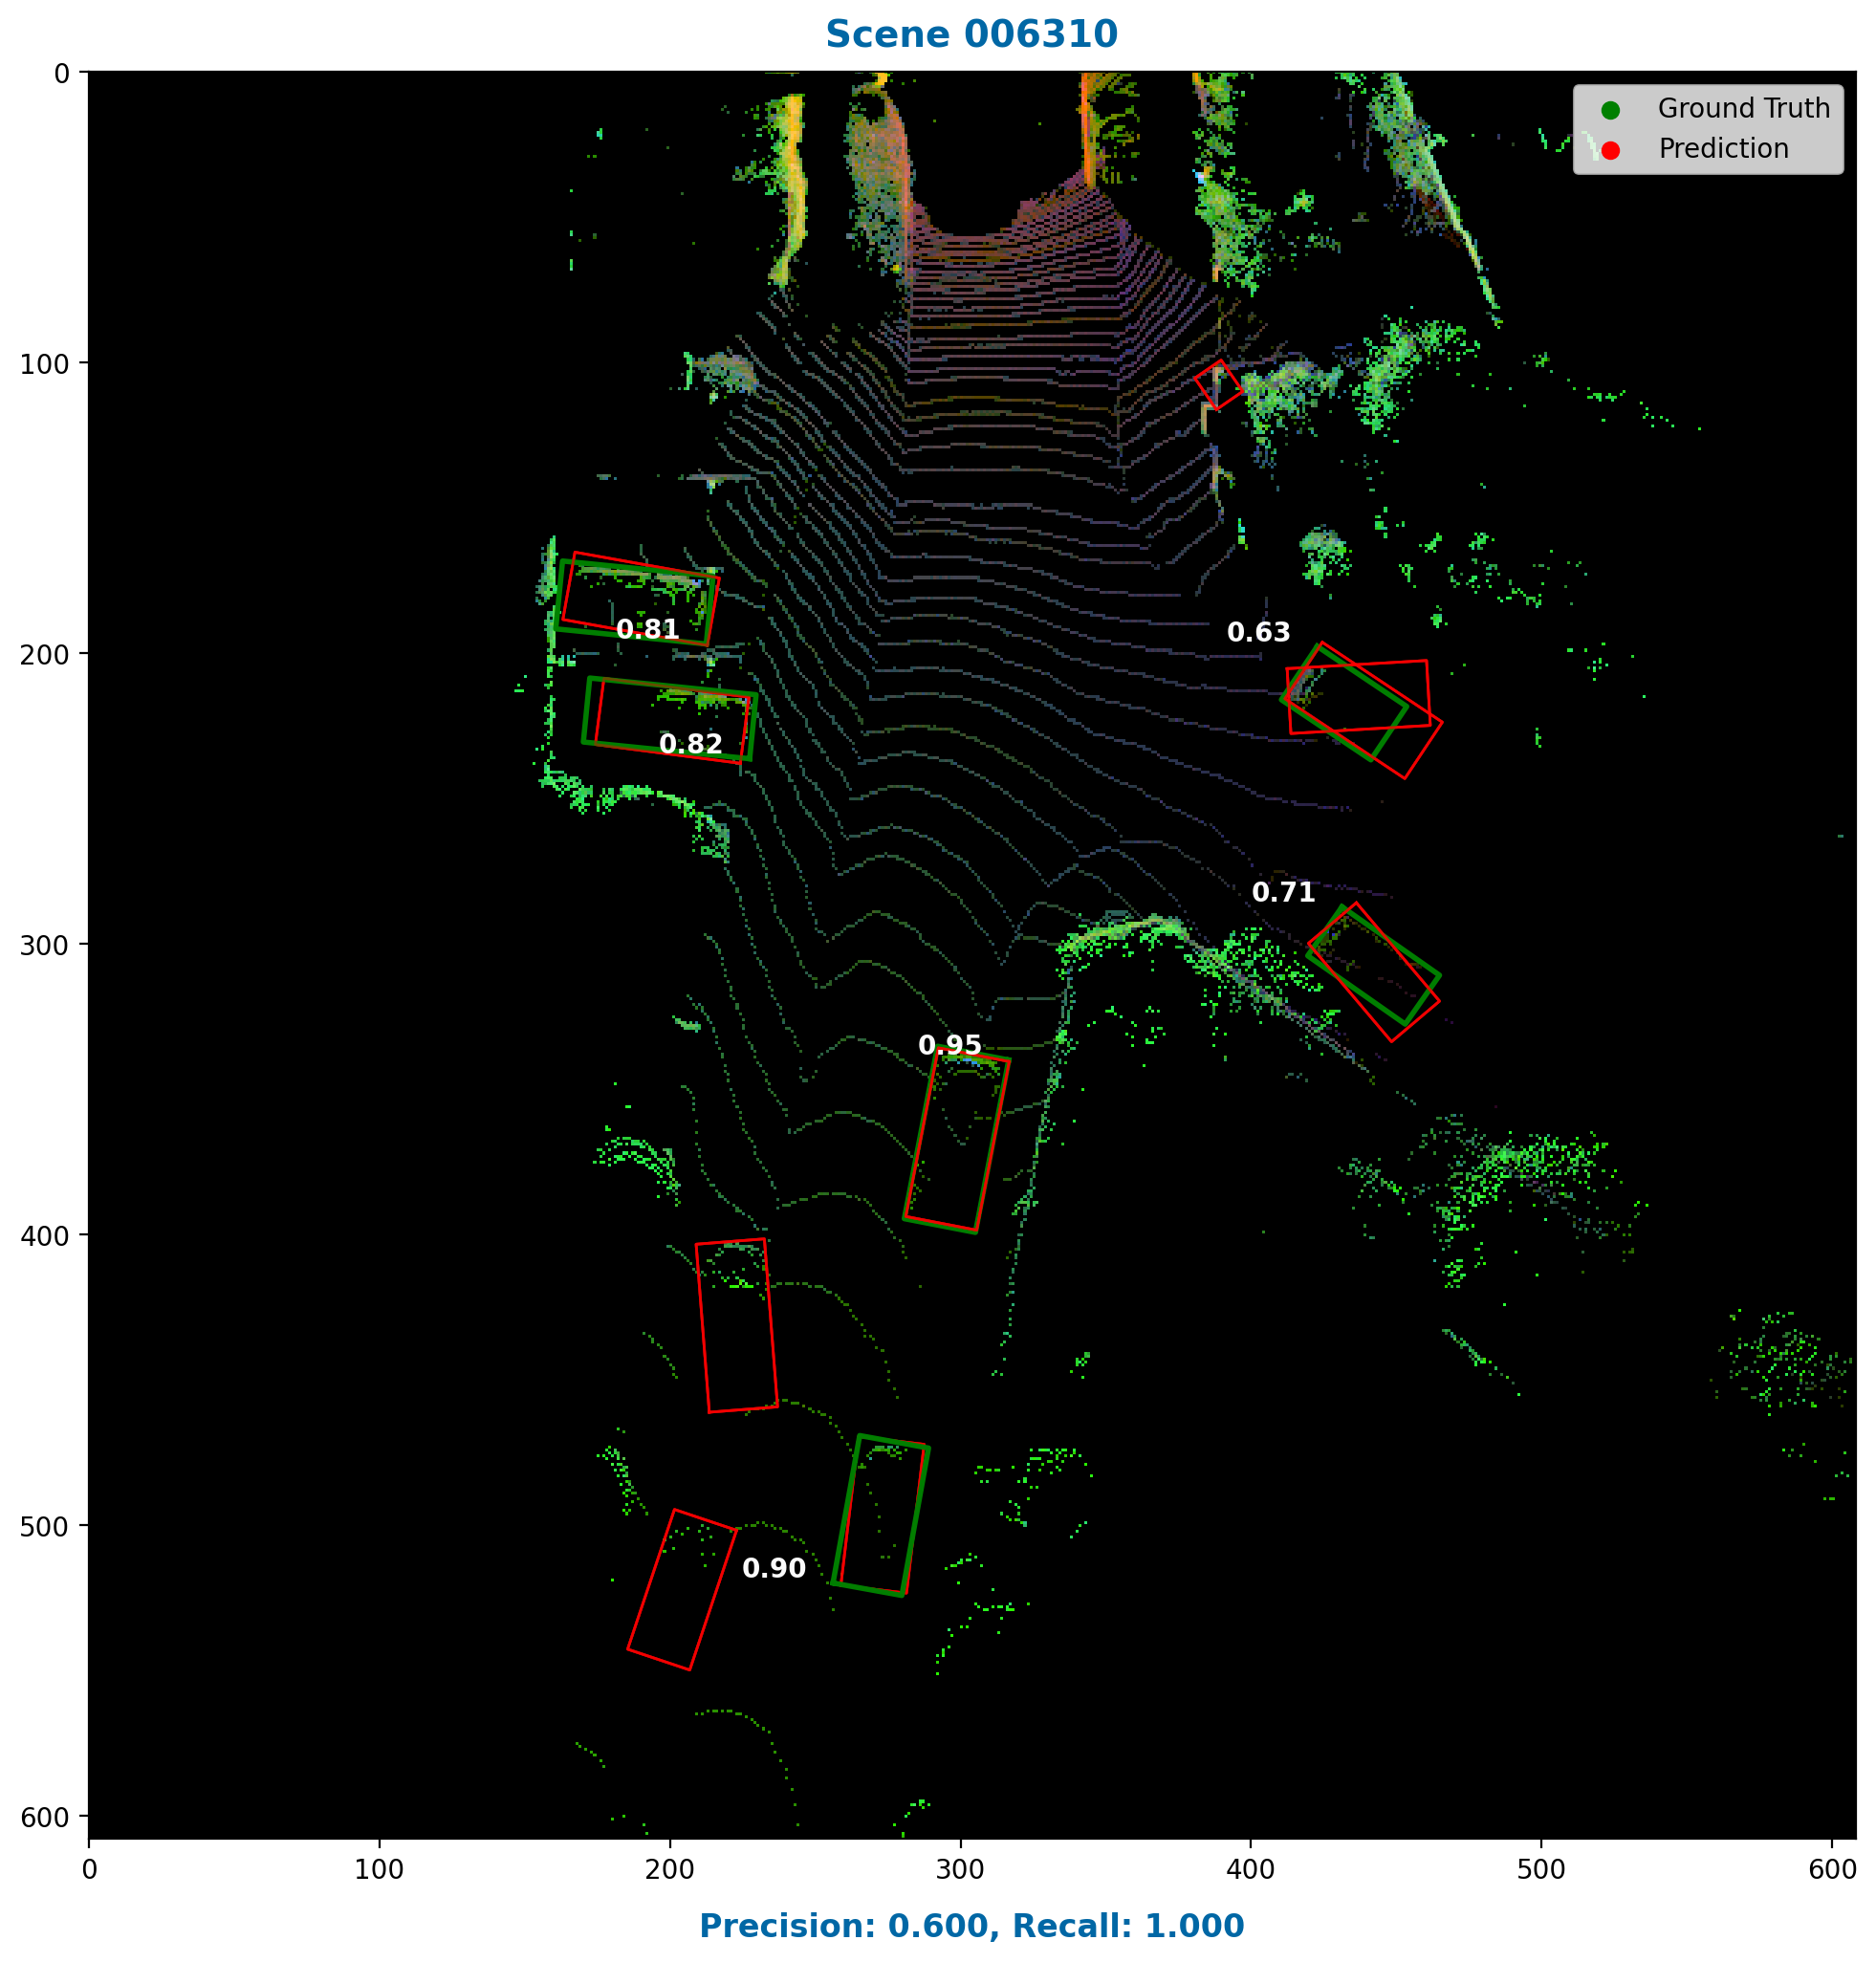

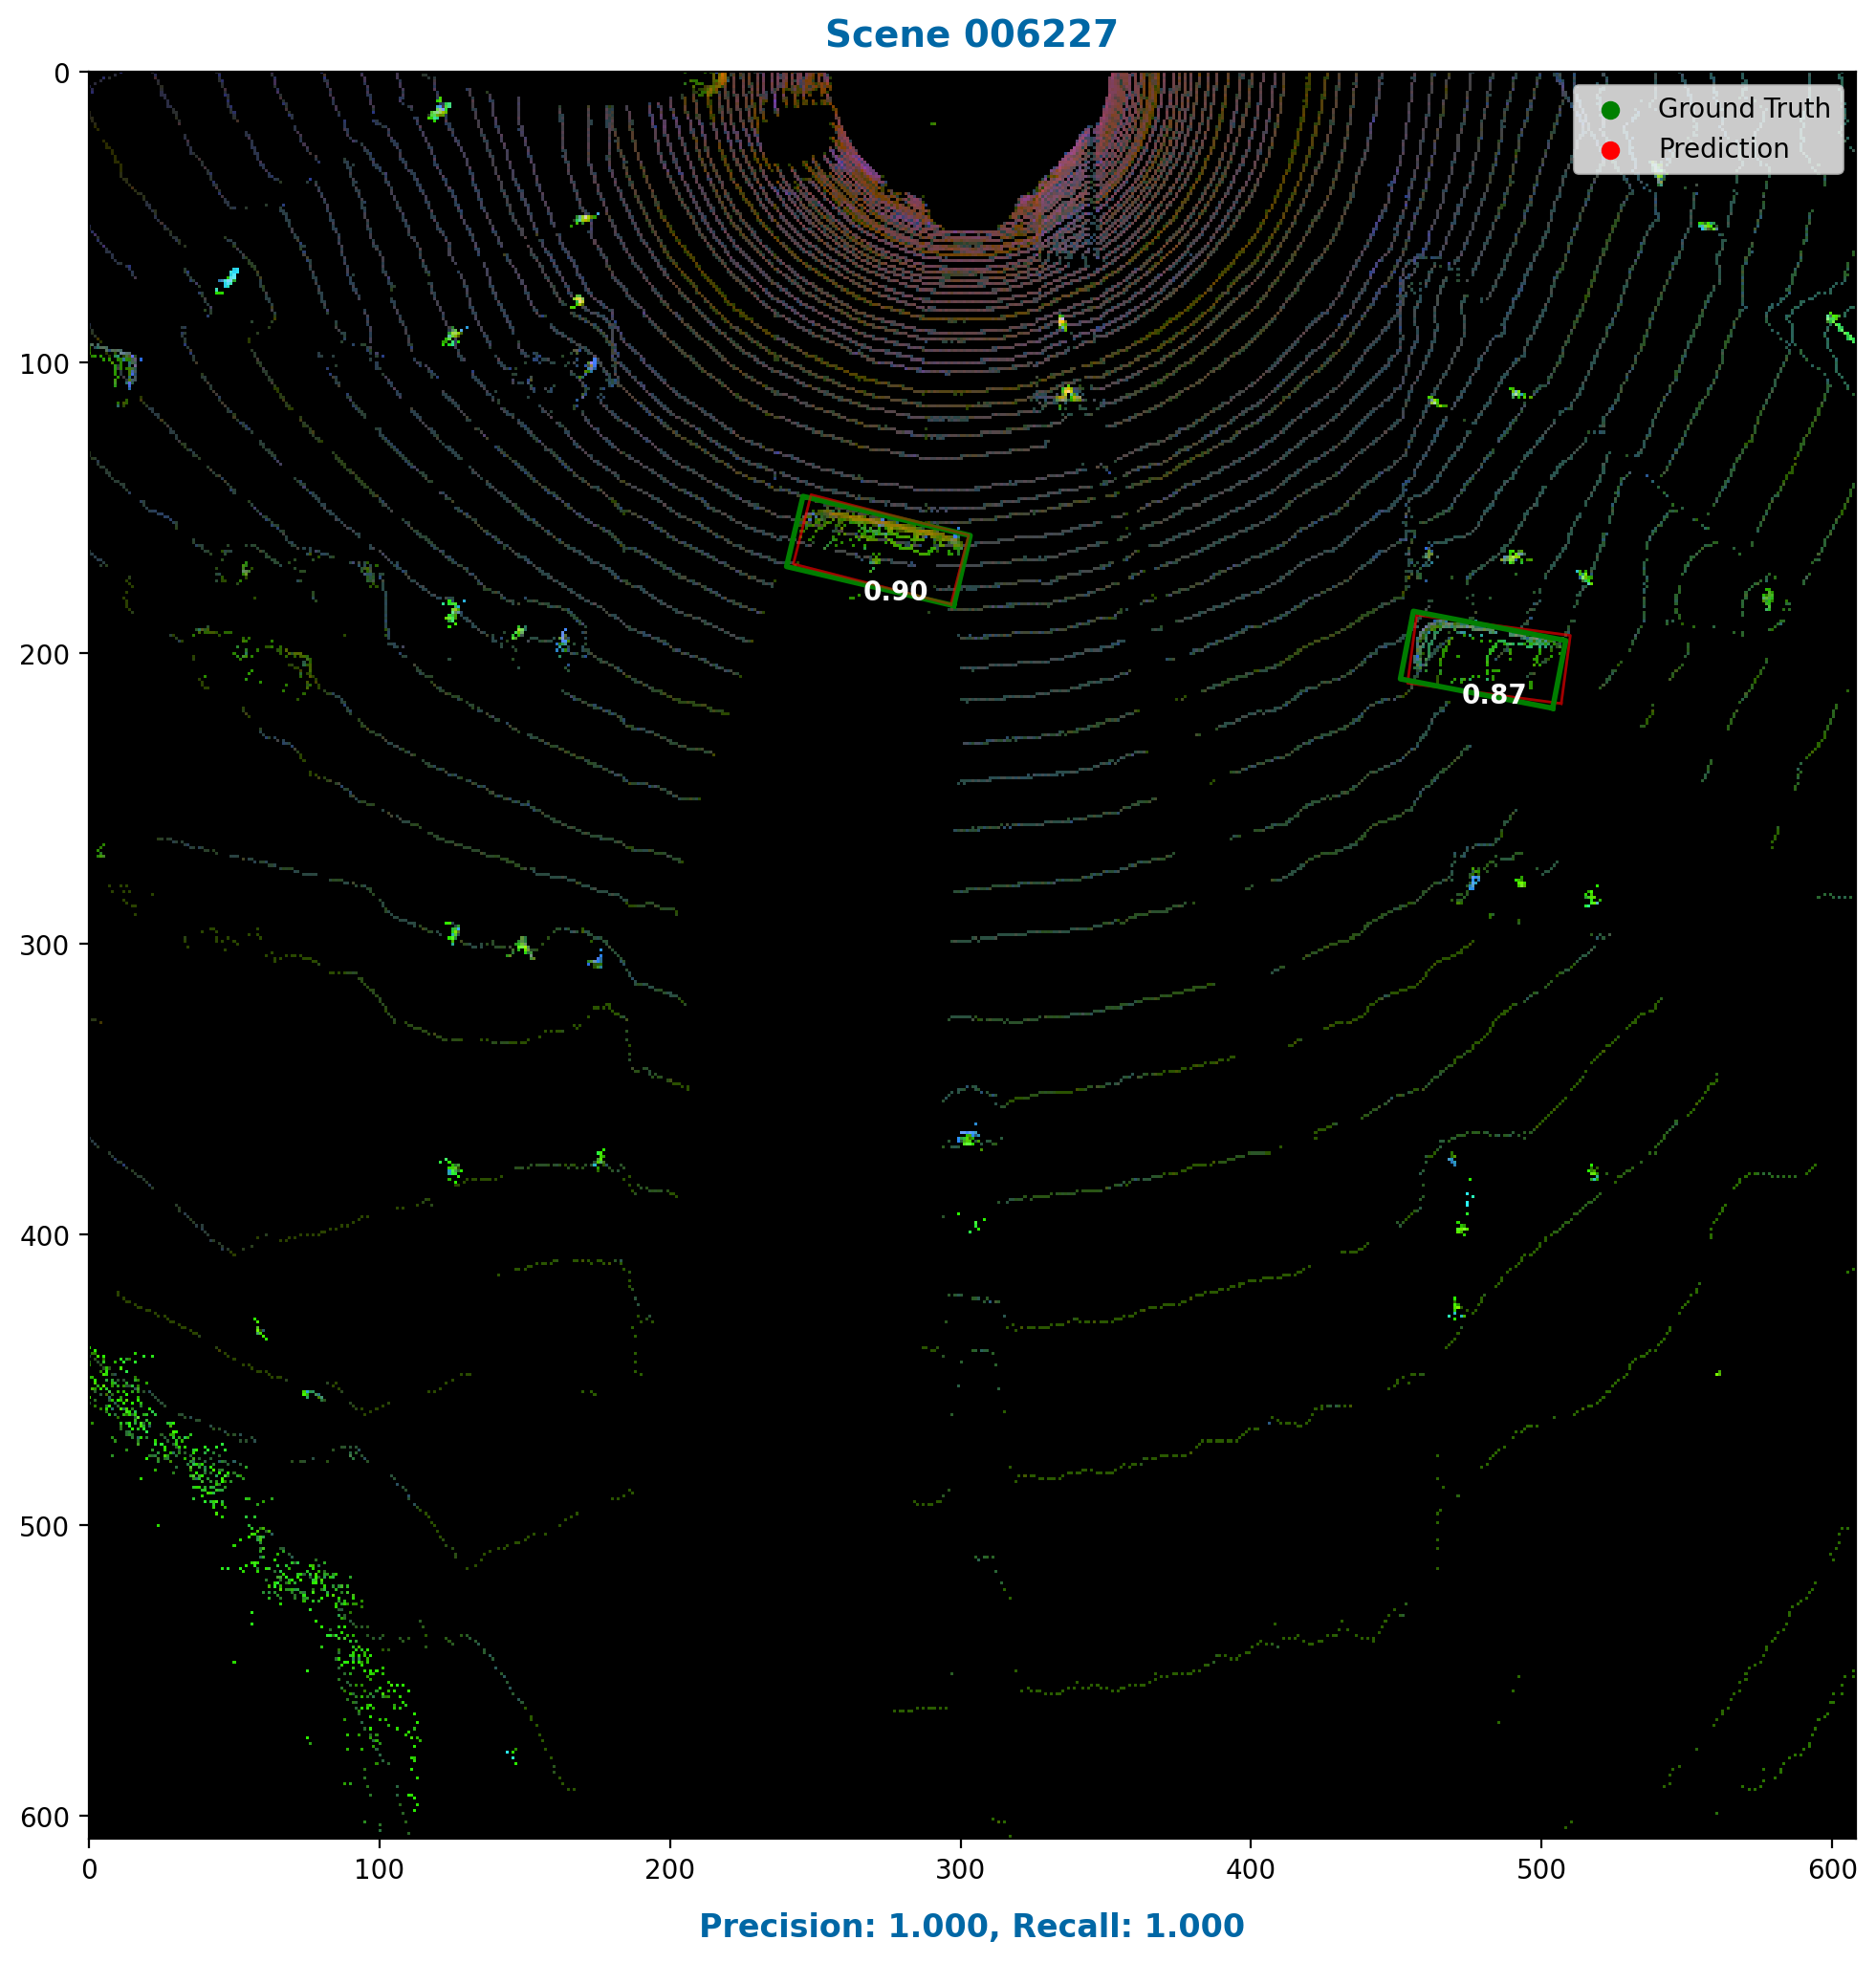

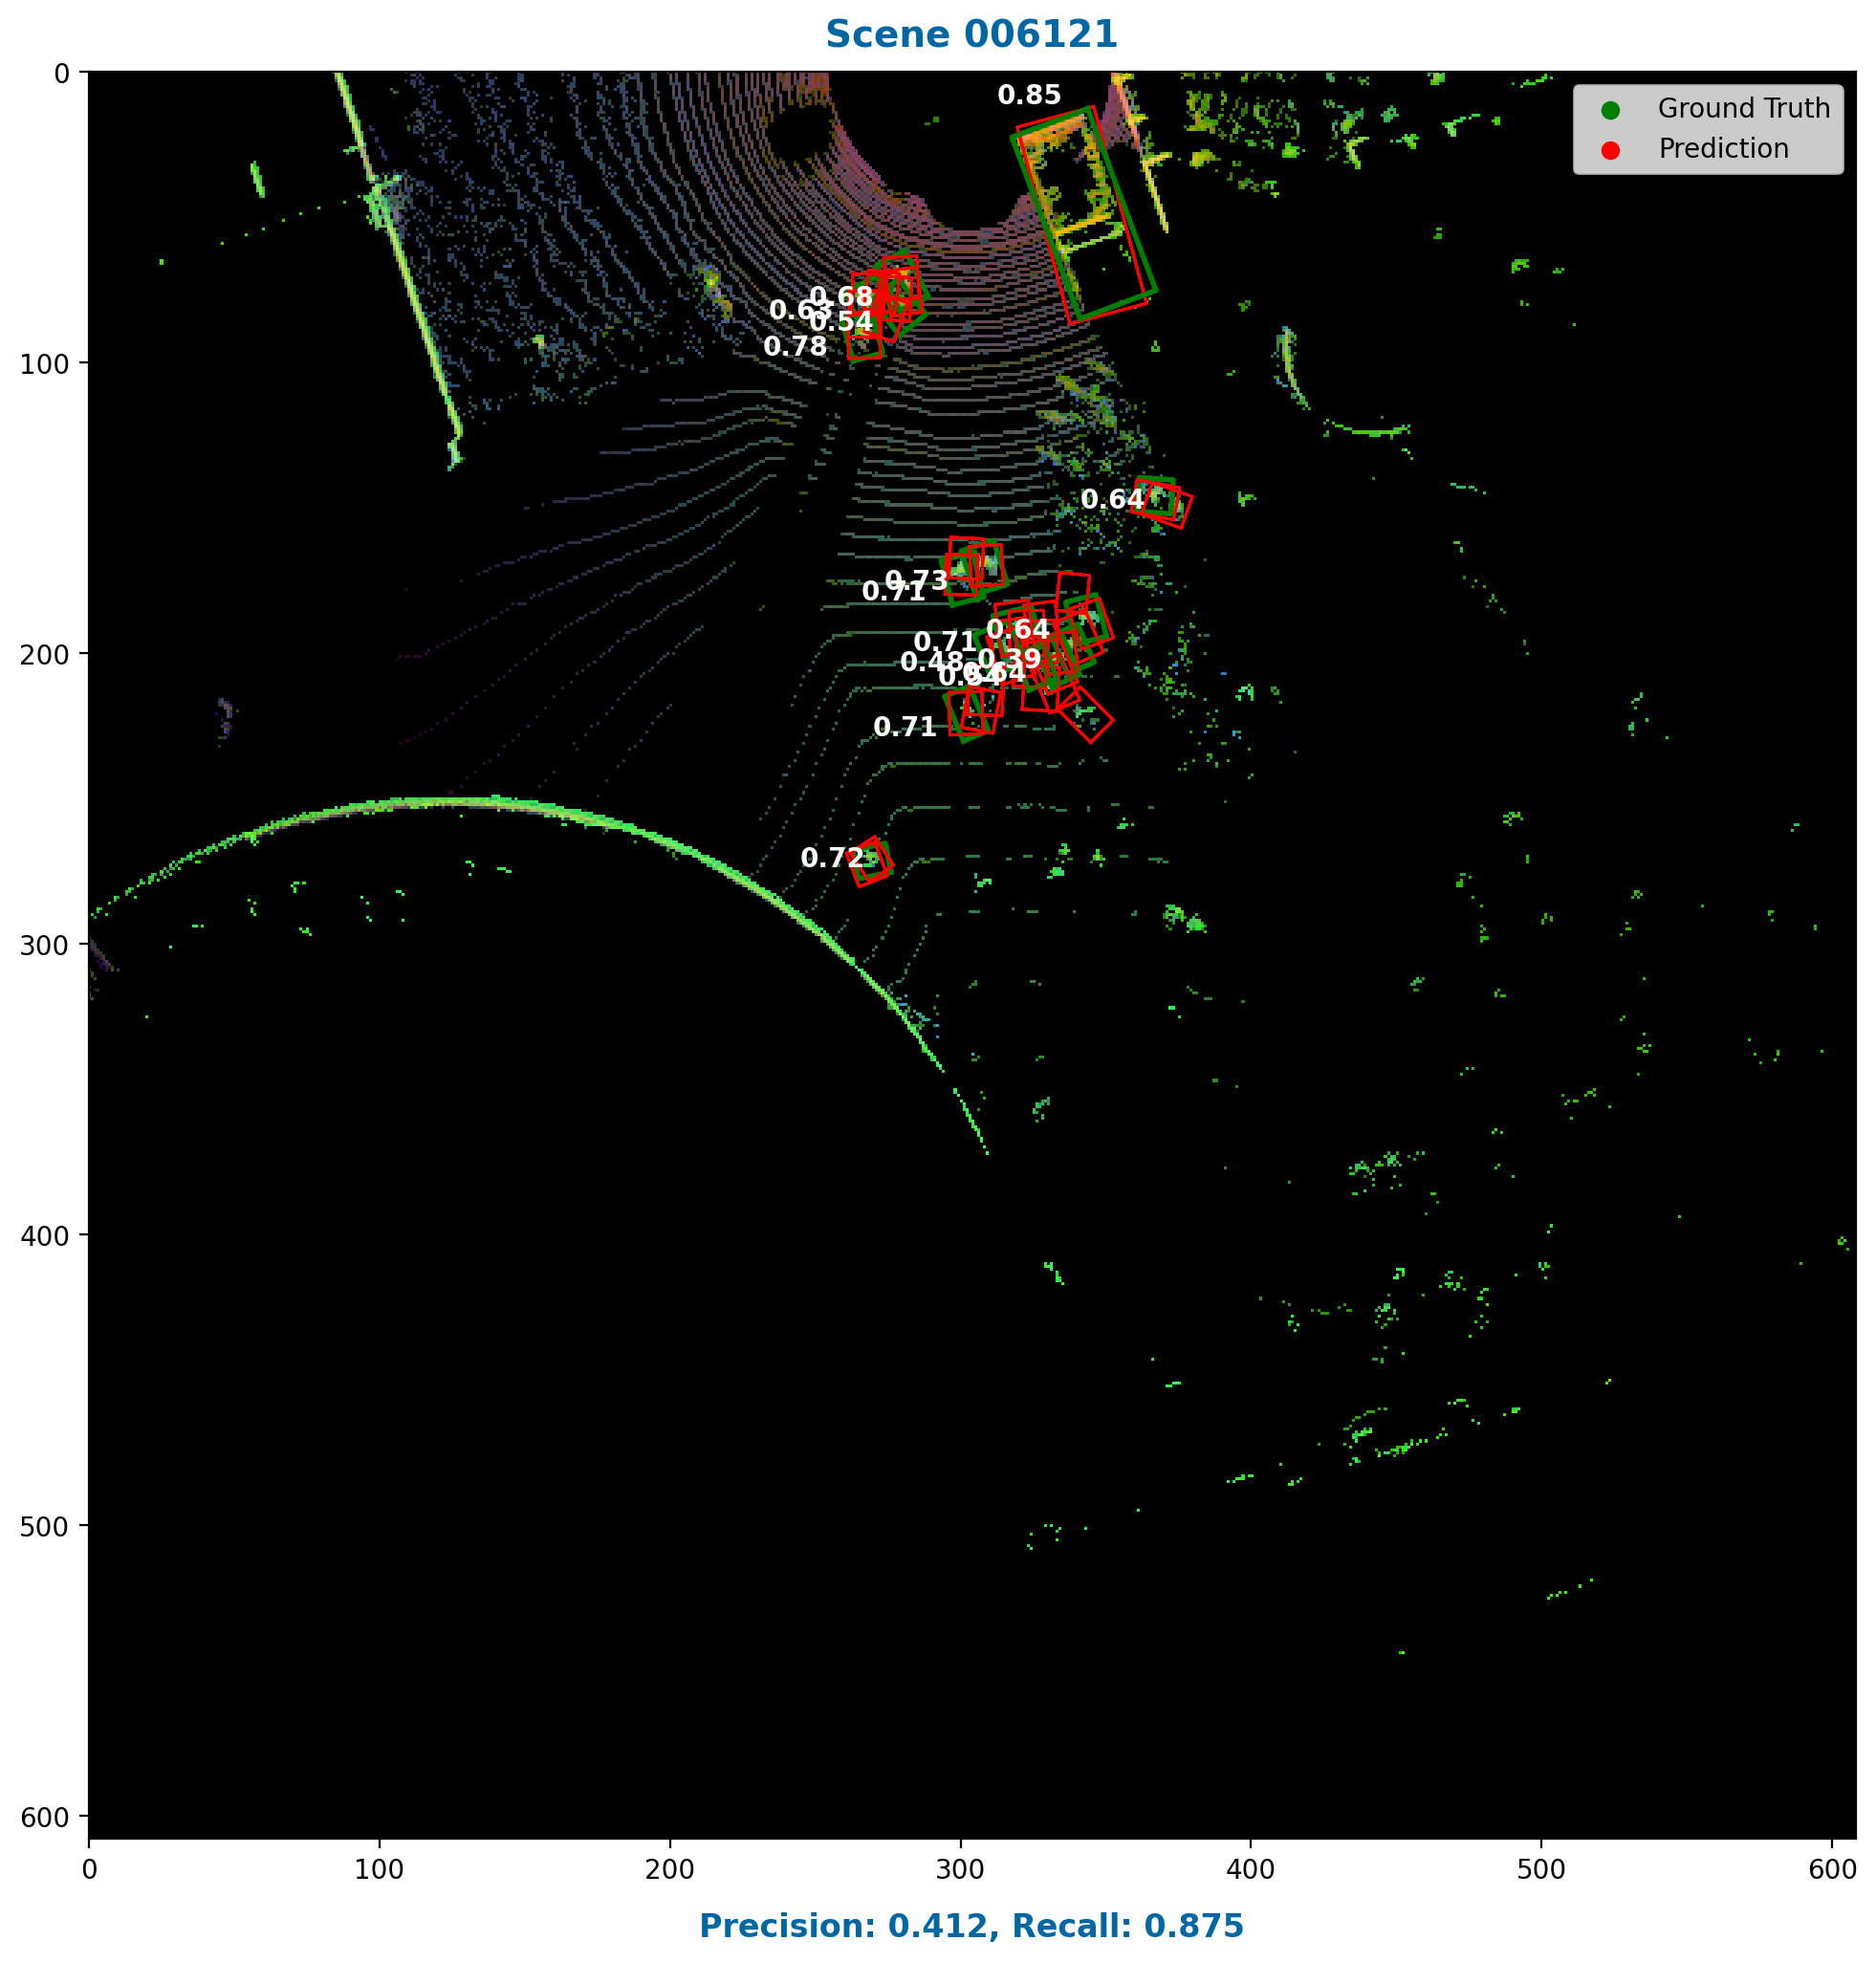

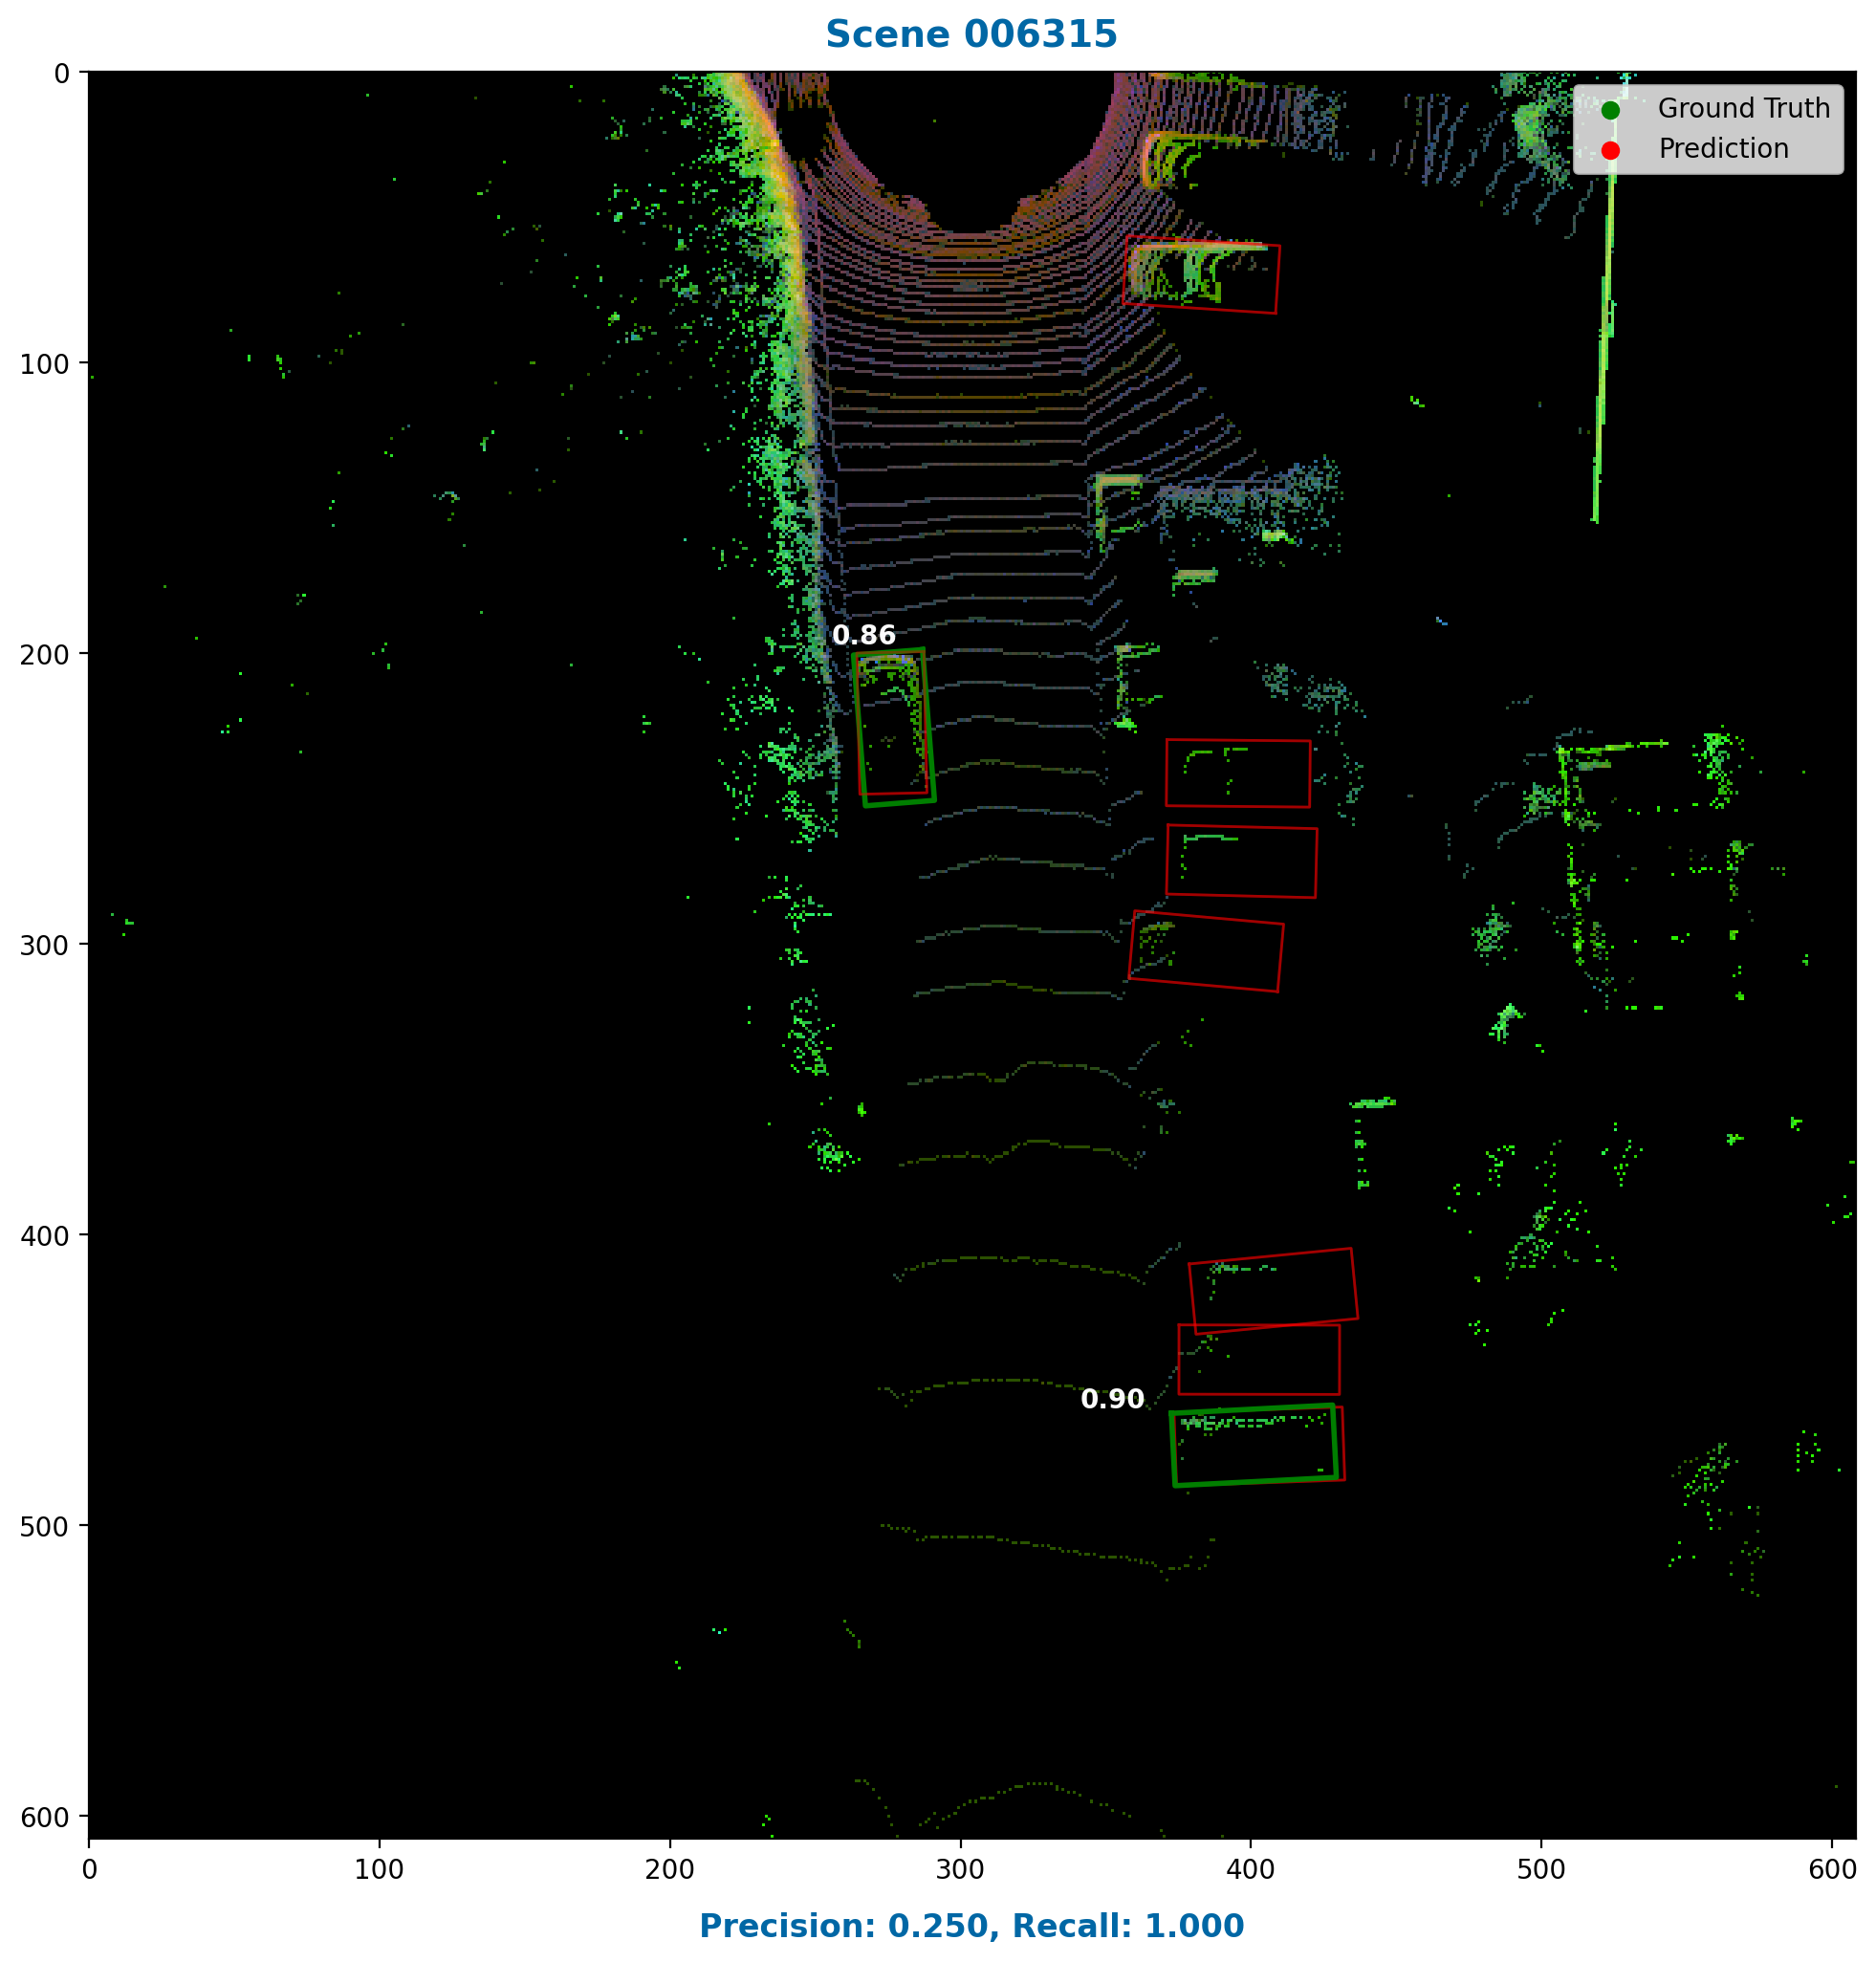

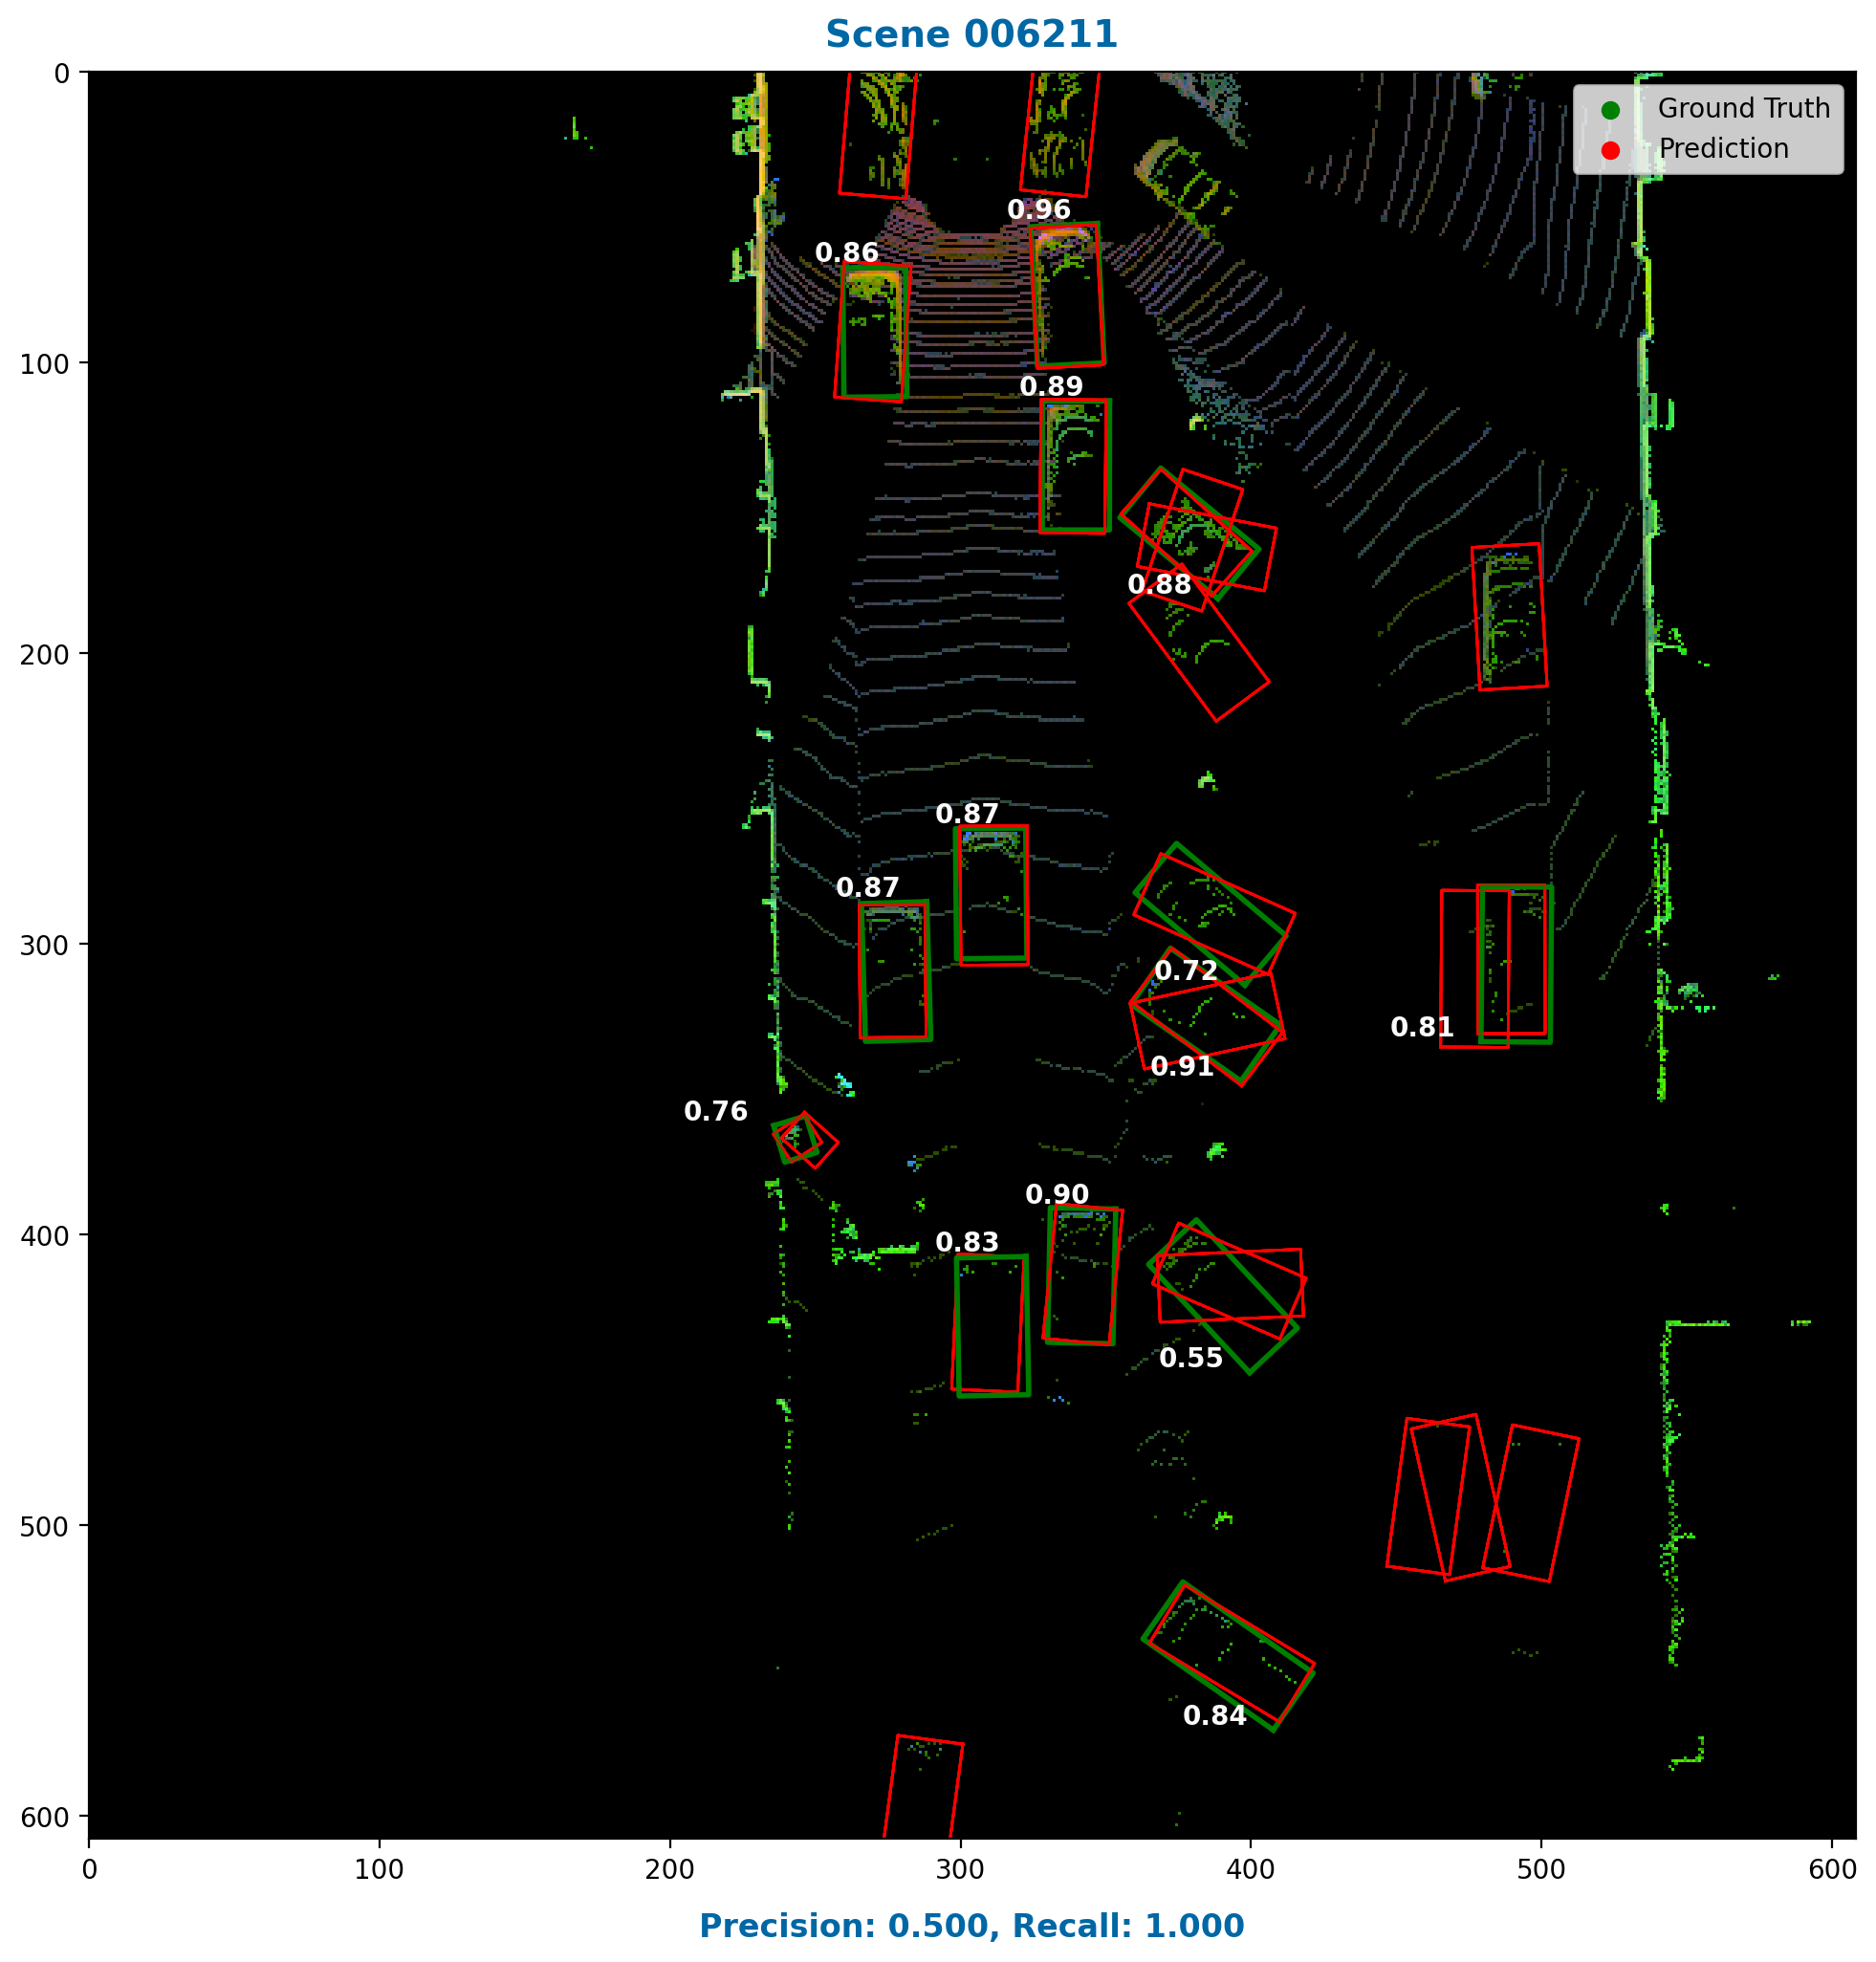

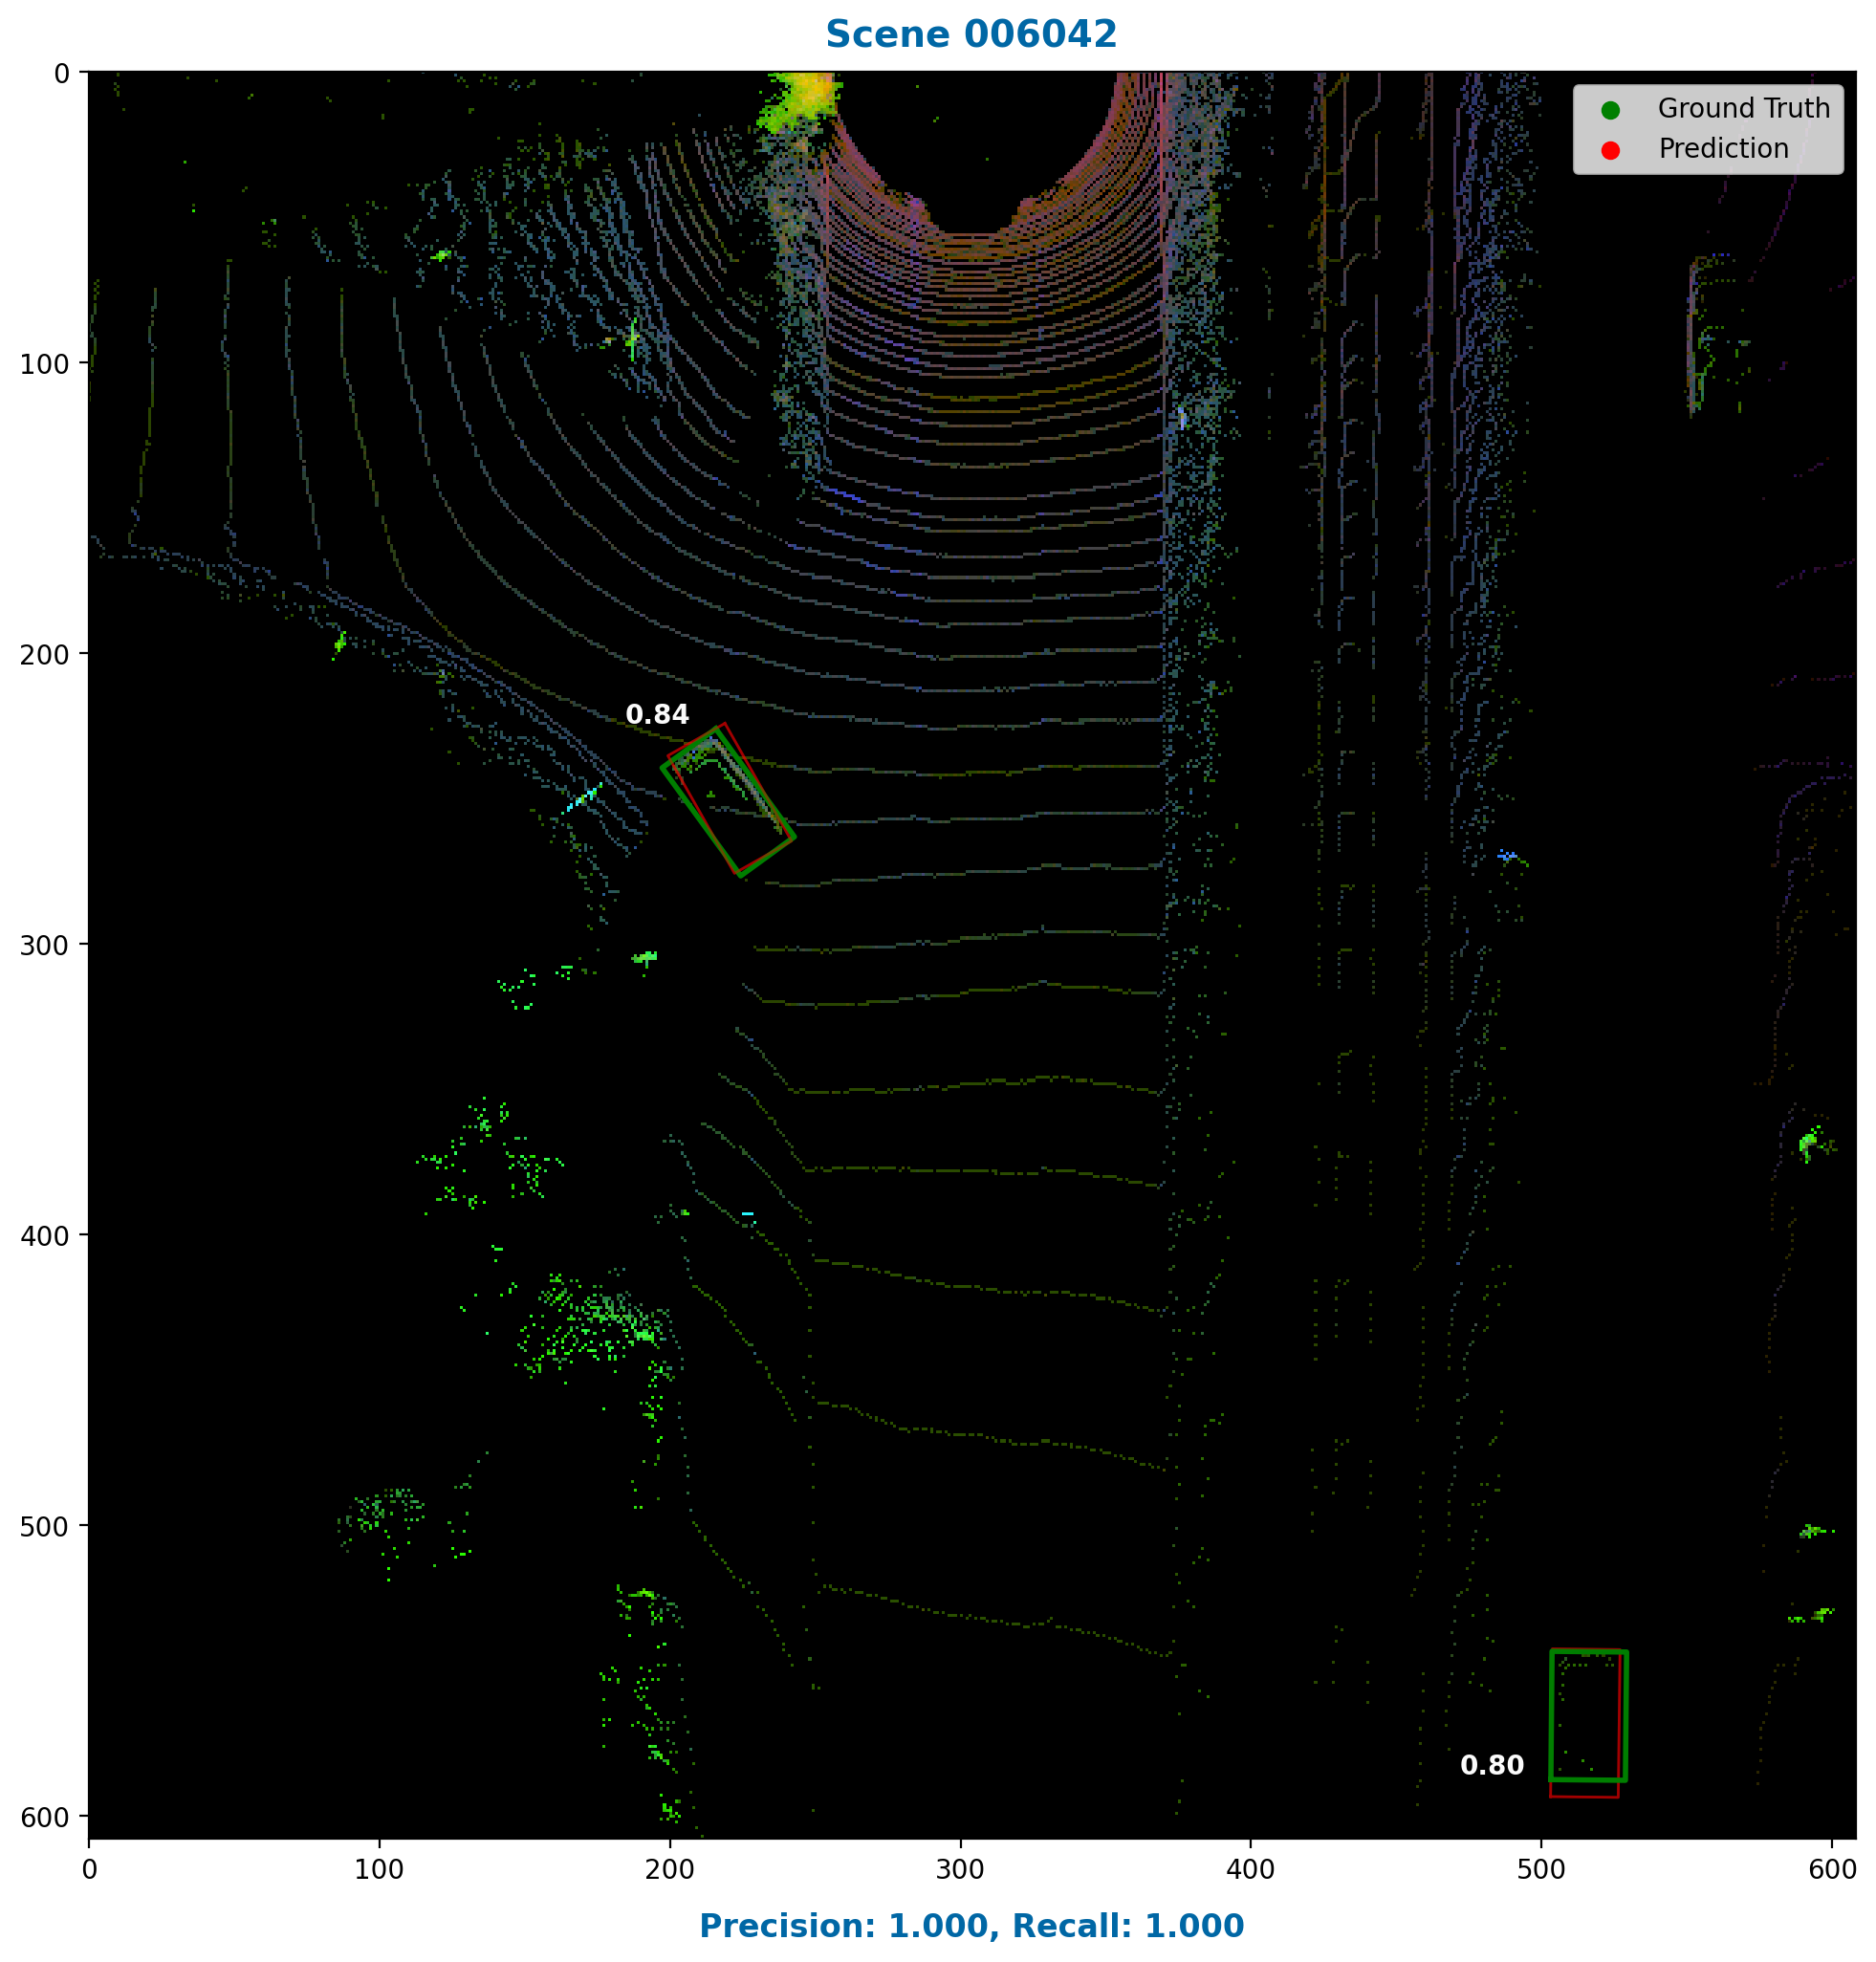

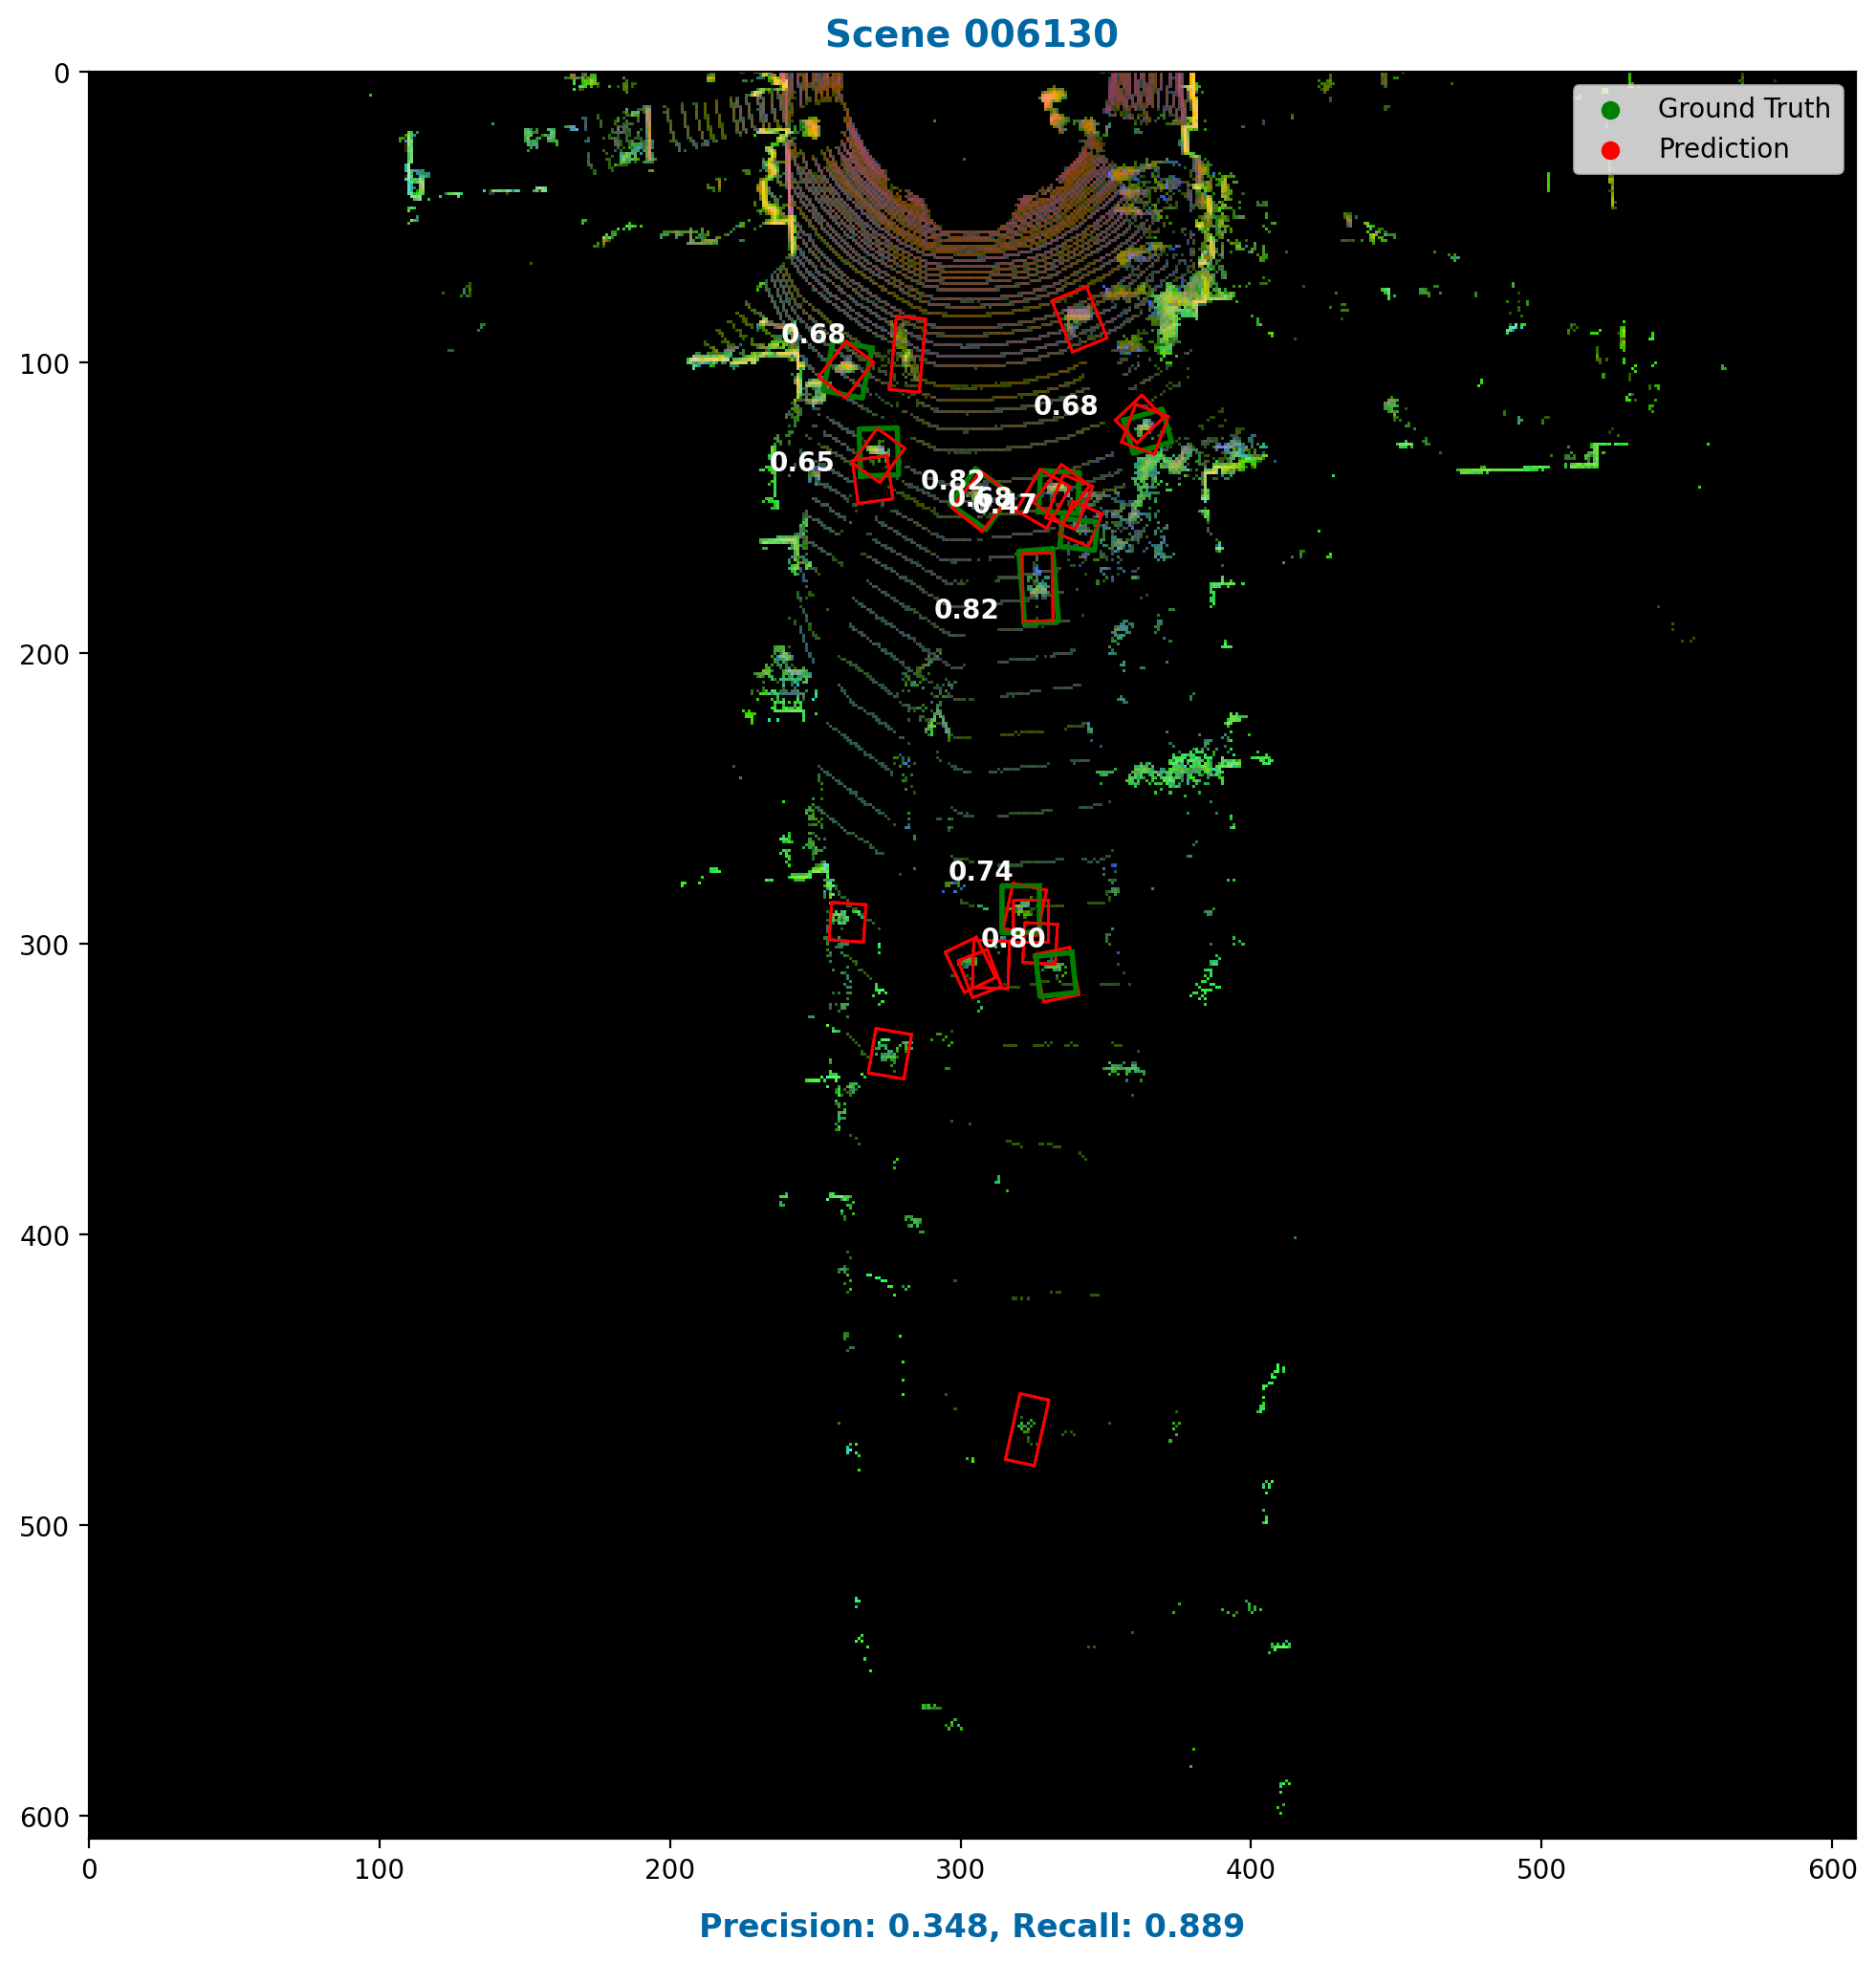

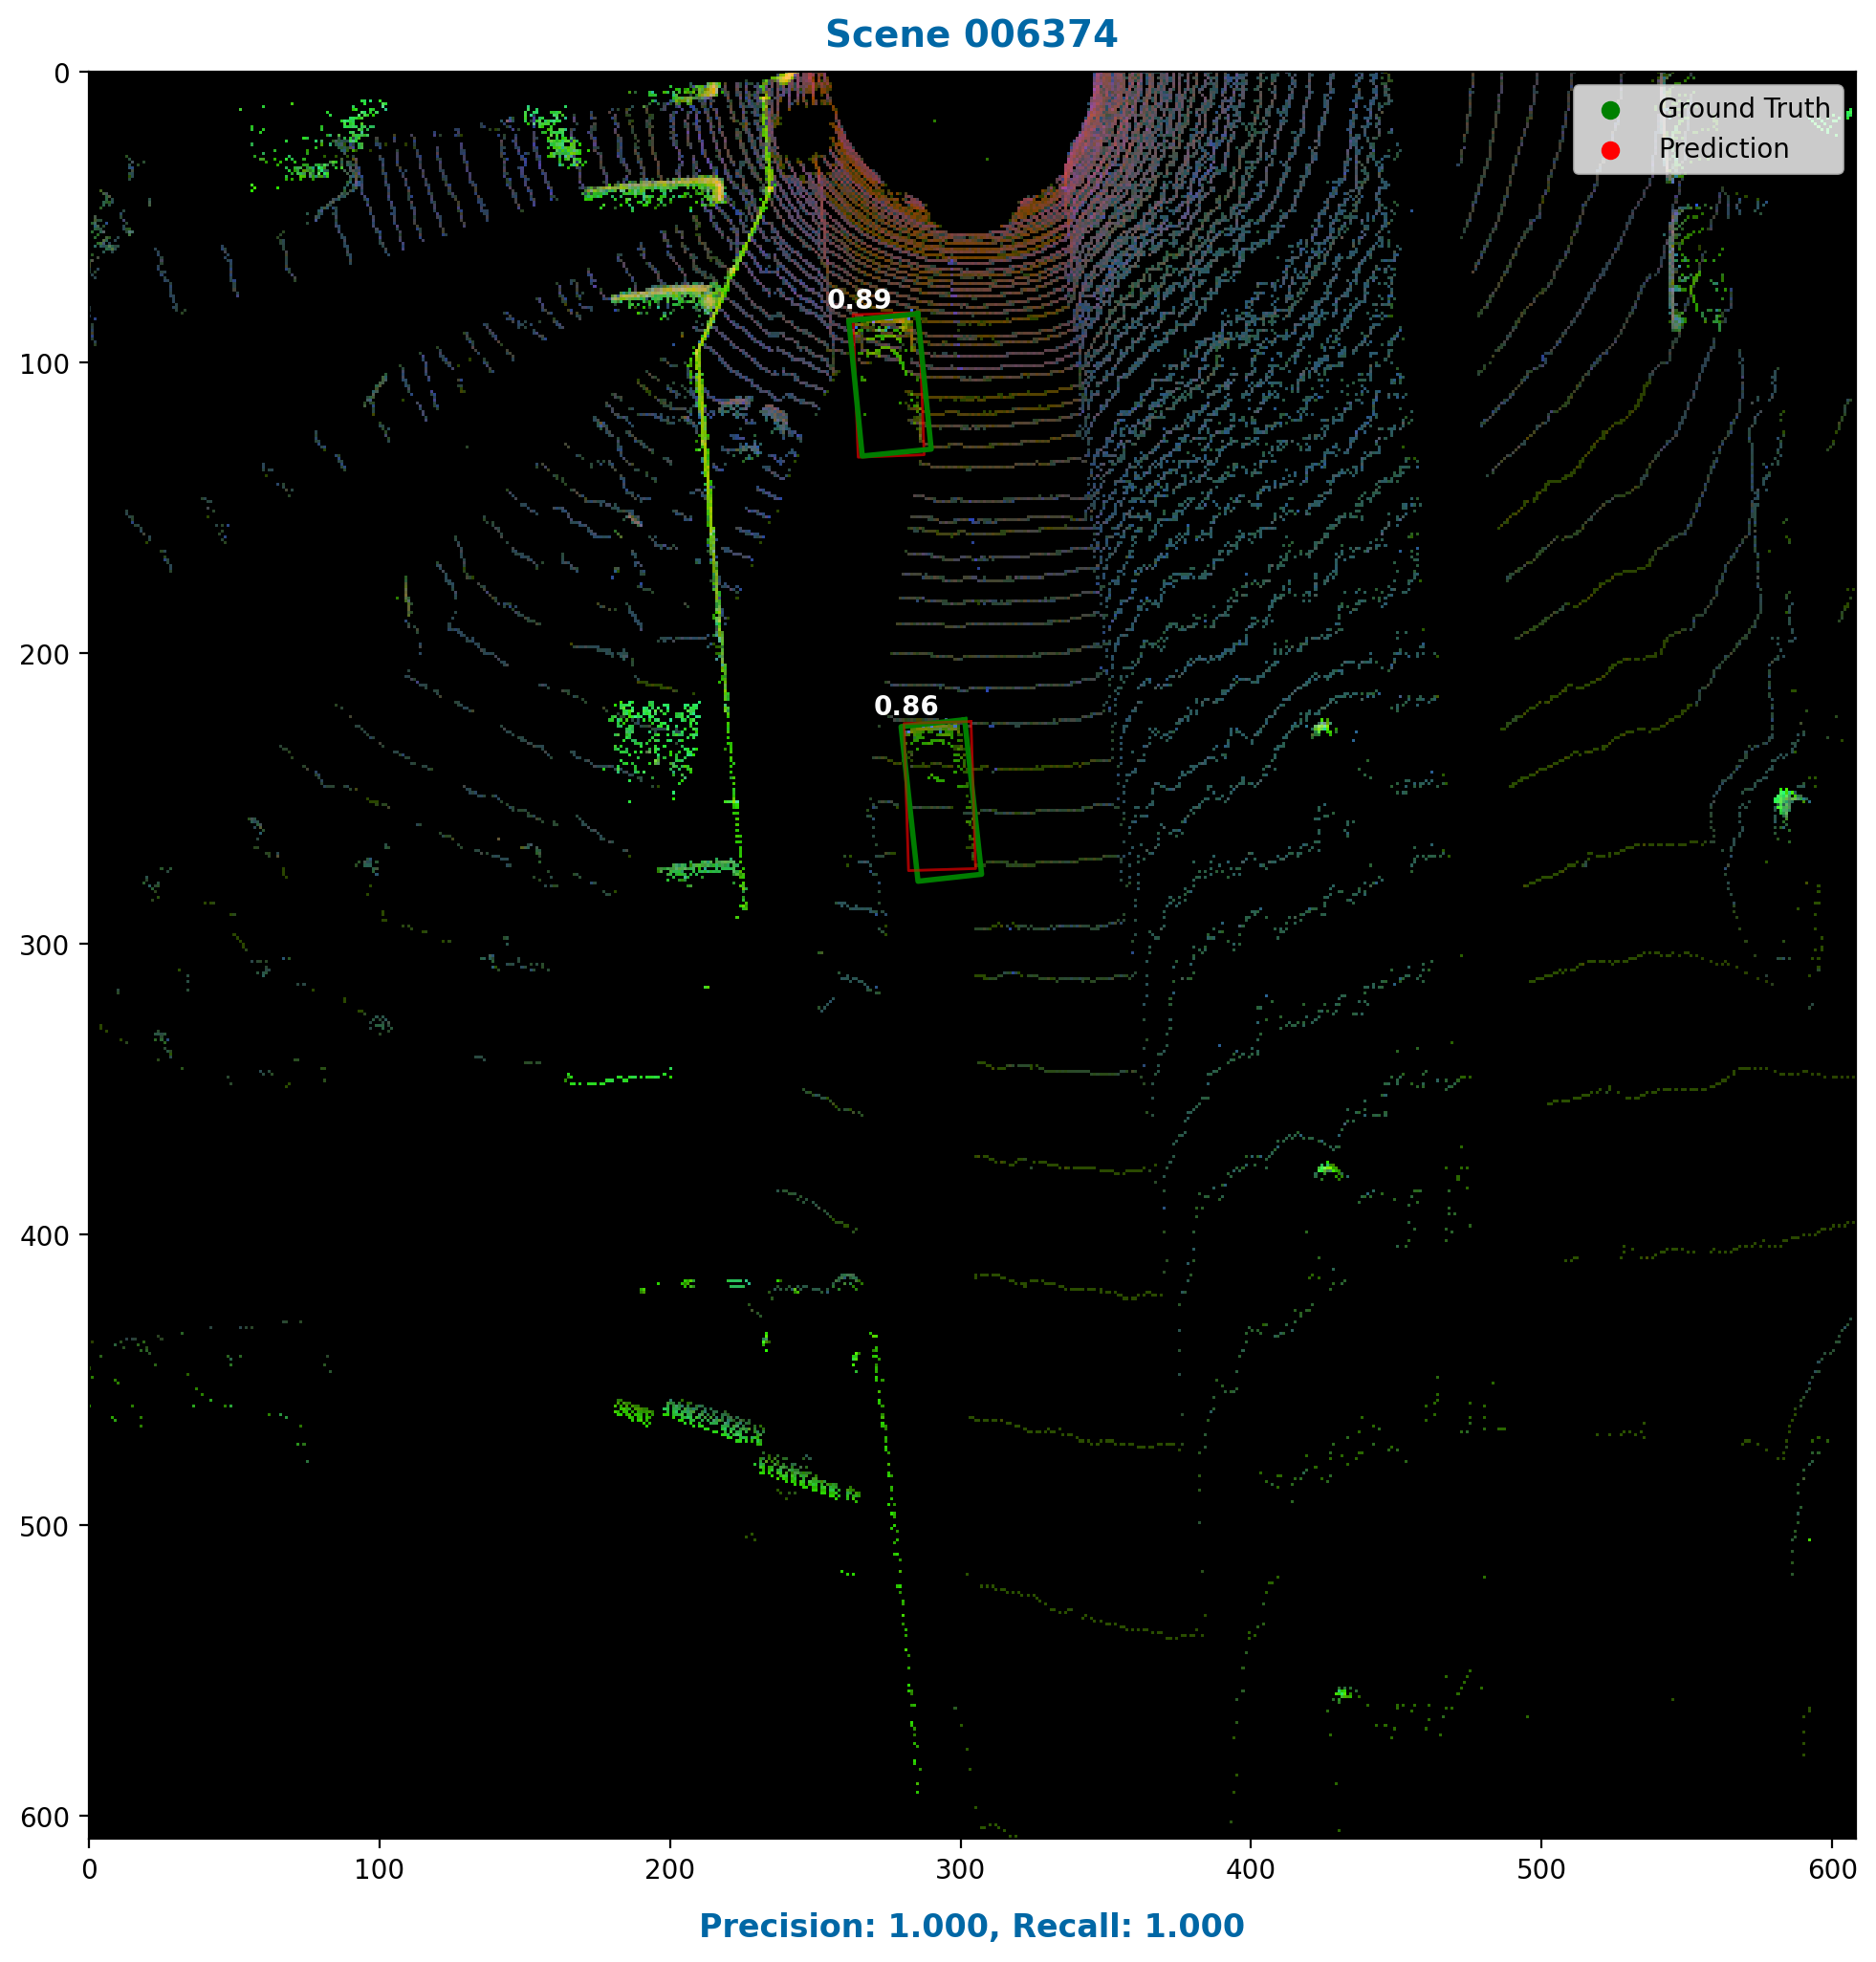

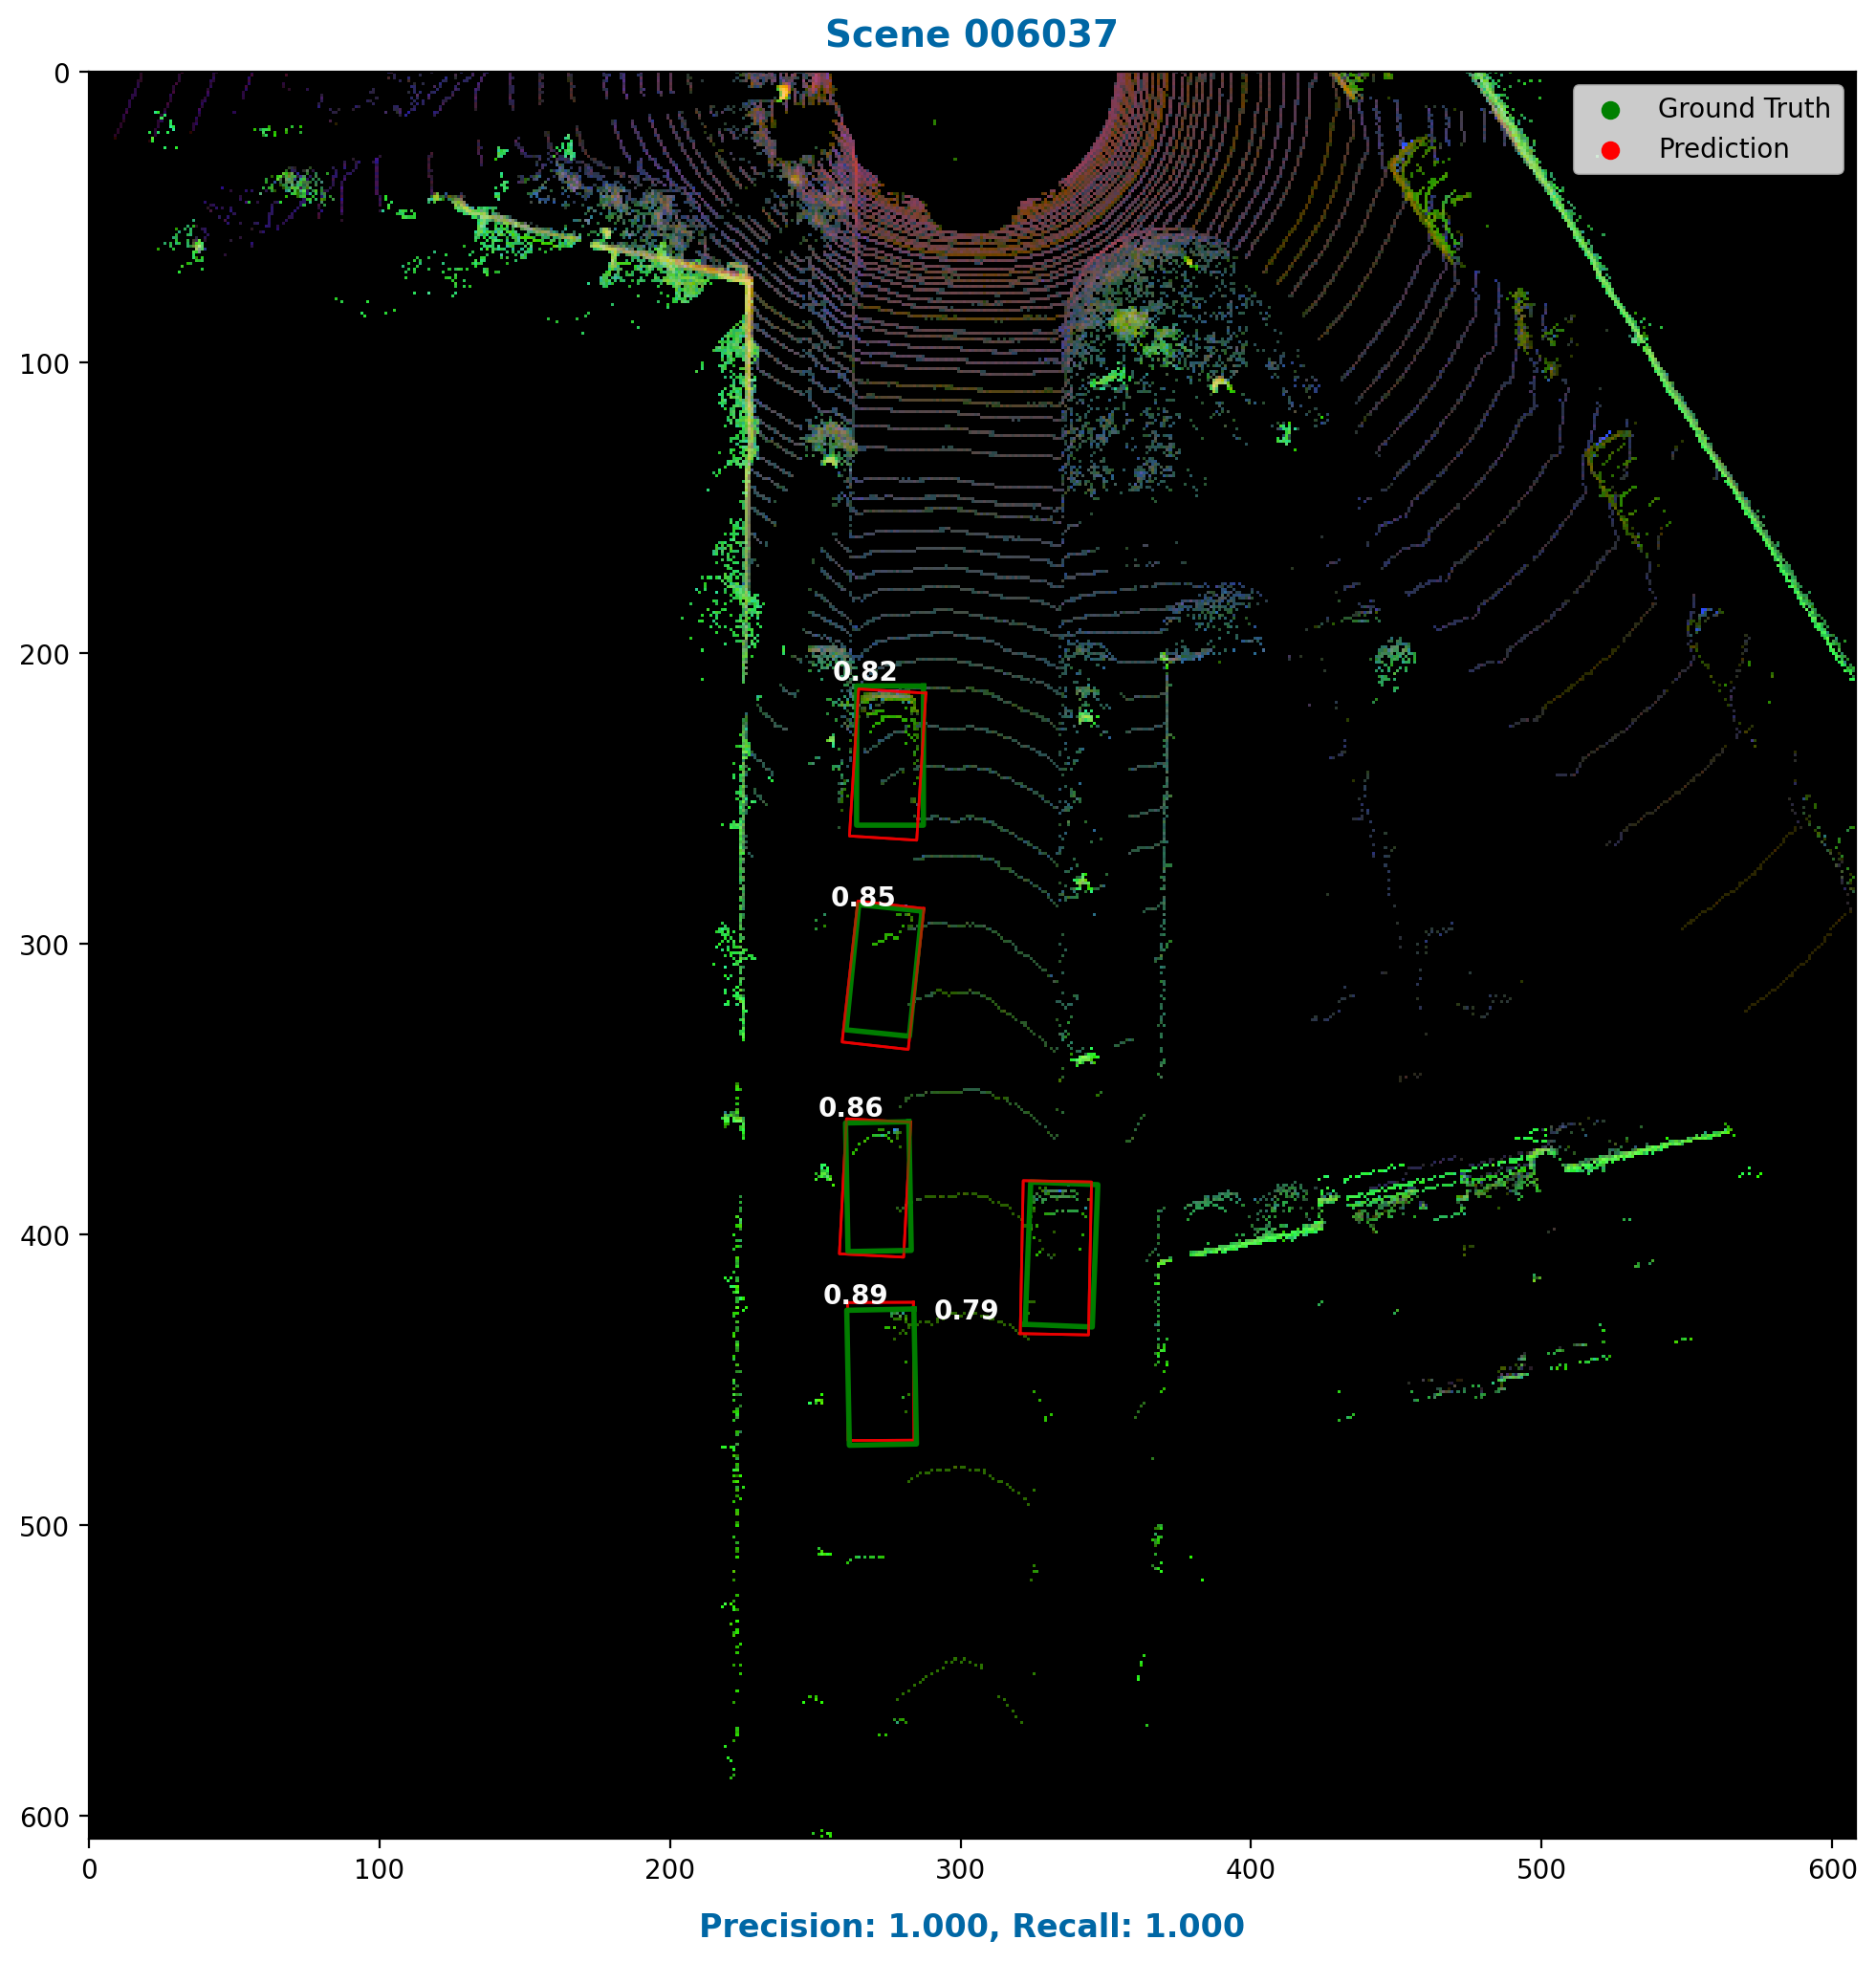

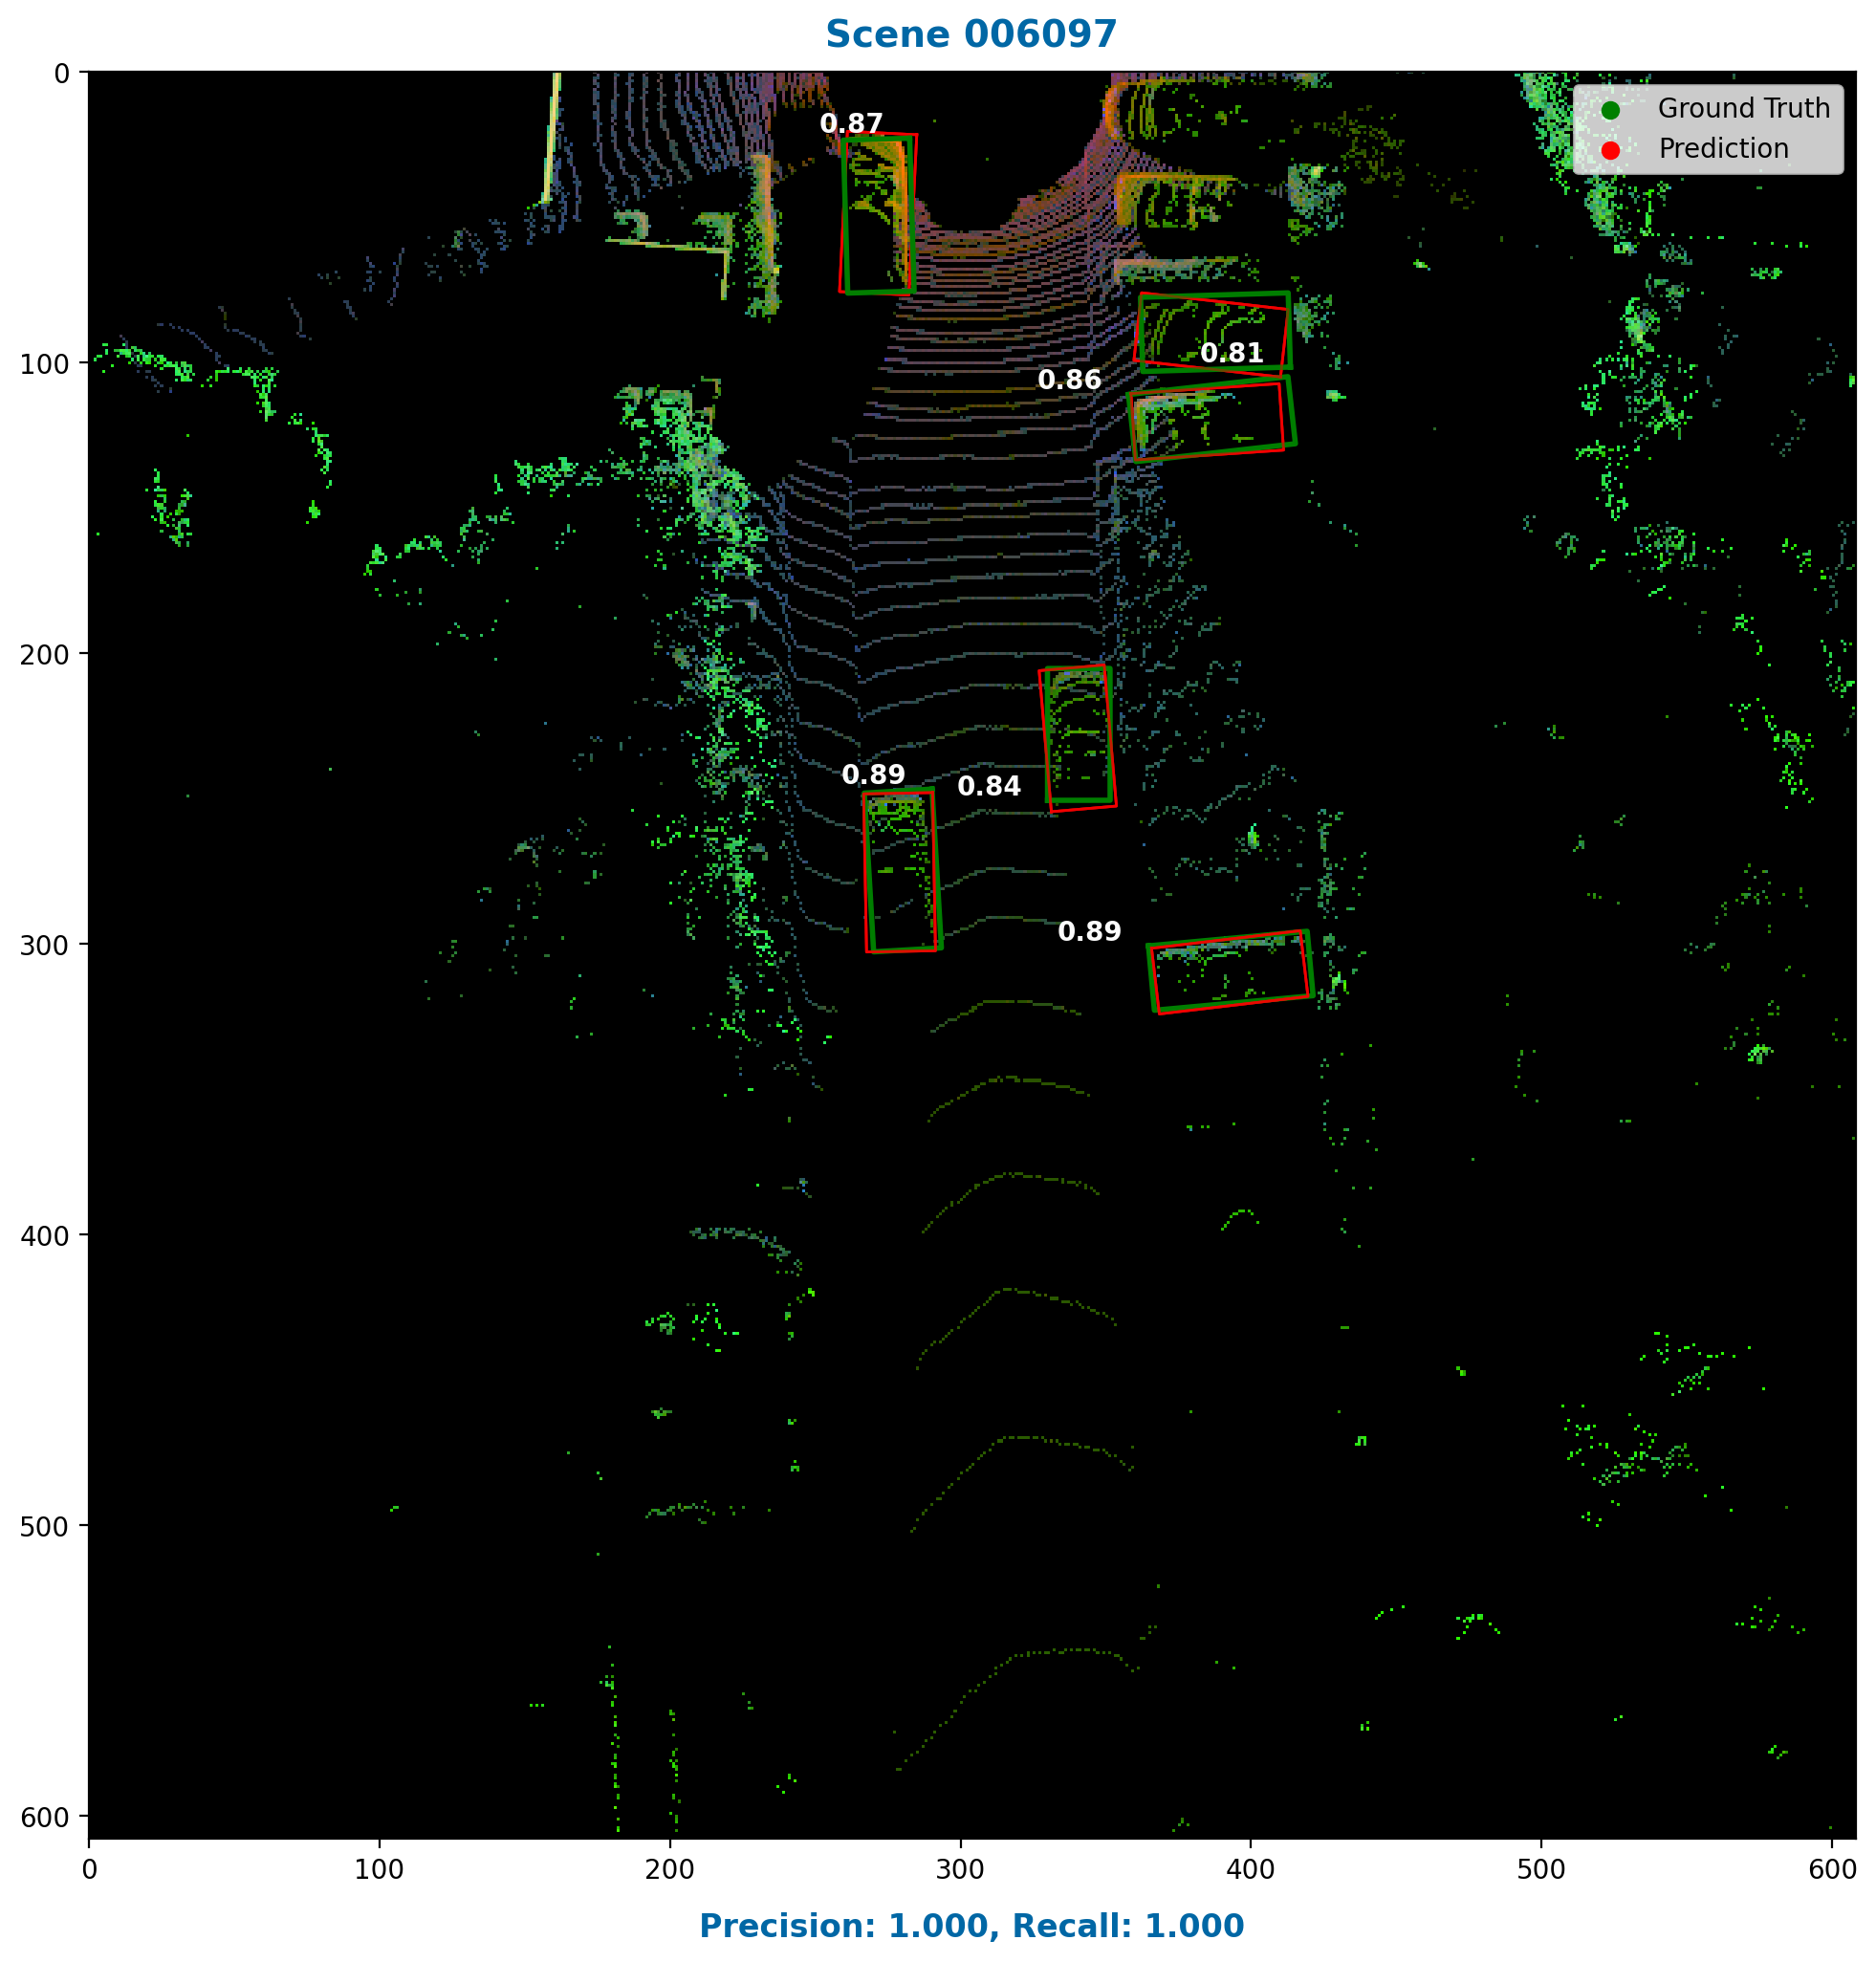

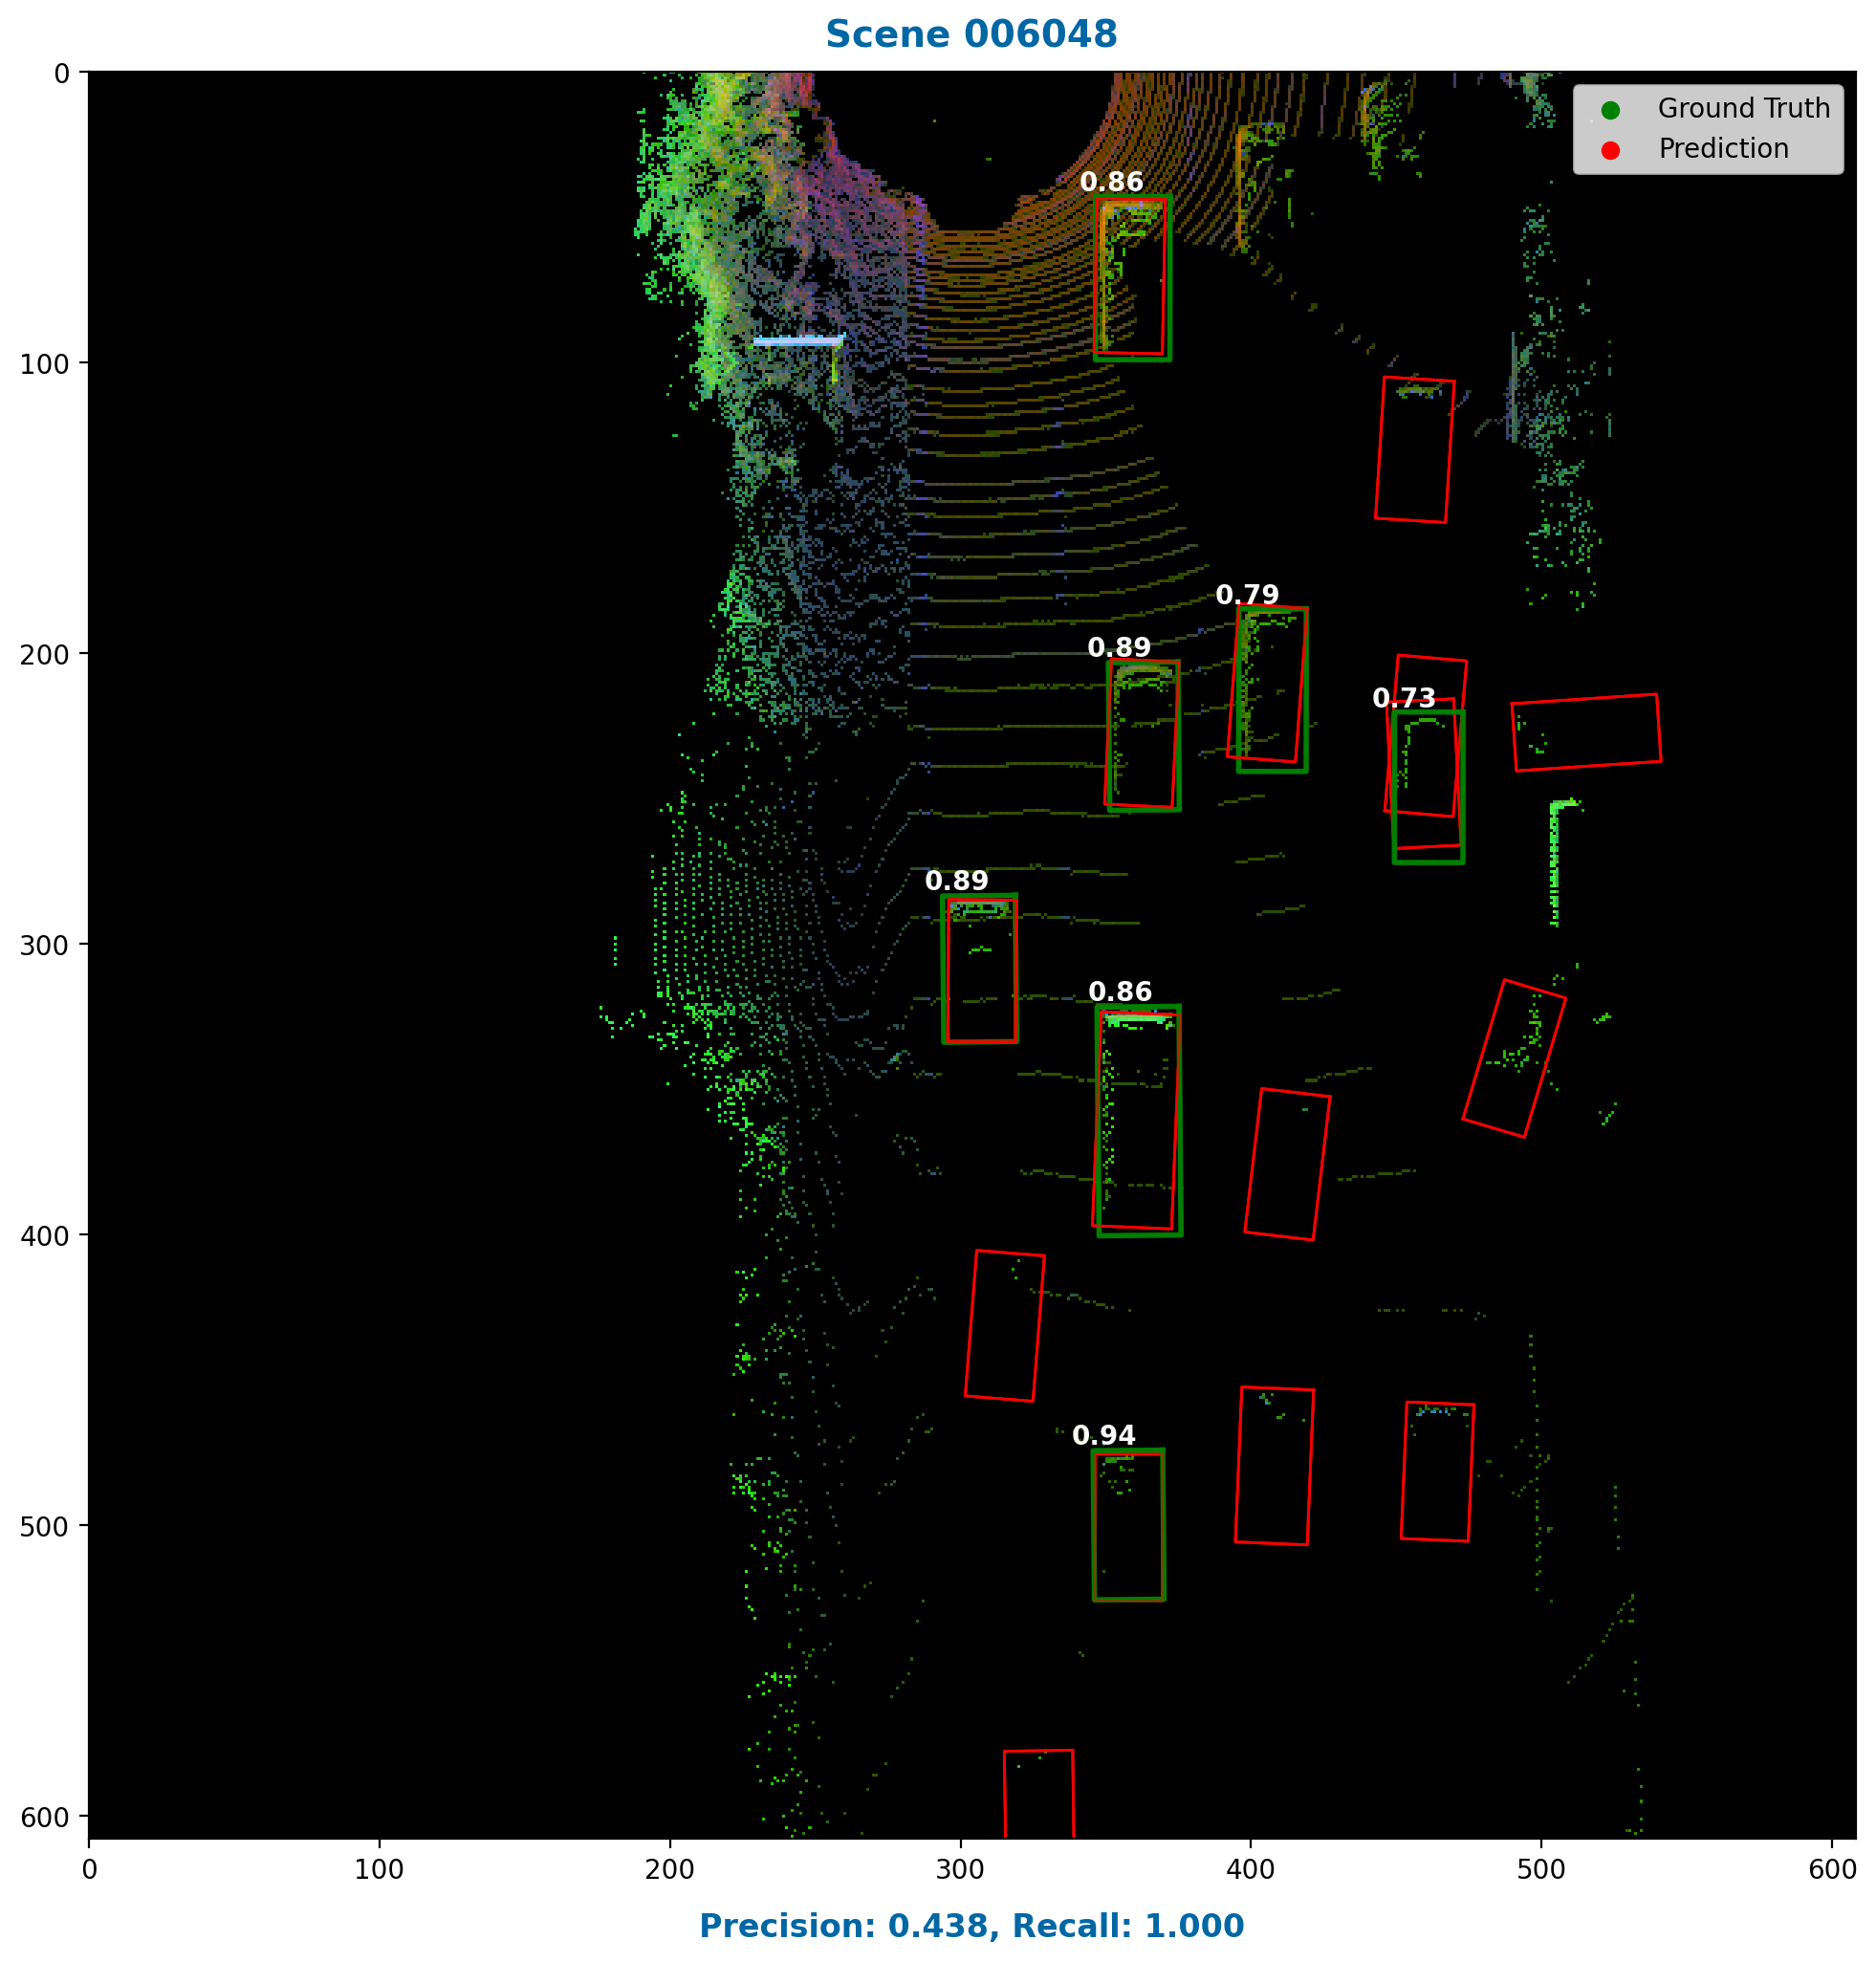

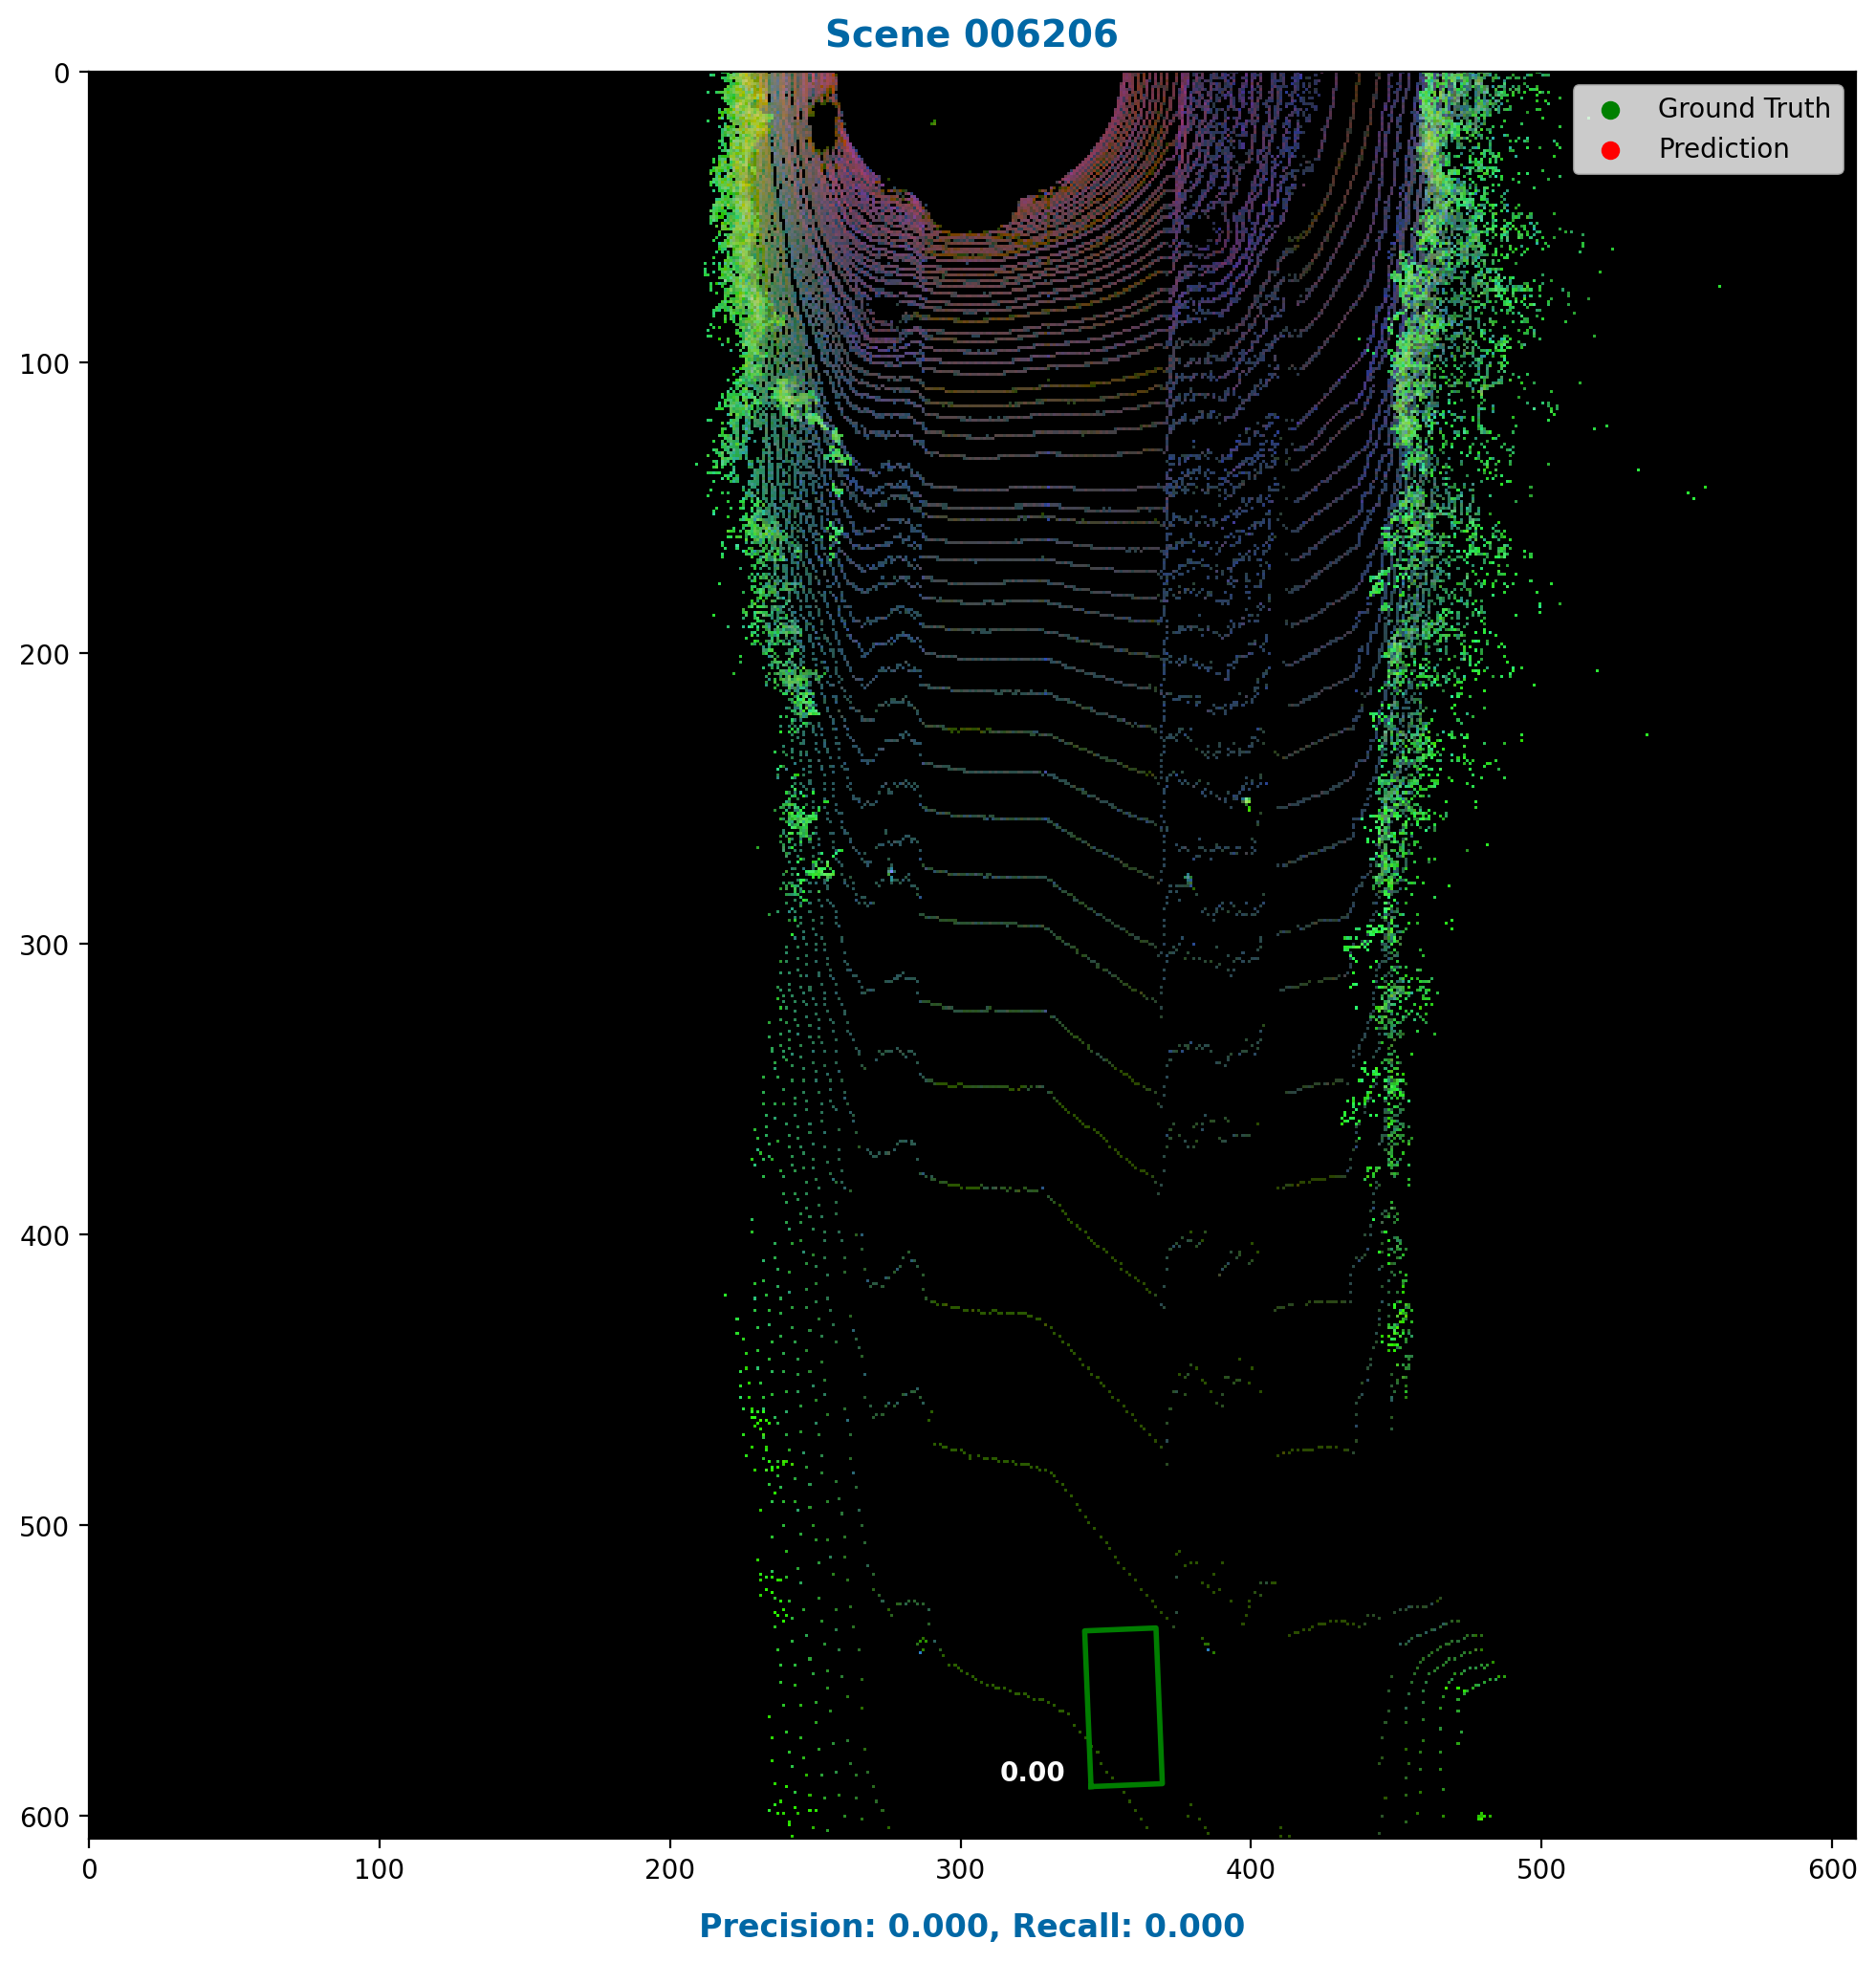

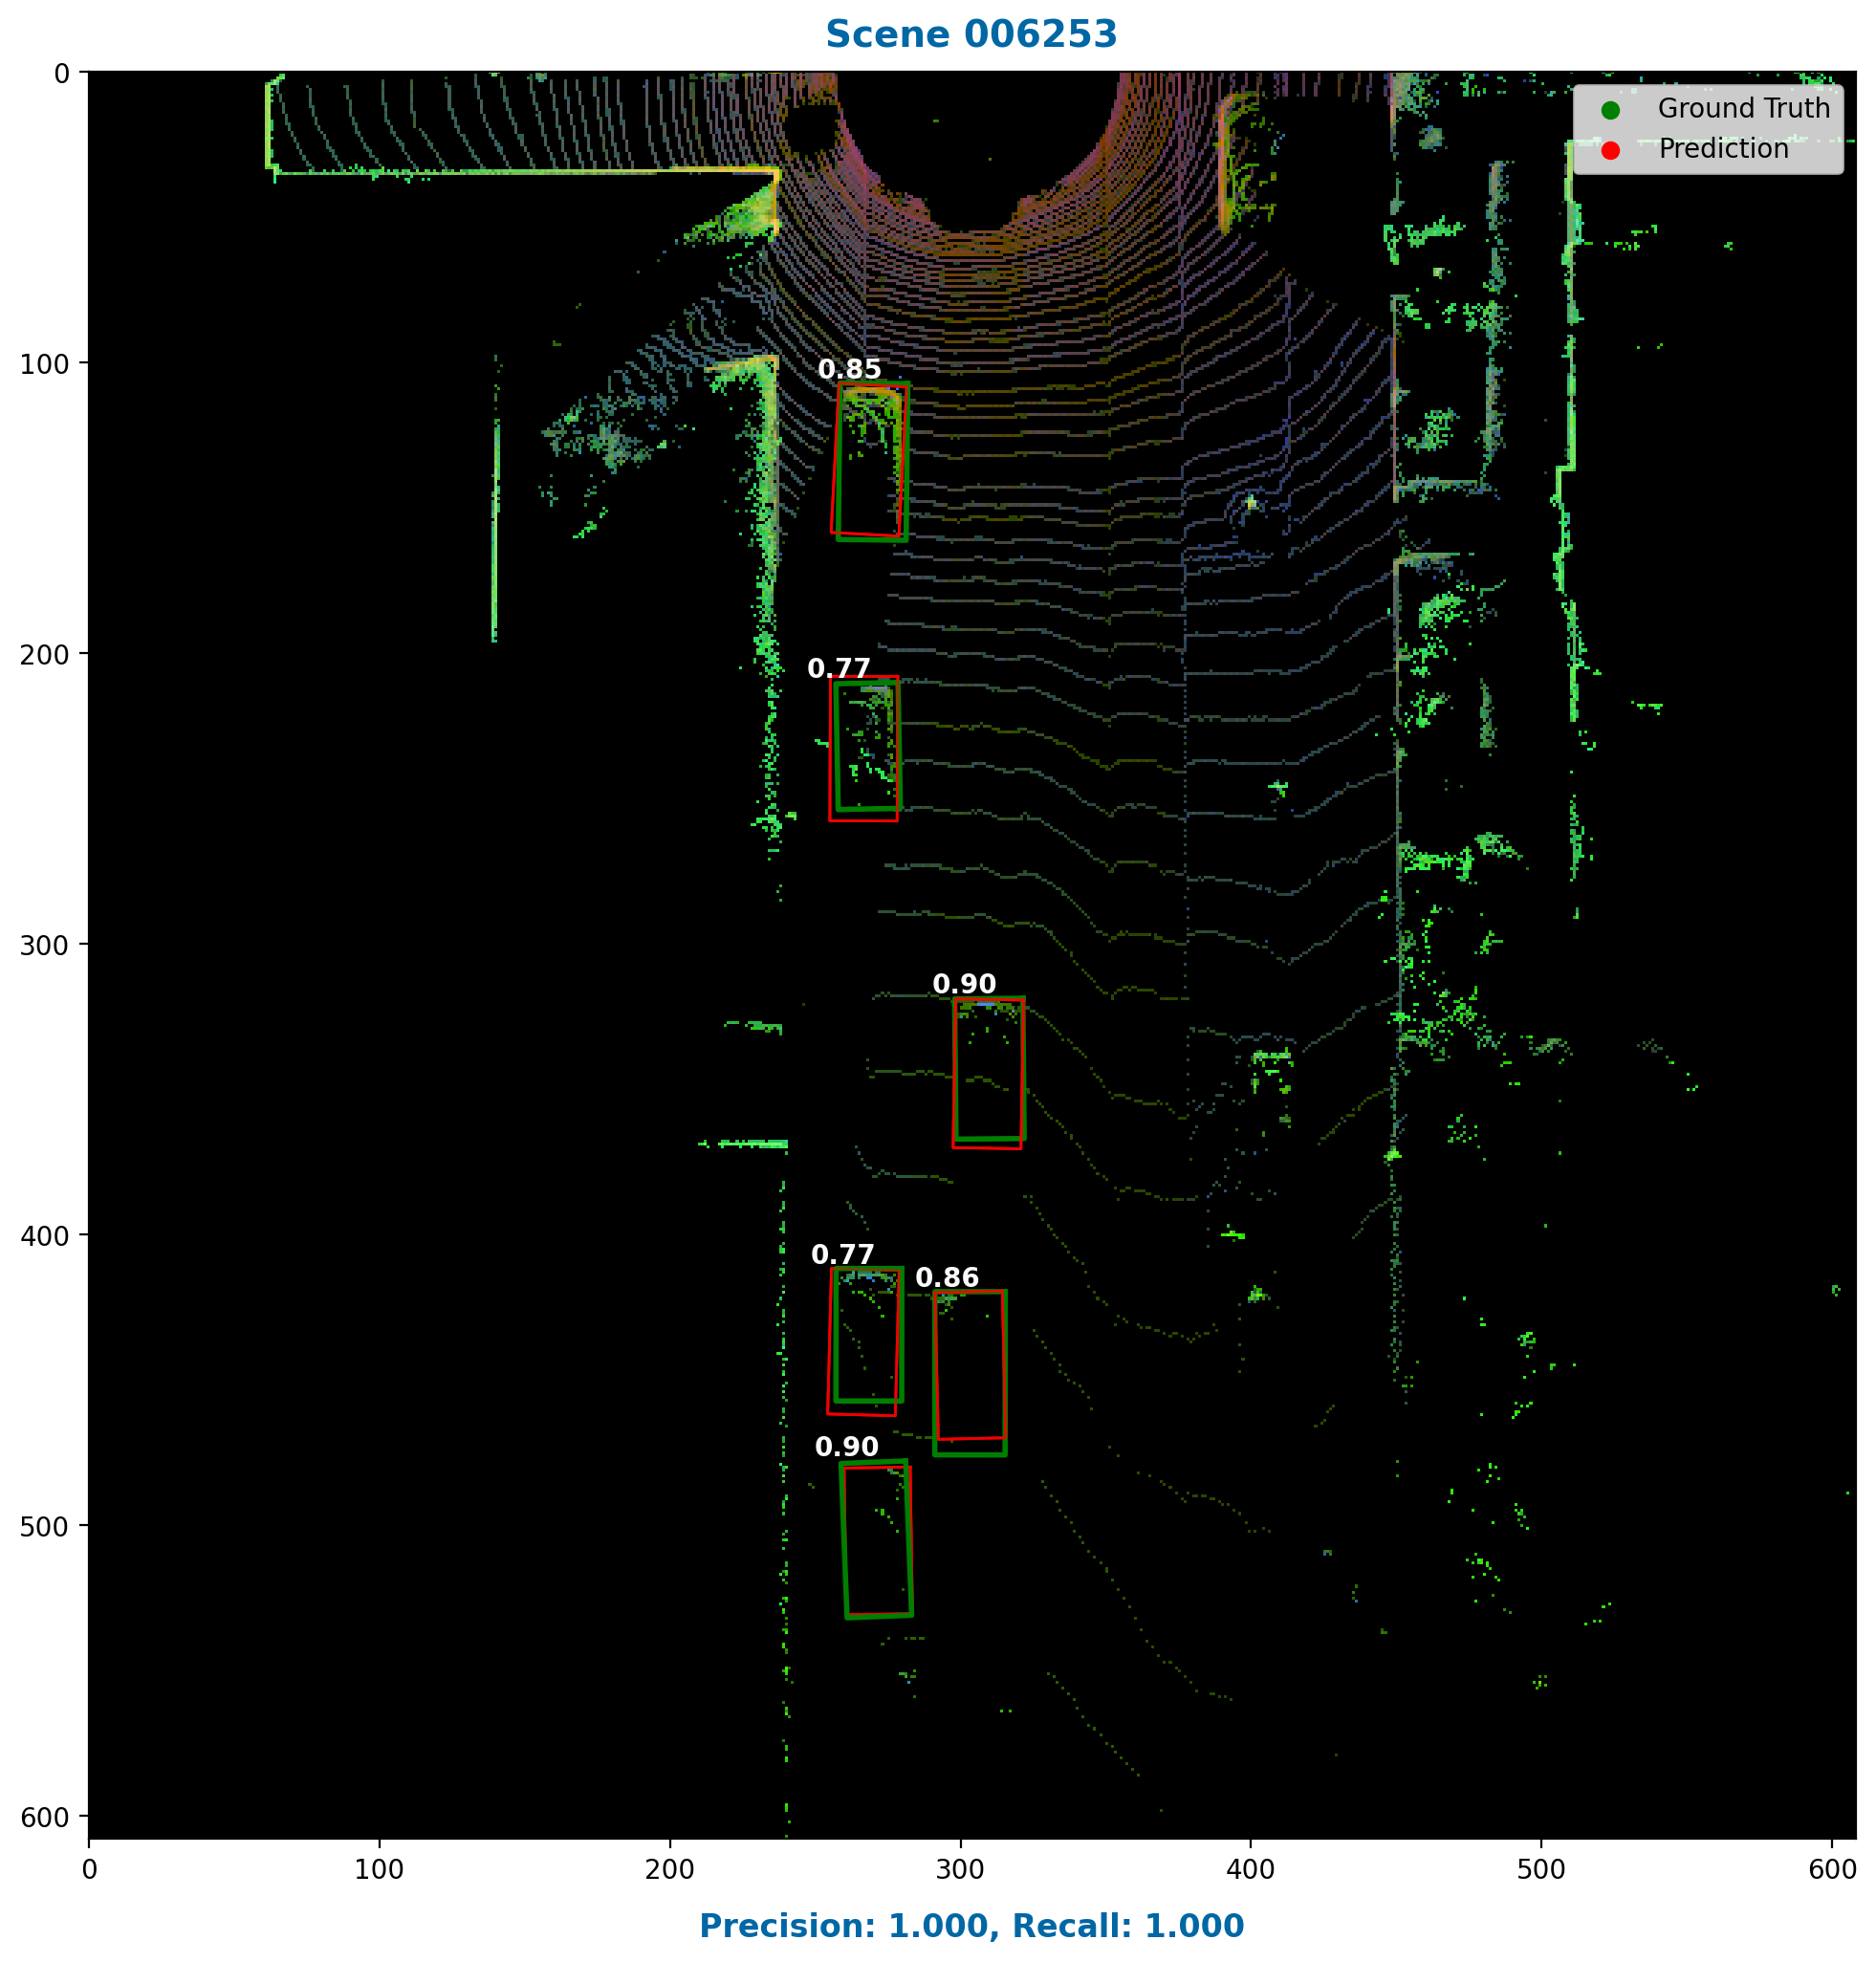

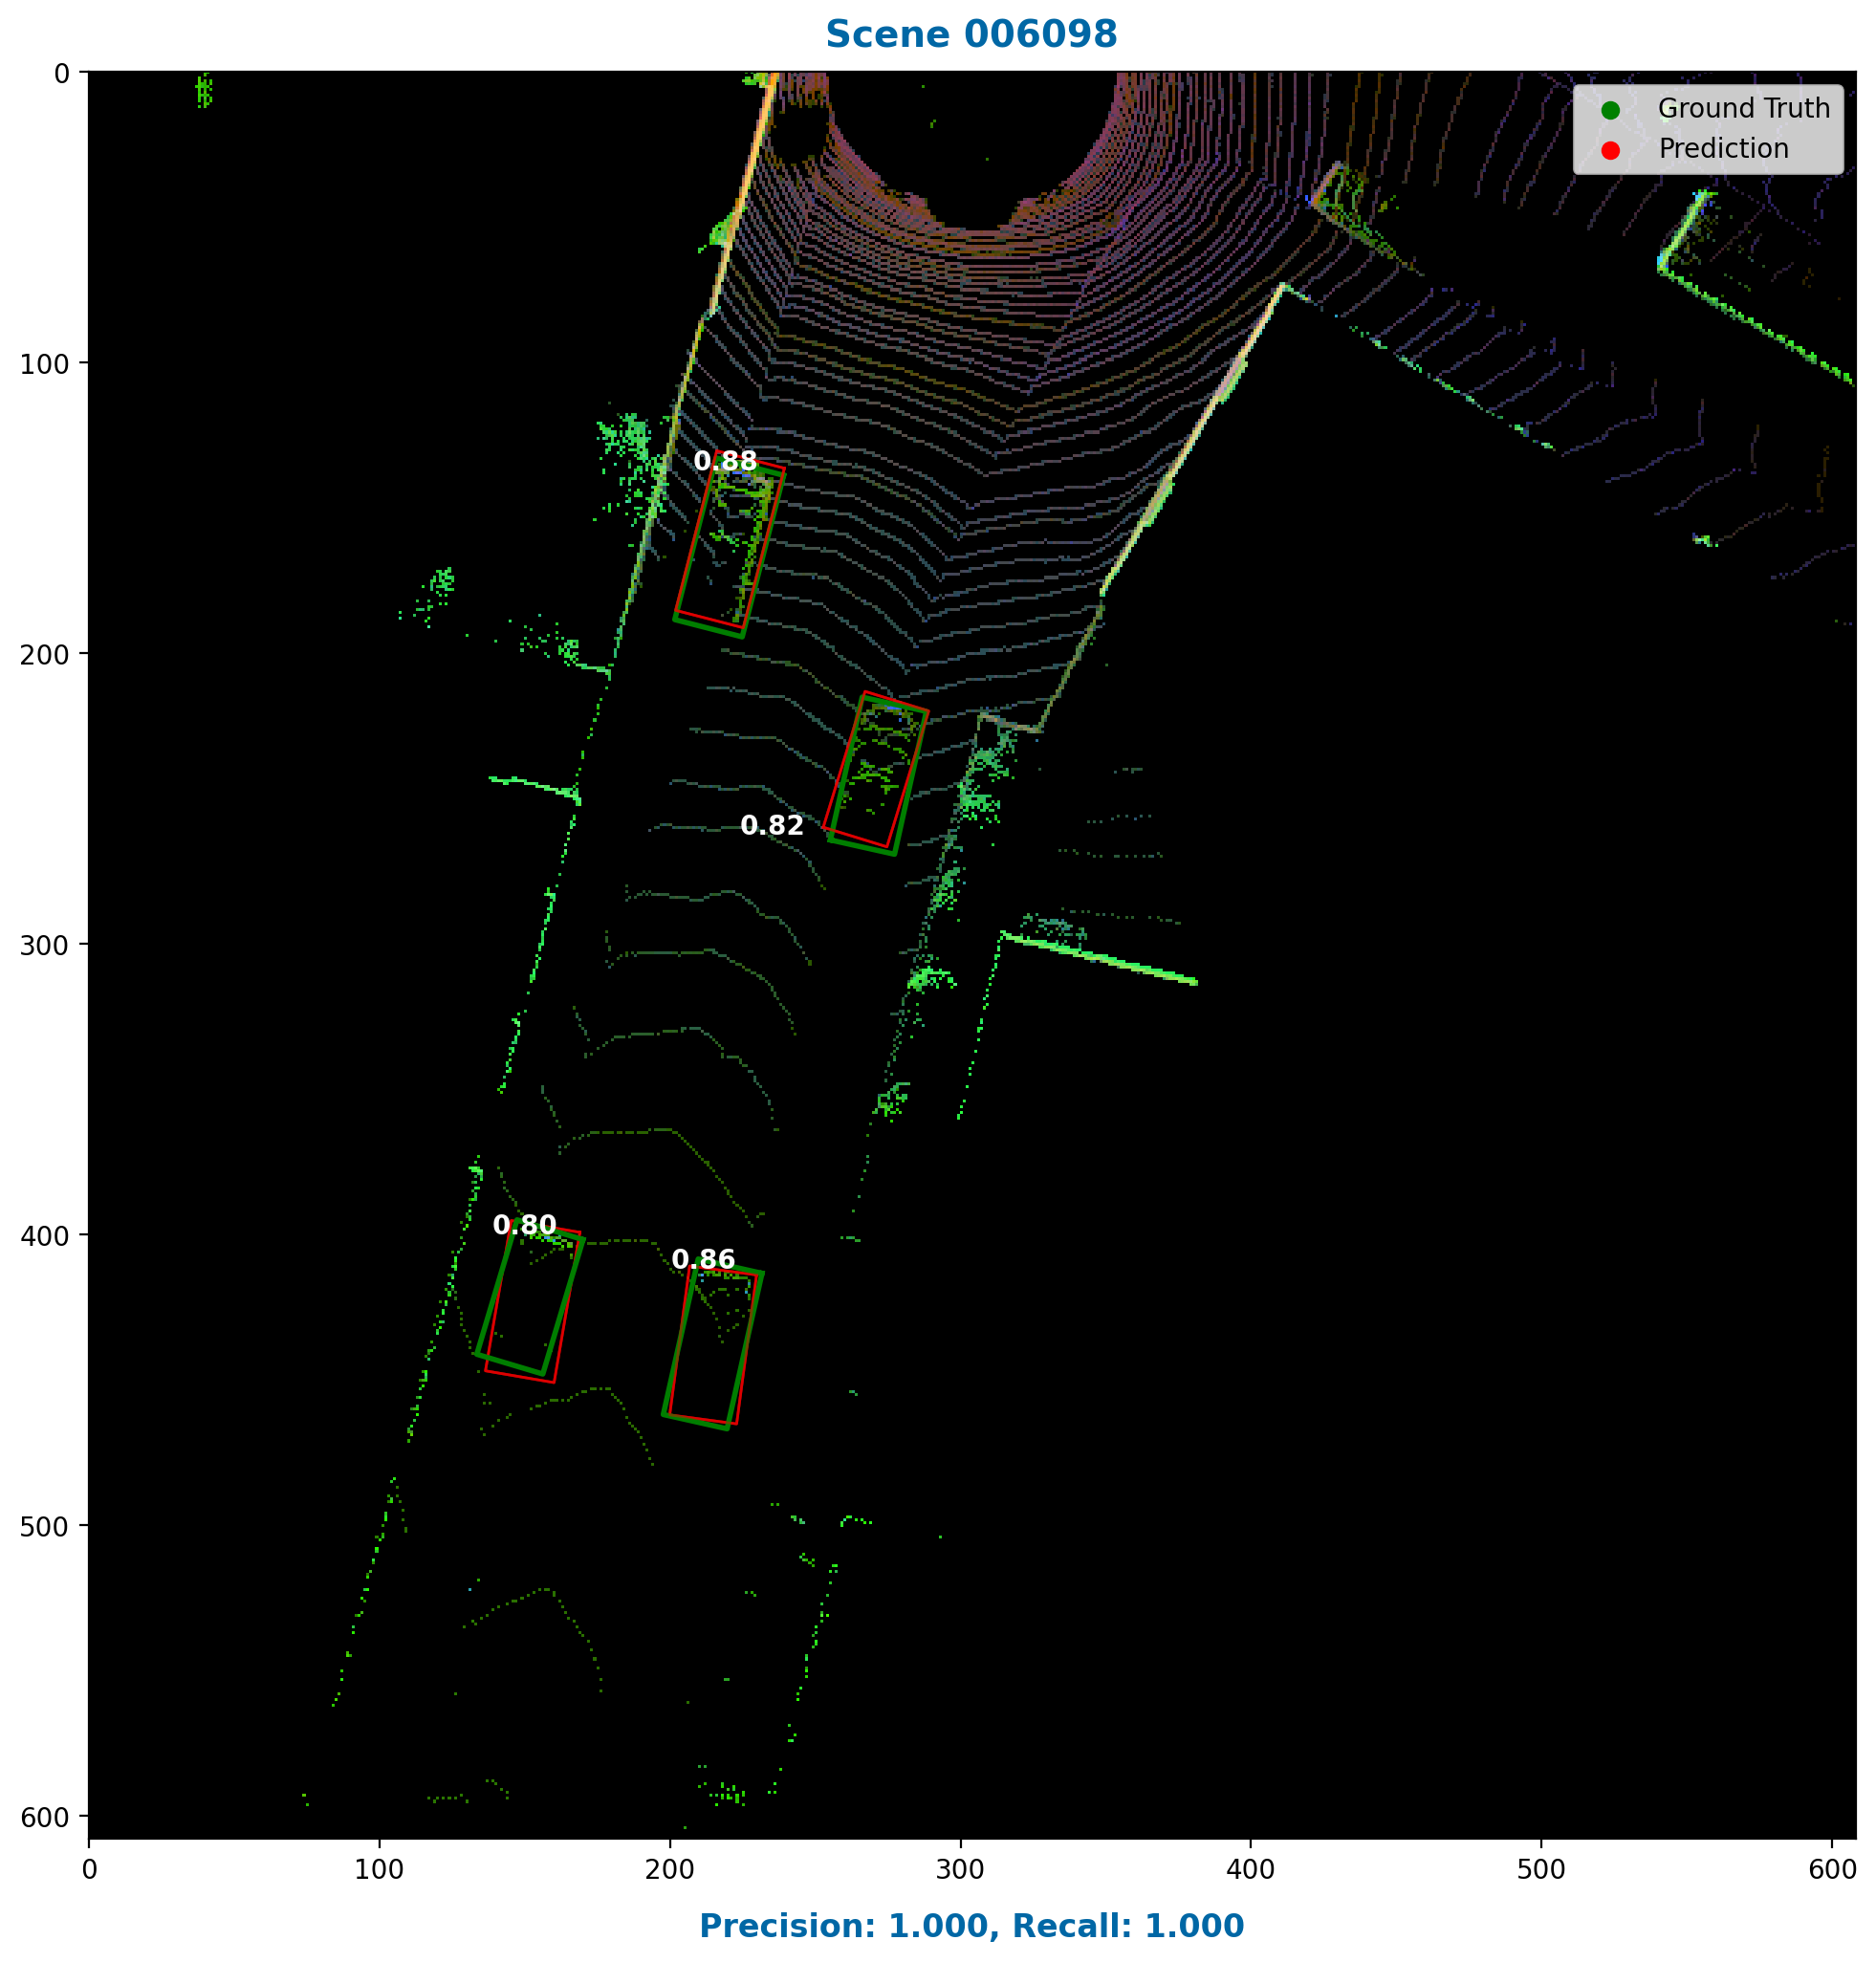

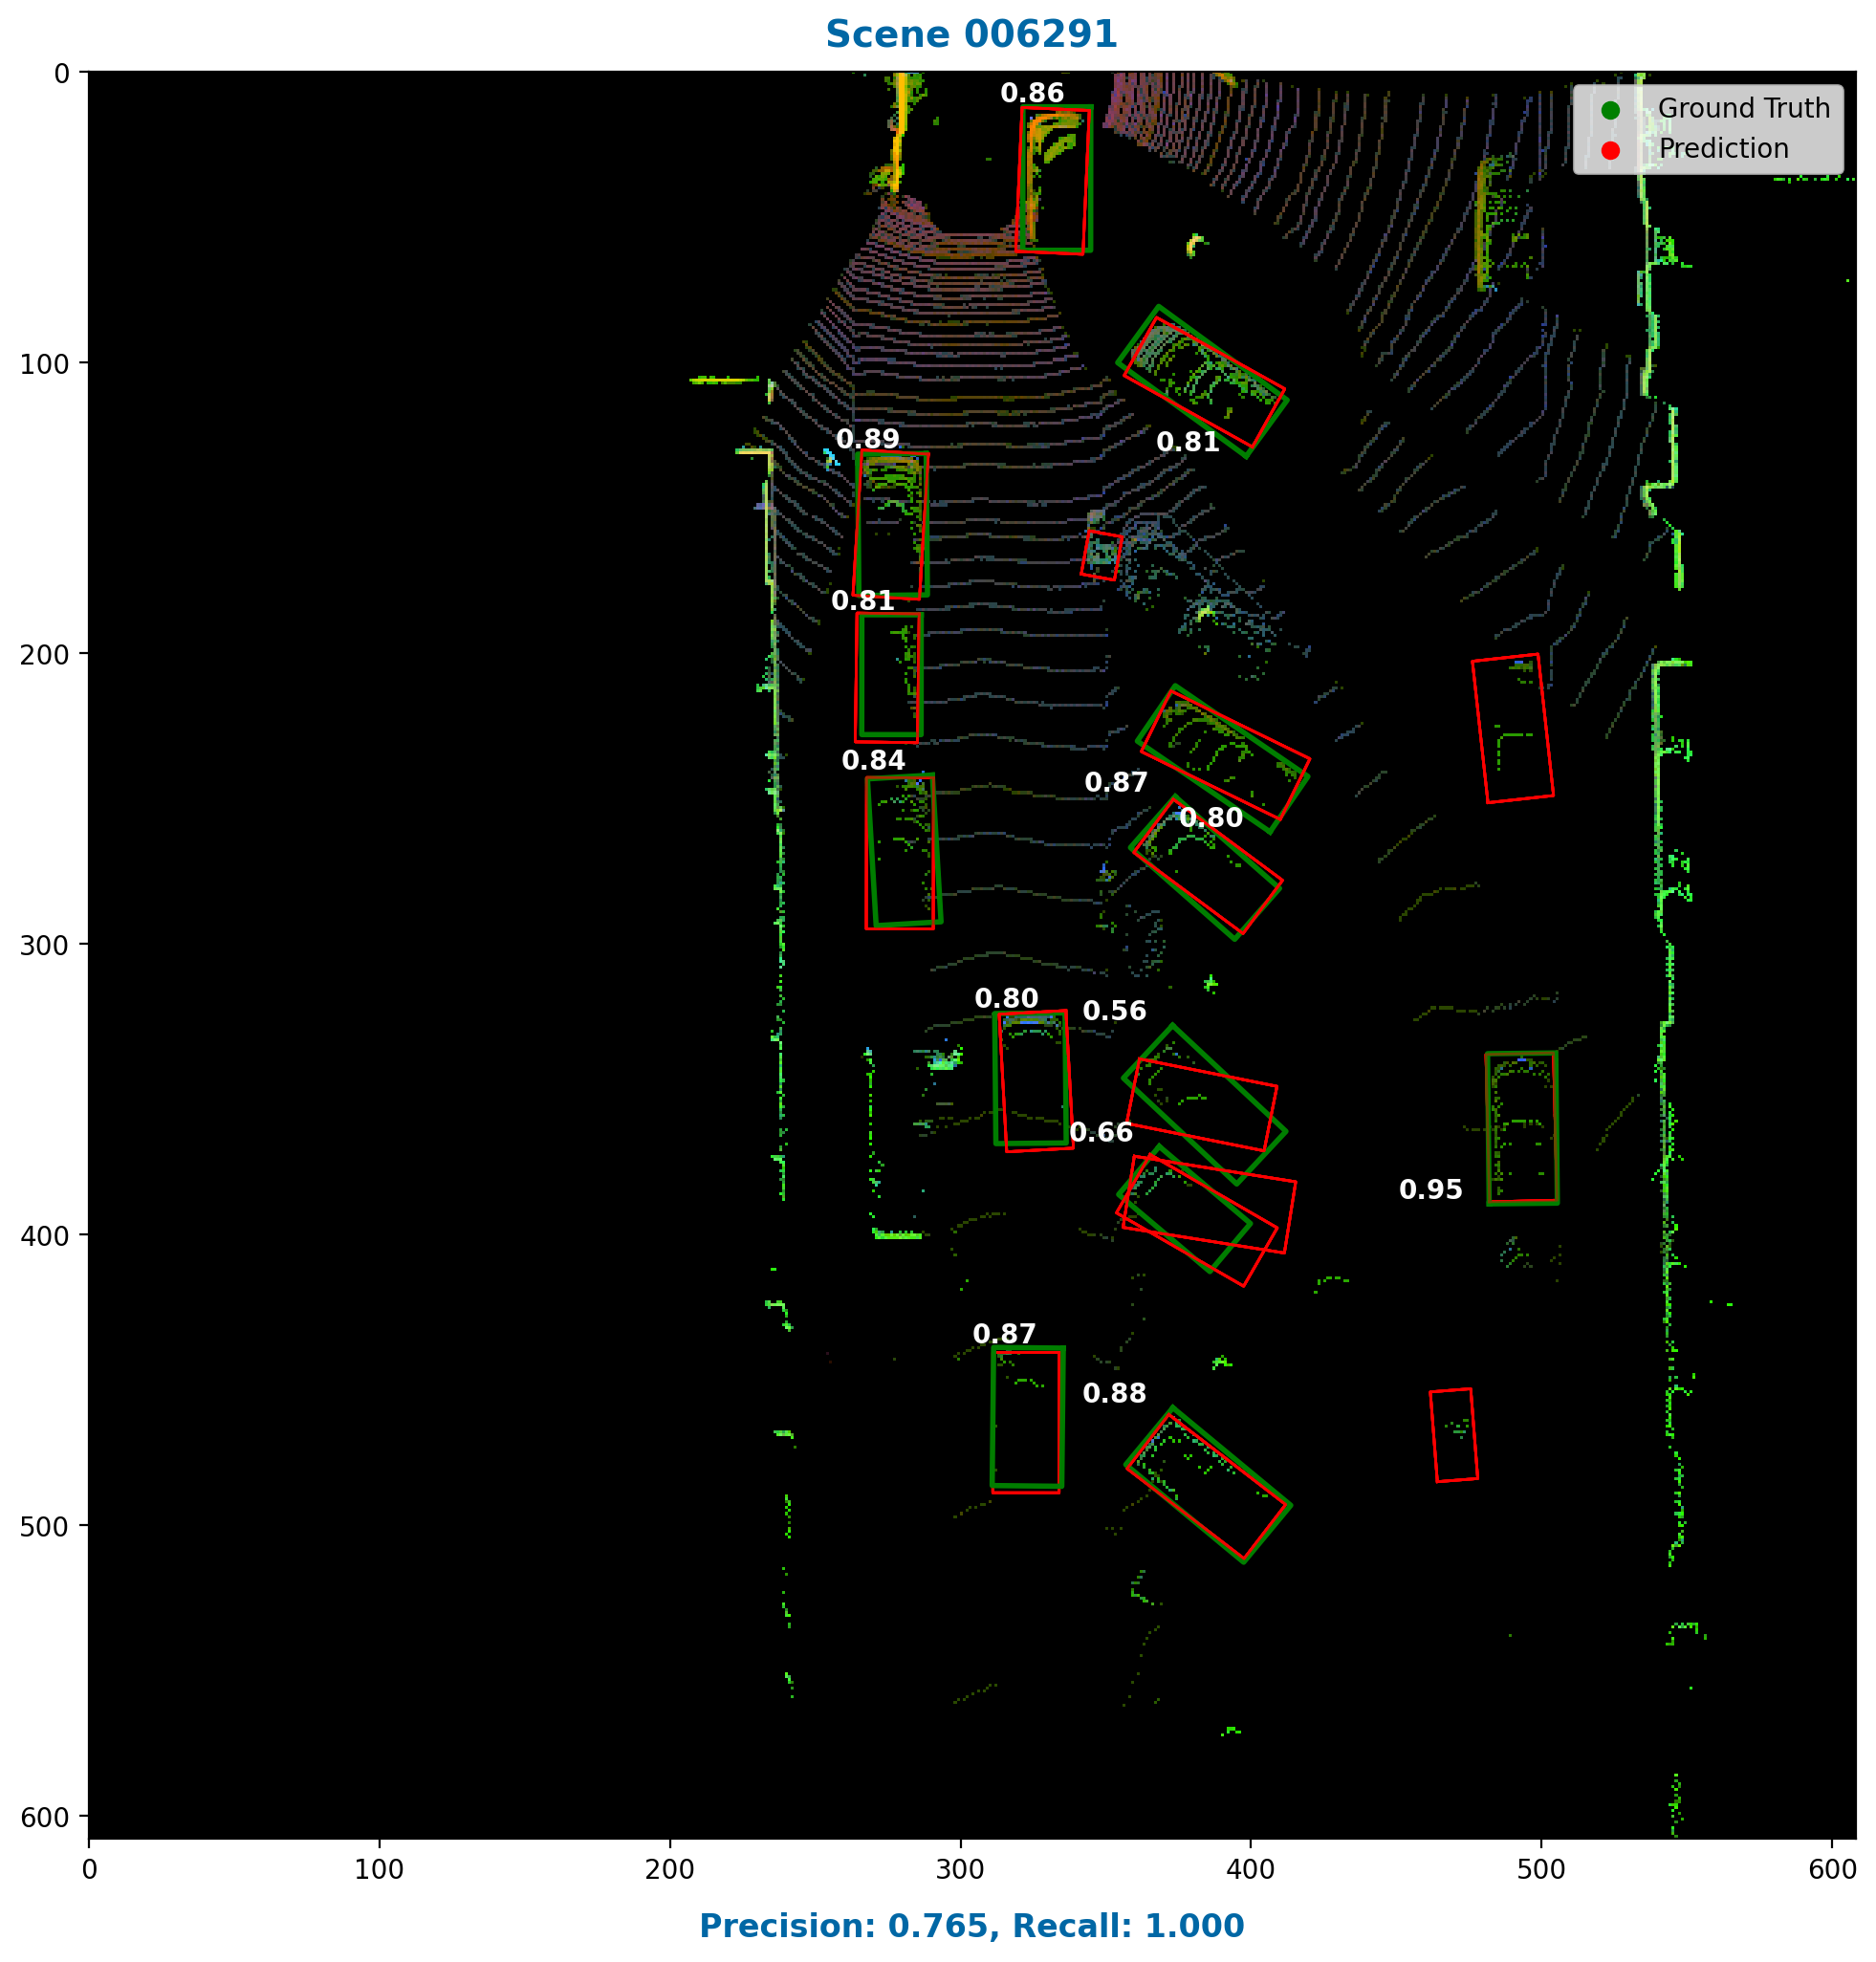

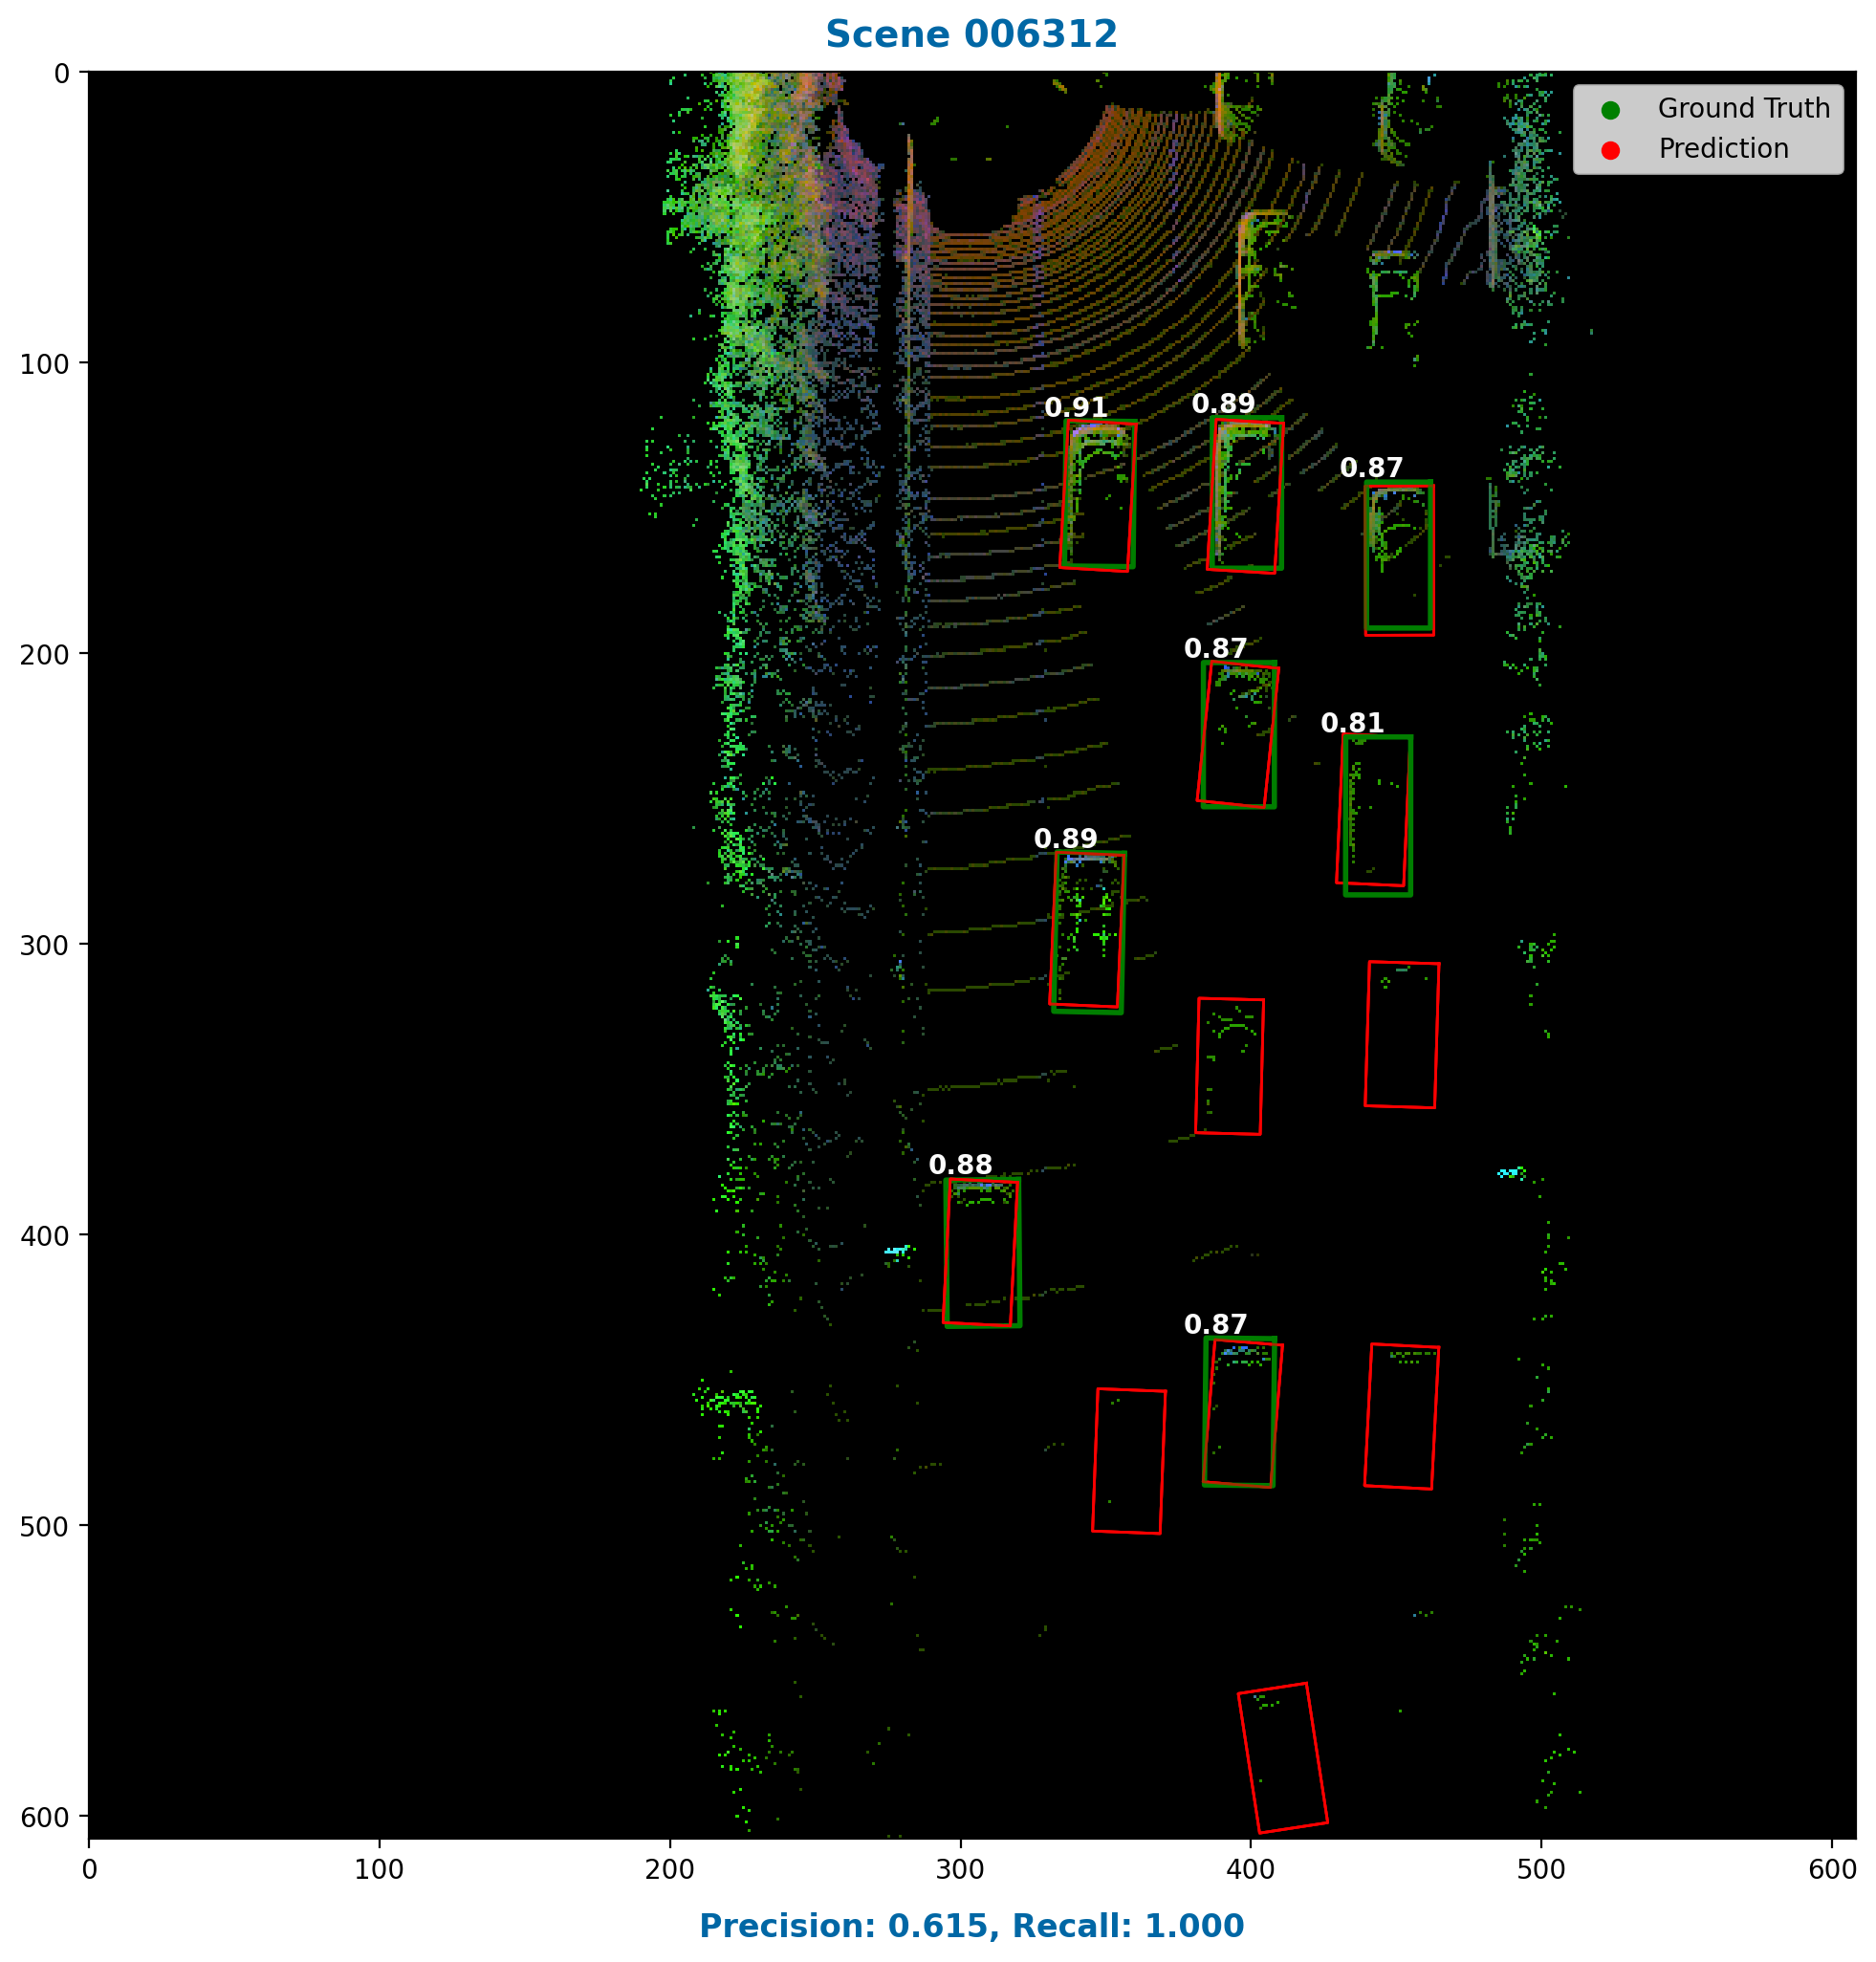

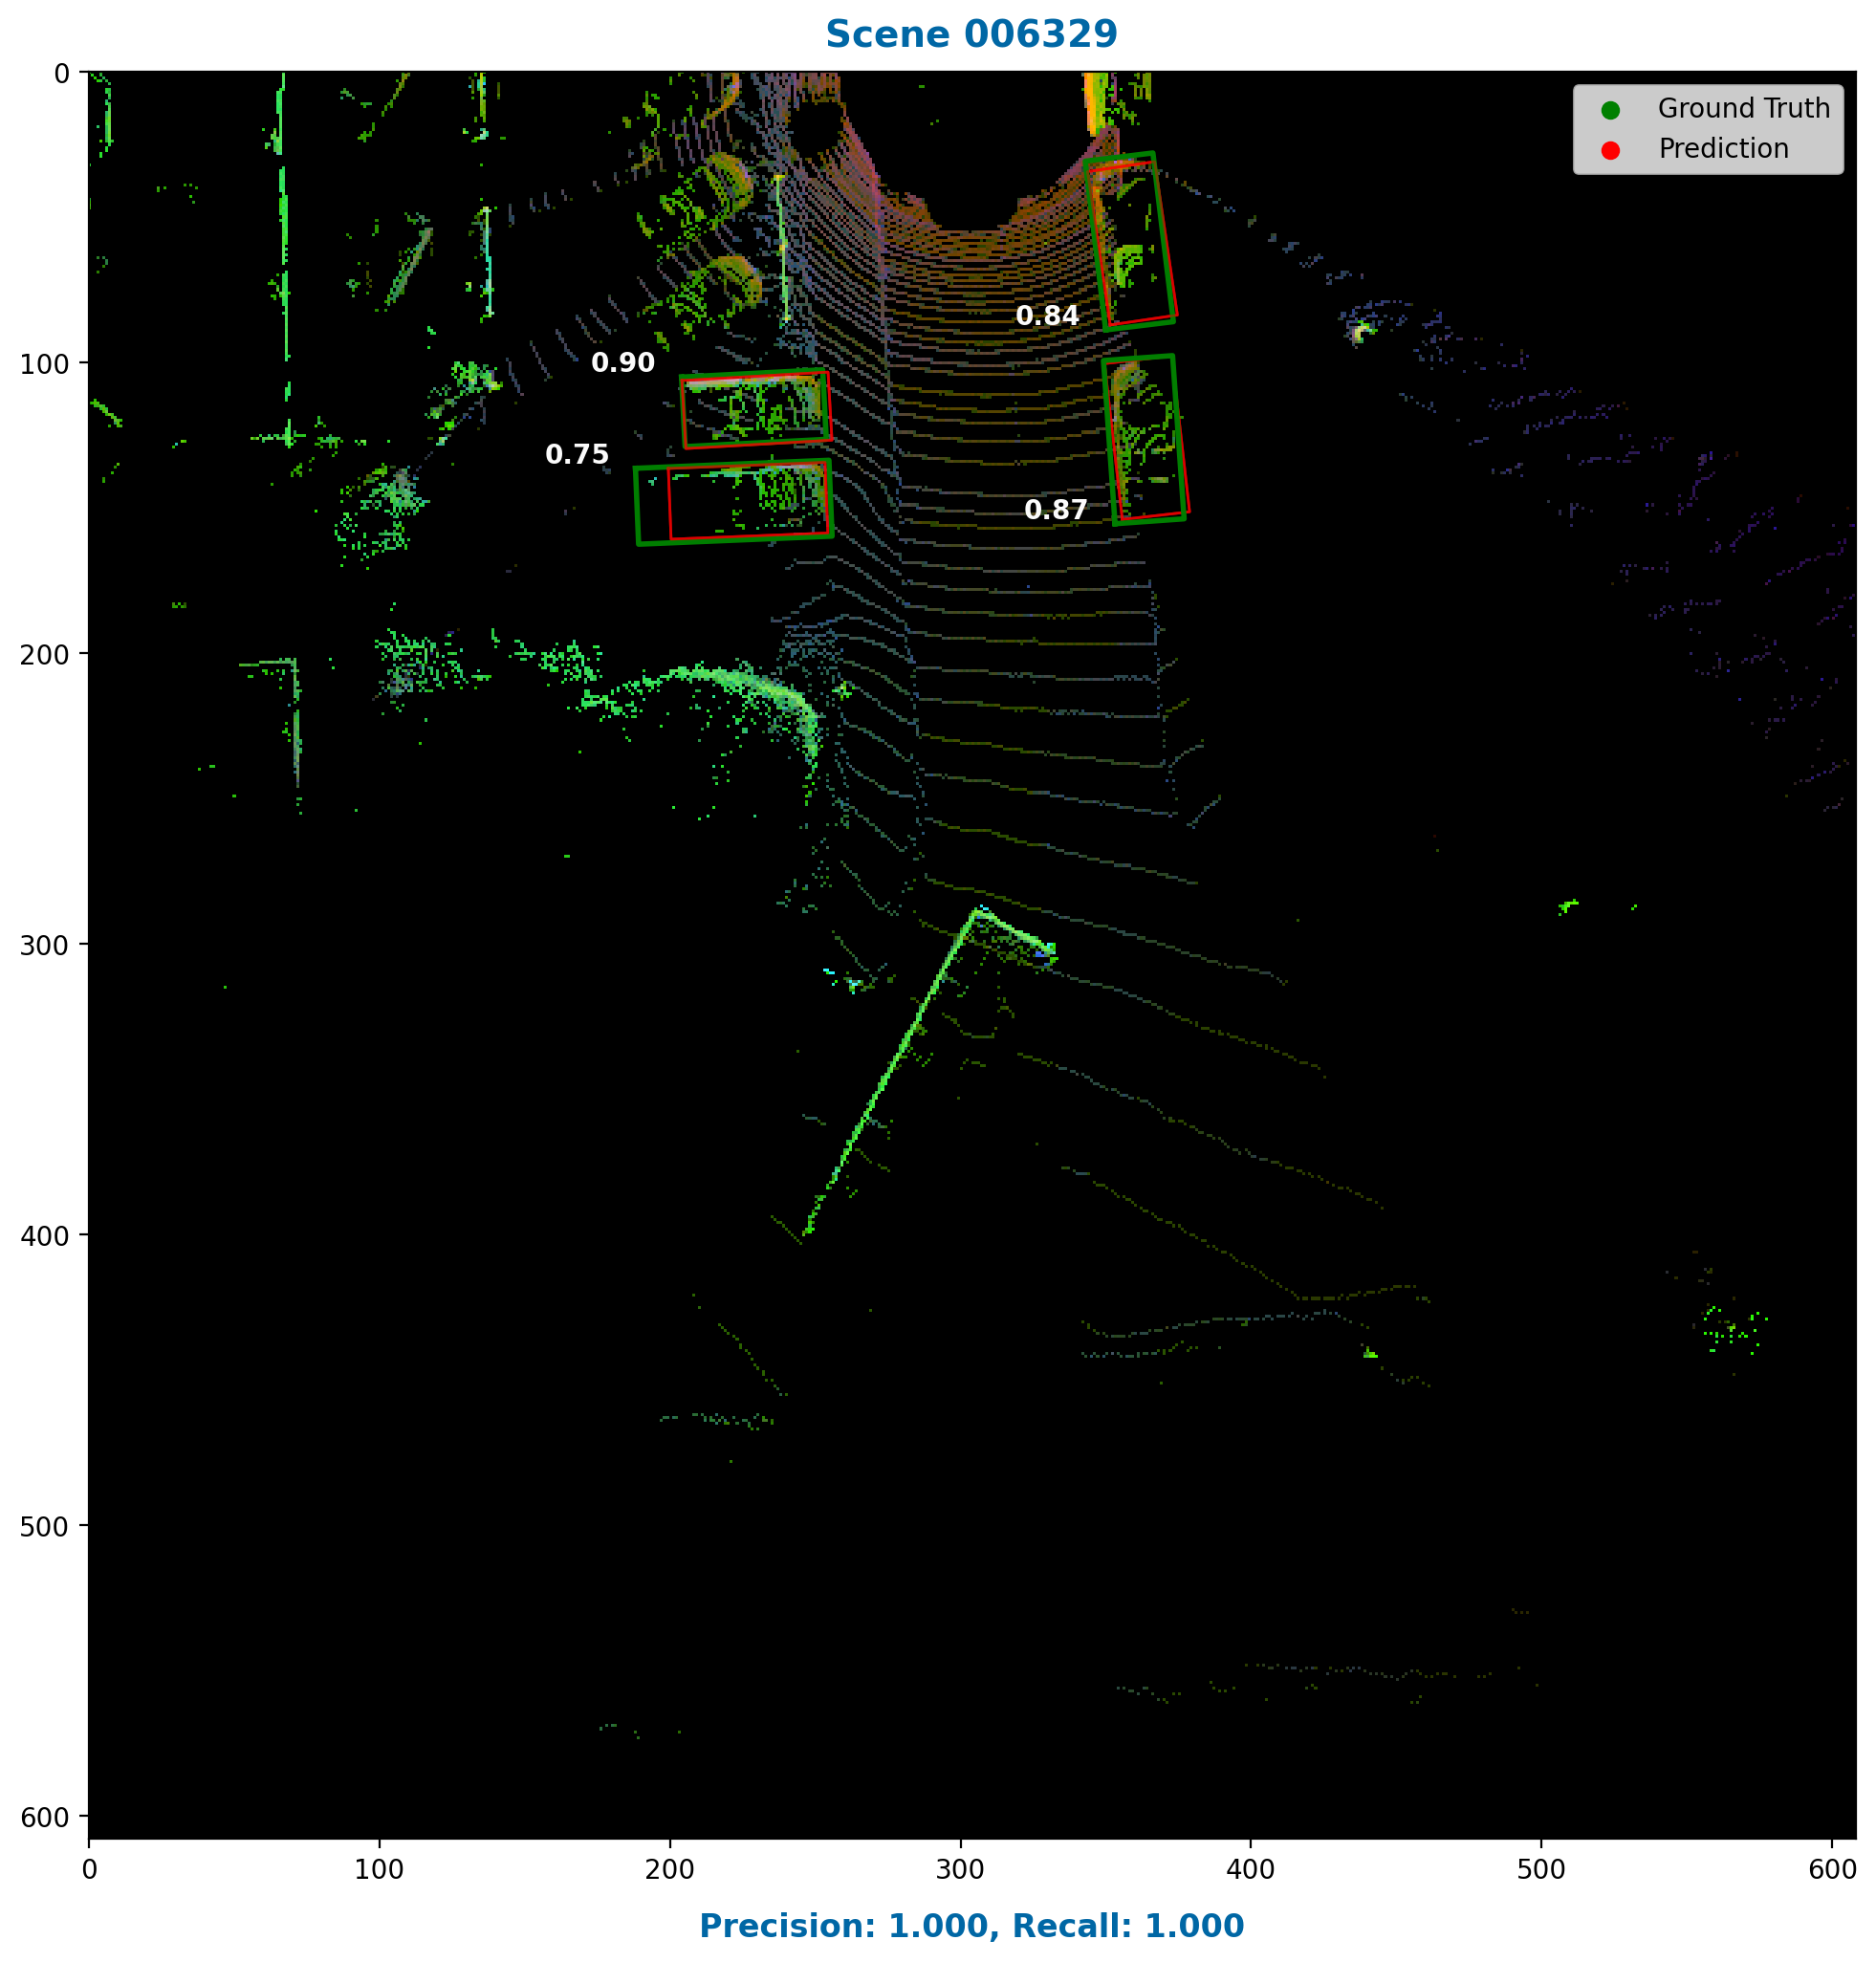

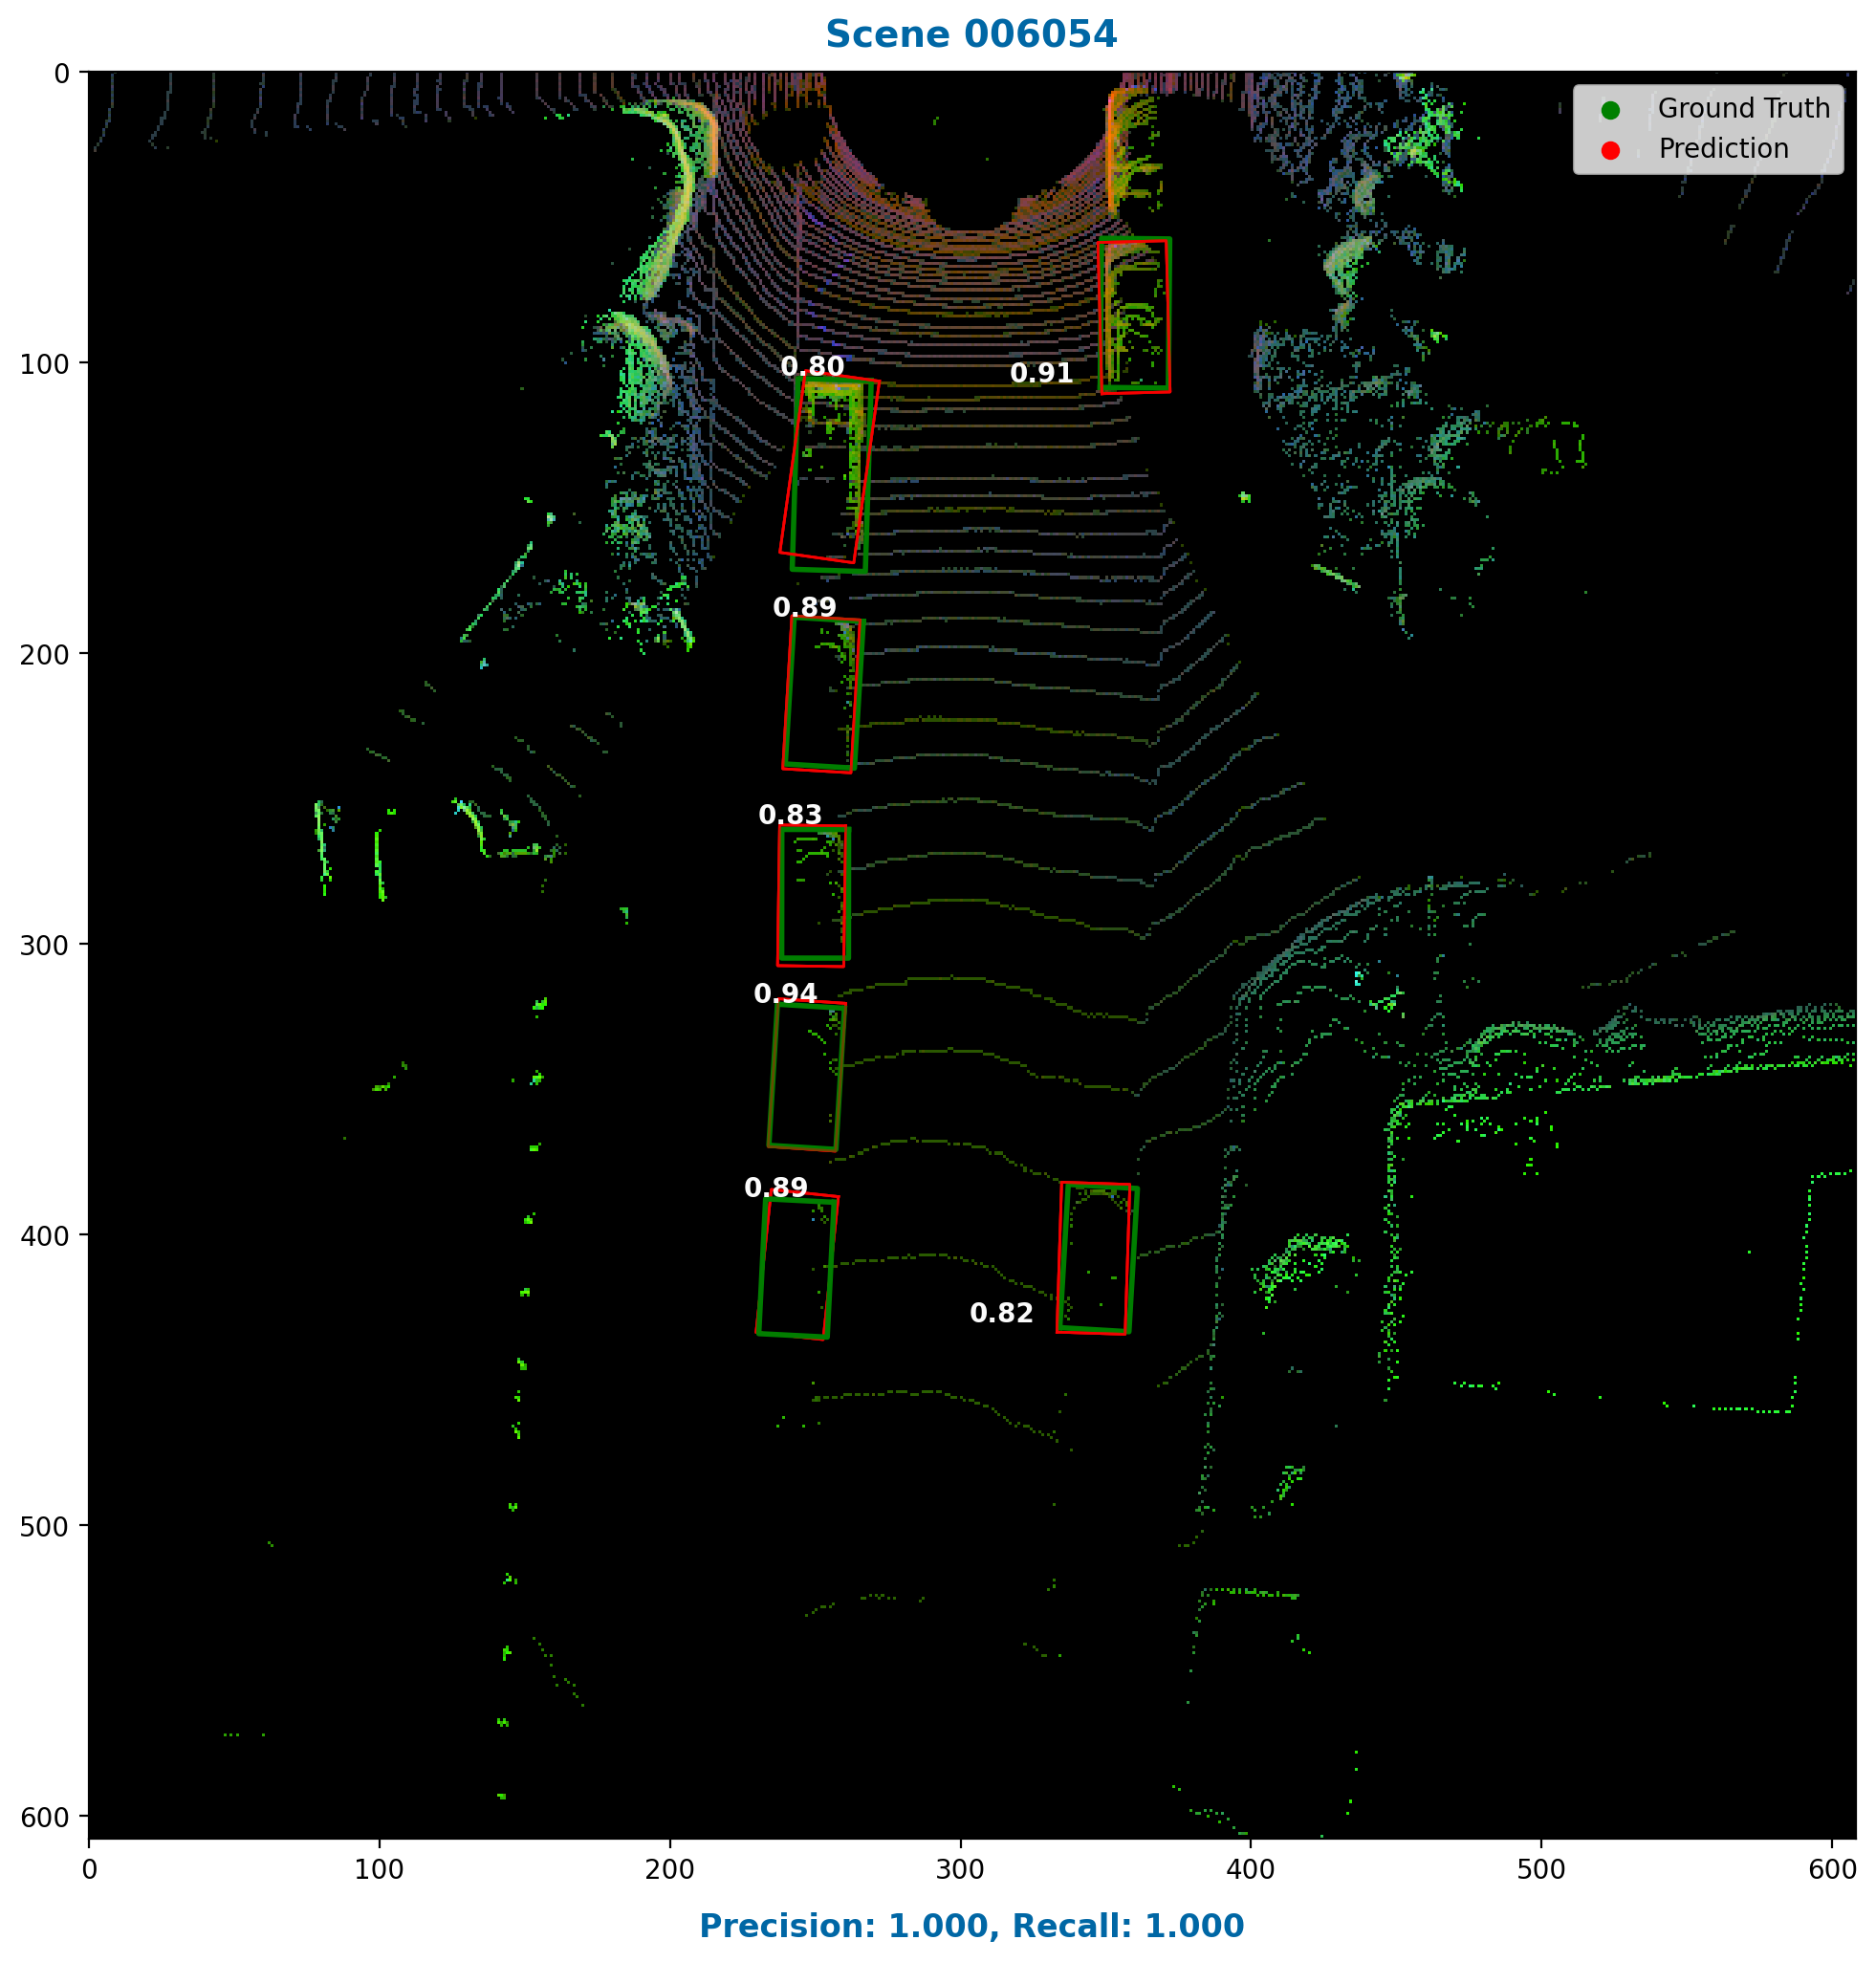

In [8]:
output_folder = f"./Output"

for scene_id in scene_ids:
    gt_labels = np.loadtxt(f"./KITTI_Selection/labels/{scene_id}.csv", delimiter=",", ndmin=2)
    pred_file_path = f"./KITTI_Selection/predictions/{scene_id}.csv"
    pred_labels = np.loadtxt(pred_file_path, delimiter=",") if os.path.exists(pred_file_path) and os.path.getsize(pred_file_path) > 0 else []
    process_scene(scene_id, gt_labels, pred_labels)